In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2469534 sha256=beb696f434361e49dde65abc001ade98ca438bfd0876827cd4305023f3a3dd5b
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
!pip install surprise

In [3]:
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math

In [4]:
# URL for the MovieLens latest small dataset
ml_url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
zip_path = "ml-latest-small.zip"
extract_path = "./"

urllib.request.urlretrieve(ml_url, zip_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define the path to the dataset files
data_path = './ml-latest-small/'

# Verify the files have been extracted correctly
for file_name in ['ratings.csv', 'movies.csv', 'tags.csv', 'links.csv']:
    file_path = os.path.join(data_path, file_name)
    if os.path.exists(file_path):
        print(f"File {file_name} exists at {file_path}")
        # Print first few lines to verify content
        df = pd.read_csv(file_path)
        print(f"Shape: {df.shape}")
        print(df.head(2))
        print("\n")
    else:
        print(f"ERROR: File {file_name} does not exist at {file_path}")

File ratings.csv exists at ./ml-latest-small/ratings.csv
Shape: (100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247


File movies.csv exists at ./ml-latest-small/movies.csv
Shape: (9742, 3)
   movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2    Jumanji (1995)                   Adventure|Children|Fantasy


File tags.csv exists at ./ml-latest-small/tags.csv
Shape: (3683, 4)
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996


File links.csv exists at ./ml-latest-small/links.csv
Shape: (9742, 3)
   movieId  imdbId  tmdbId
0        1  114709   862.0
1        2  113497  8844.0




In [5]:
# Set the display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 40)

# Define the path to the dataset files
data_path = './ml-latest-small/'

# First verify that the files exist
print("Checking if dataset files exist...")
all_files_exist = True
for file_name in ['ratings.csv', 'movies.csv', 'tags.csv']:
    file_path = os.path.join(data_path, file_name)
    if os.path.exists(file_path):
        print(f"File {file_name} exists.")
    else:
        print(f"ERROR: File {file_name} does not exist at {file_path}")
        all_files_exist = False

if not all_files_exist:
    print("Please run the download_movielens.py script first to download the dataset.")
    exit(1)

# Load the dataset files
print("\nLoading MovieLens dataset files...")

# Load ratings data
ratings_file = os.path.join(data_path, 'ratings.csv')
ratings = pd.read_csv(ratings_file)
print(f"\nSuccessfully loaded ratings data: {ratings.shape[0]} ratings")

# Load movies data
movies_file = os.path.join(data_path, 'movies.csv')
movies = pd.read_csv(movies_file)
print(f"Successfully loaded movies data: {movies.shape[0]} movies")

# Load tags data
tags_file = os.path.join(data_path, 'tags.csv')
tags = pd.read_csv(tags_file)
print(f"Successfully loaded tags data: {tags.shape[0]} tags")

# Initial inspection of data files
print("\n===== RATINGS DATA =====")
print(ratings.info())
print("\nFirst 5 rows of ratings data:")
print(ratings.head())
print("\nRatings statistics:")
print(ratings['rating'].describe())

print("\n===== MOVIES DATA =====")
print(movies.info())
print("\nFirst 5 rows of movies data:")
print(movies.head())

print("\n===== TAGS DATA =====")
print(tags.info())
print("\nFirst 5 rows of tags data:")
print(tags.head())

# Check for missing values
print("\n===== MISSING VALUES CHECK =====")
print("Missing values in ratings data:")
print(ratings.isnull().sum())
print("\nMissing values in movies data:")
print(movies.isnull().sum())
print("\nMissing values in tags data:")
print(tags.isnull().sum())

# Basic data quality checks
print("\n===== BASIC DATA QUALITY CHECKS =====")
print(f"Number of unique users: {ratings['userId'].nunique()}")
print(f"Number of unique movies: {ratings['movieId'].nunique()}")
print(f"Rating range: {ratings['rating'].min()} to {ratings['rating'].max()}")
print(f"Timestamp range: {pd.to_datetime(ratings['timestamp'], unit='s').min()} to {pd.to_datetime(ratings['timestamp'], unit='s').max()}")

# Check if all movies in ratings exist in movies dataframe
movies_in_ratings = set(ratings['movieId'].unique())
movies_in_movies = set(movies['movieId'].unique())
print(f"\nMovies in ratings but not in movies dataframe: {len(movies_in_ratings - movies_in_movies)}")
print(f"Movies in movies dataframe but not in ratings: {len(movies_in_movies - movies_in_ratings)}")

Checking if dataset files exist...
File ratings.csv exists.
File movies.csv exists.
File tags.csv exists.

Loading MovieLens dataset files...

Successfully loaded ratings data: 100836 ratings
Successfully loaded movies data: 9742 movies
Successfully loaded tags data: 3683 tags

===== RATINGS DATA =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

First 5 rows of ratings data:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Ratings statistics:
count

## EDA

In [6]:
# Set visual style for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Load data files
print("Loading dataset files...")
data_path = '/content/ml-latest-small'

ratings = pd.read_csv(os.path.join(data_path, 'ratings.csv'))
movies = pd.read_csv(os.path.join(data_path, 'movies.csv'))
tags = pd.read_csv(os.path.join(data_path, 'tags.csv'))
print("Dataset loaded successfully!")

print("\n===== 2.1 Data Overview Analysis =====")

# Basic statistics
print("\n1. Basic Statistics:")
print(f"Number of users: {ratings['userId'].nunique()}")
print(f"Number of movies: {movies['movieId'].nunique()}")
print(f"Number of ratings: {len(ratings)}")
print(f"Number of tags: {len(tags)}")

# Rating distribution statistics
print("\nRating Distribution:")
print(ratings['rating'].describe())

# Convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
print("\nRating Timespan:")
print(f"Earliest rating: {ratings['timestamp'].min()}")
print(f"Latest rating: {ratings['timestamp'].max()}")

# Data quality assessment
print("\nData Quality Assessment:")
print("Missing values in ratings:")
print(ratings.isnull().sum())
print("\nMissing values in movies:")
print(movies.isnull().sum())
print("\nMissing values in tags:")
print(tags.isnull().sum())

# Extract genres for analysis
print("\nExtracting genres...")
# Split the genres and create a list of all genres
all_genres = []
for genres in movies['genres'].str.split('|'):
    all_genres.extend(genres)

# Count the occurrence of each genre
genre_count = Counter(all_genres)
print("Most common genres:")
for genre, count in genre_count.most_common(10):
    print(f"{genre}: {count}")

Loading dataset files...
Dataset loaded successfully!

===== 2.1 Data Overview Analysis =====

1. Basic Statistics:
Number of users: 610
Number of movies: 9742
Number of ratings: 100836
Number of tags: 3683

Rating Distribution:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Rating Timespan:
Earliest rating: 1996-03-29 18:36:55
Latest rating: 2018-09-24 14:27:30

Data Quality Assessment:
Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values in tags:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Extracting genres...
Most common genres:
Drama: 4361
Comedy: 3756
Thriller: 1894
Action: 1828
Romance: 1596
Adventure: 1263
Crime: 1199
Sci-Fi: 980
Horror: 978
Fant


===== 2.2 Key Visualizations =====

1. Rating Distribution Visualization


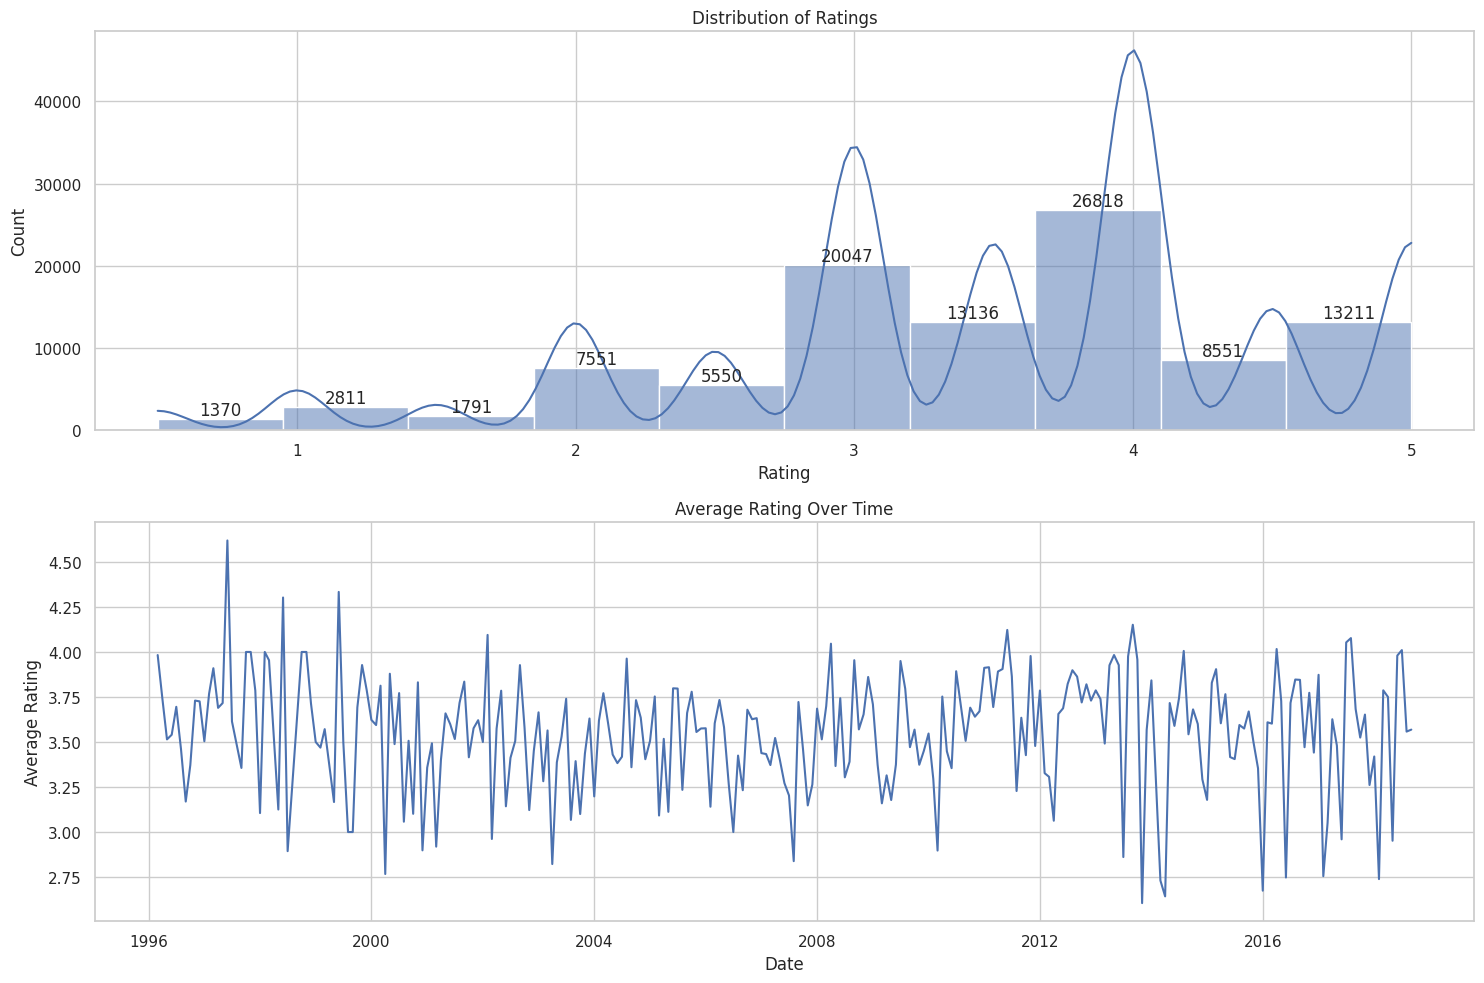

Rating distribution plots displayed.

2. User Activity Analysis


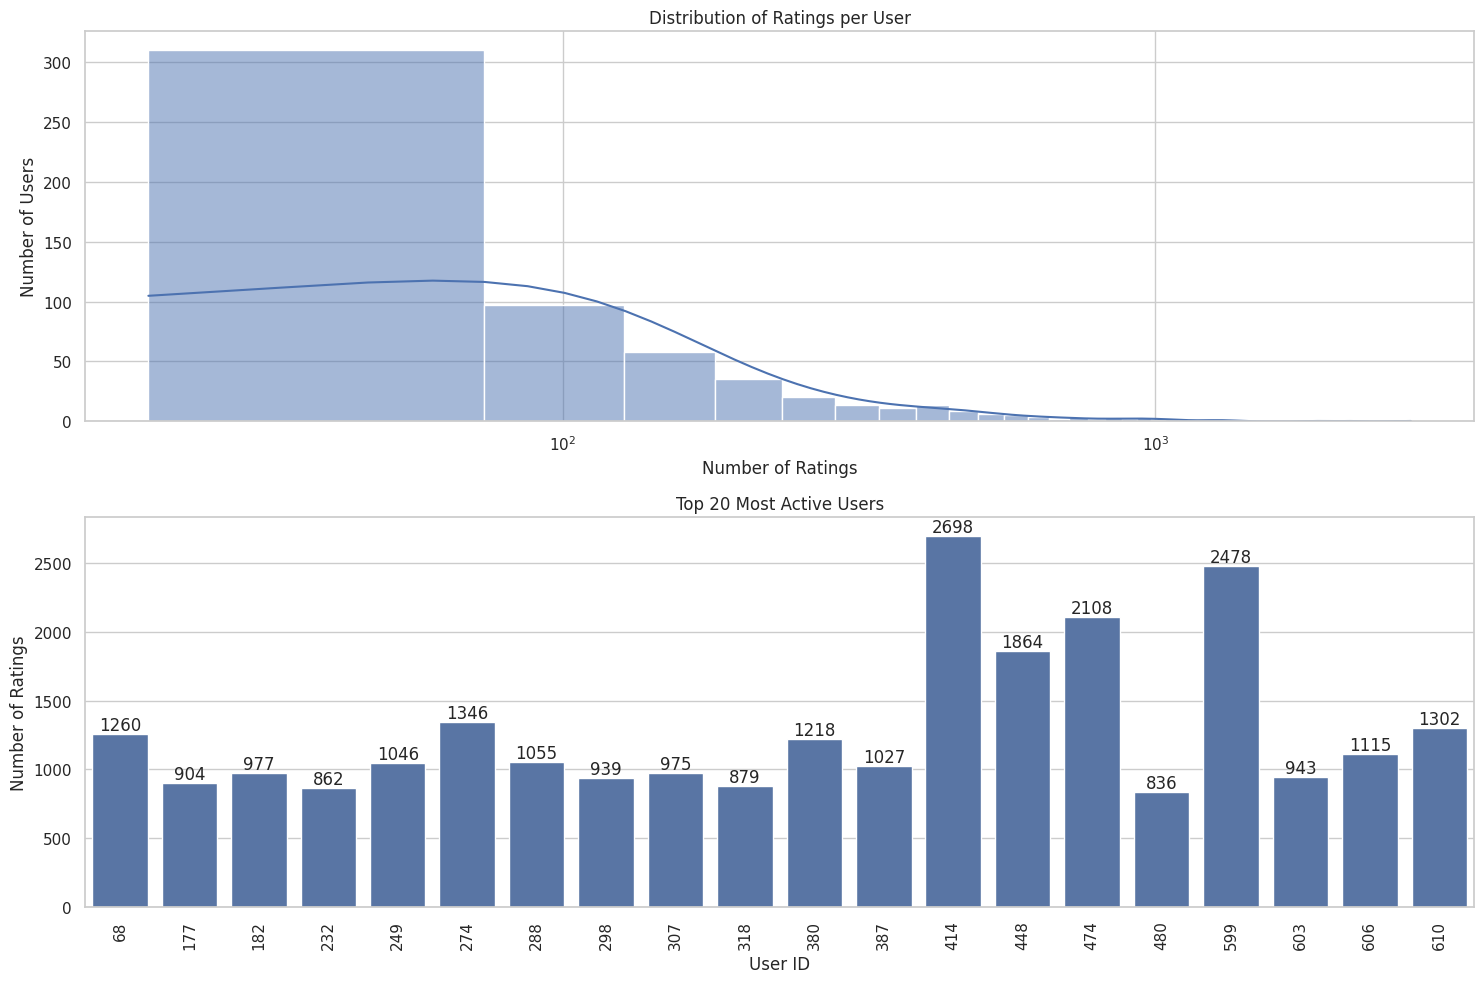

User activity plots displayed.

3. Movie Popularity Analysis


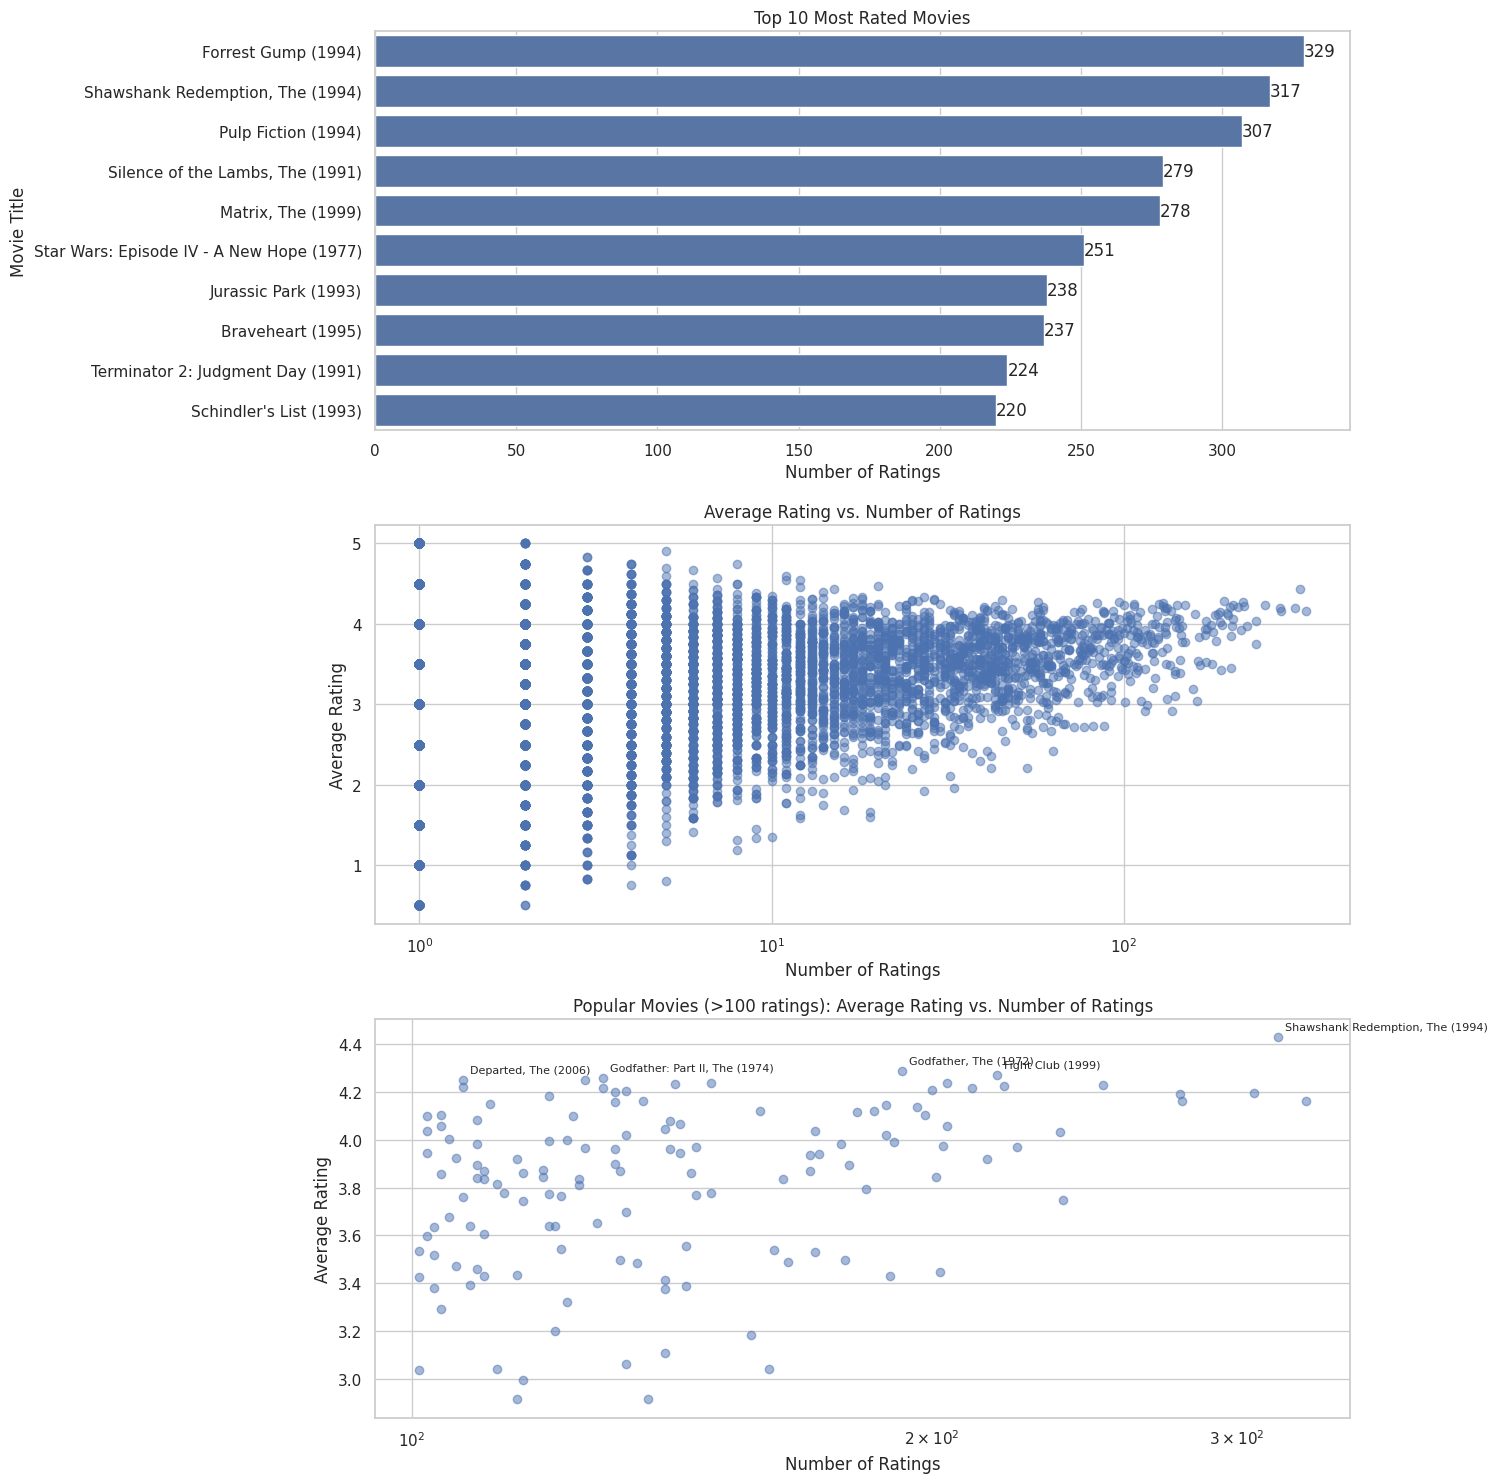

Movie popularity plots displayed.

4. Genre Analysis


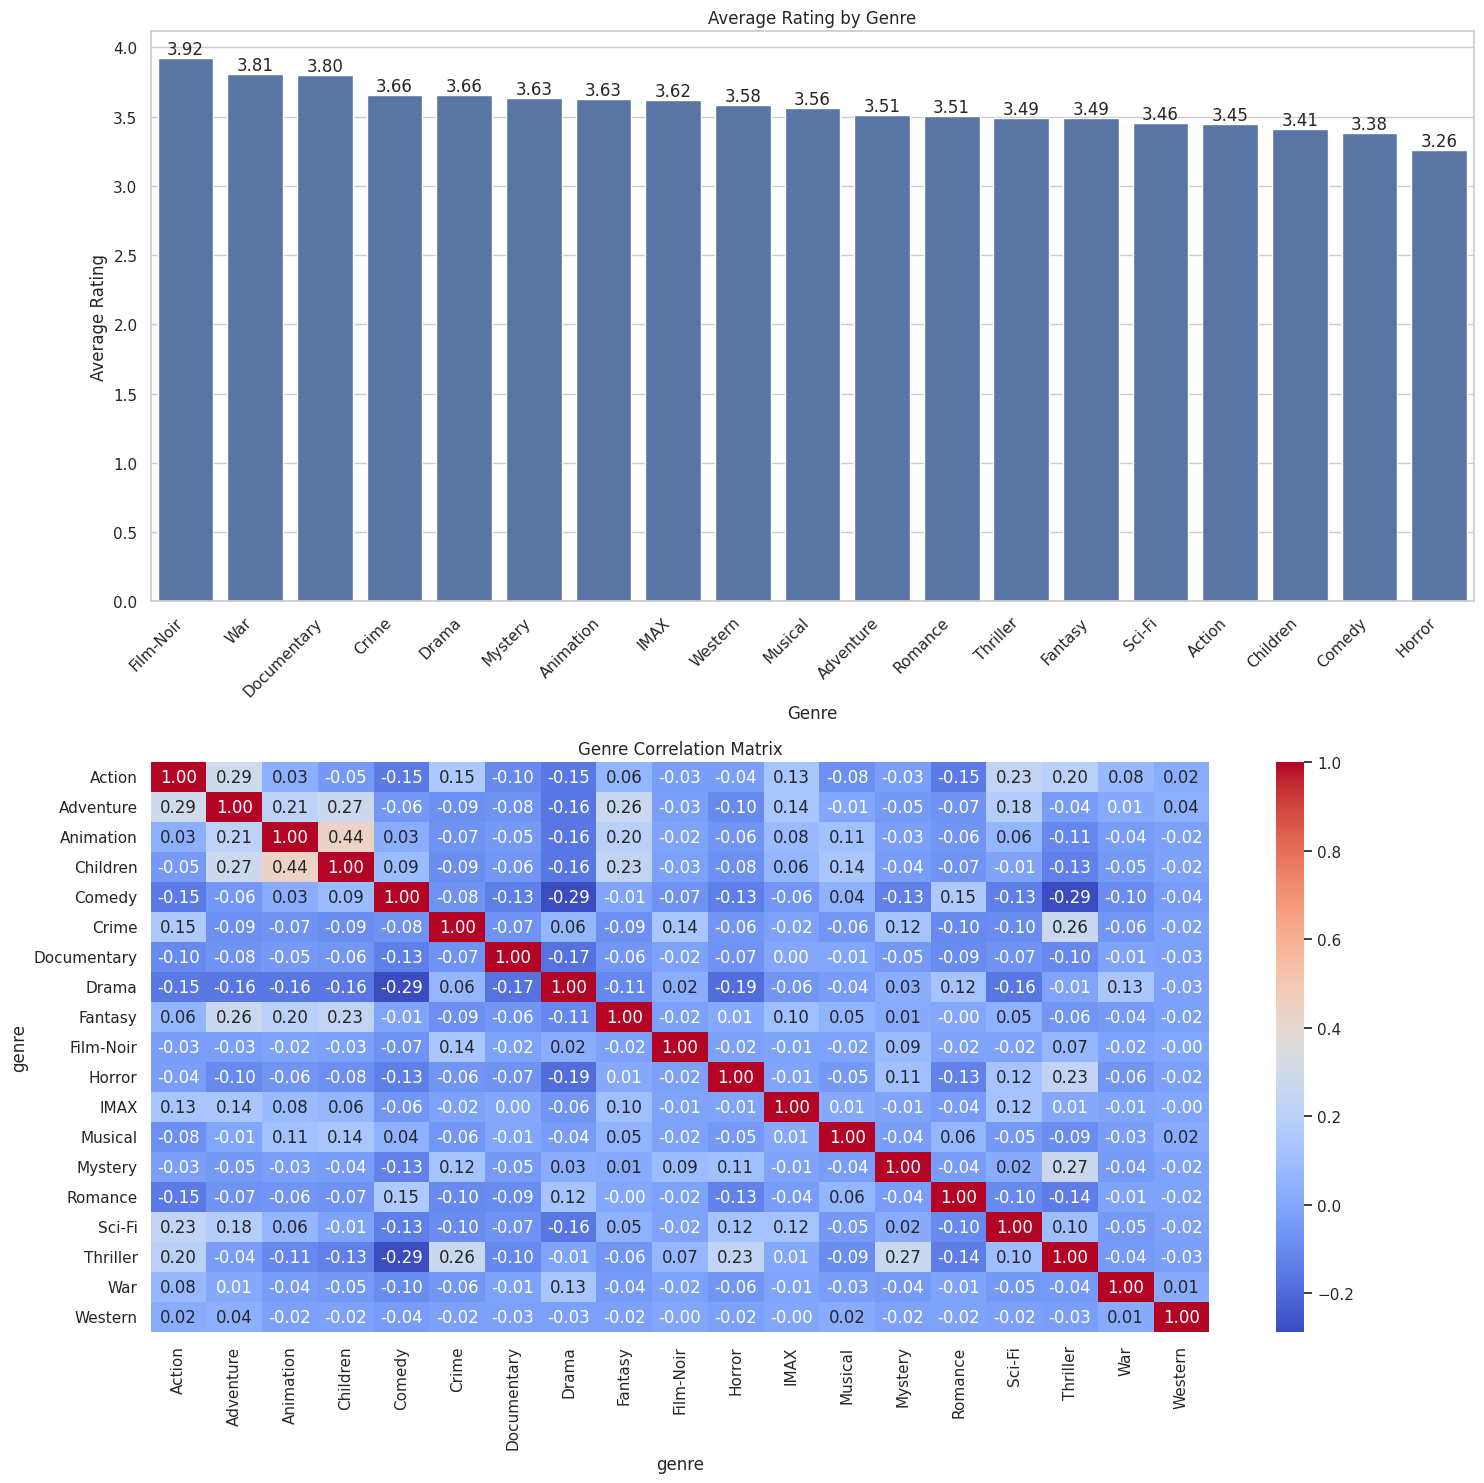

Genre analysis plots displayed.

5. Temporal Patterns


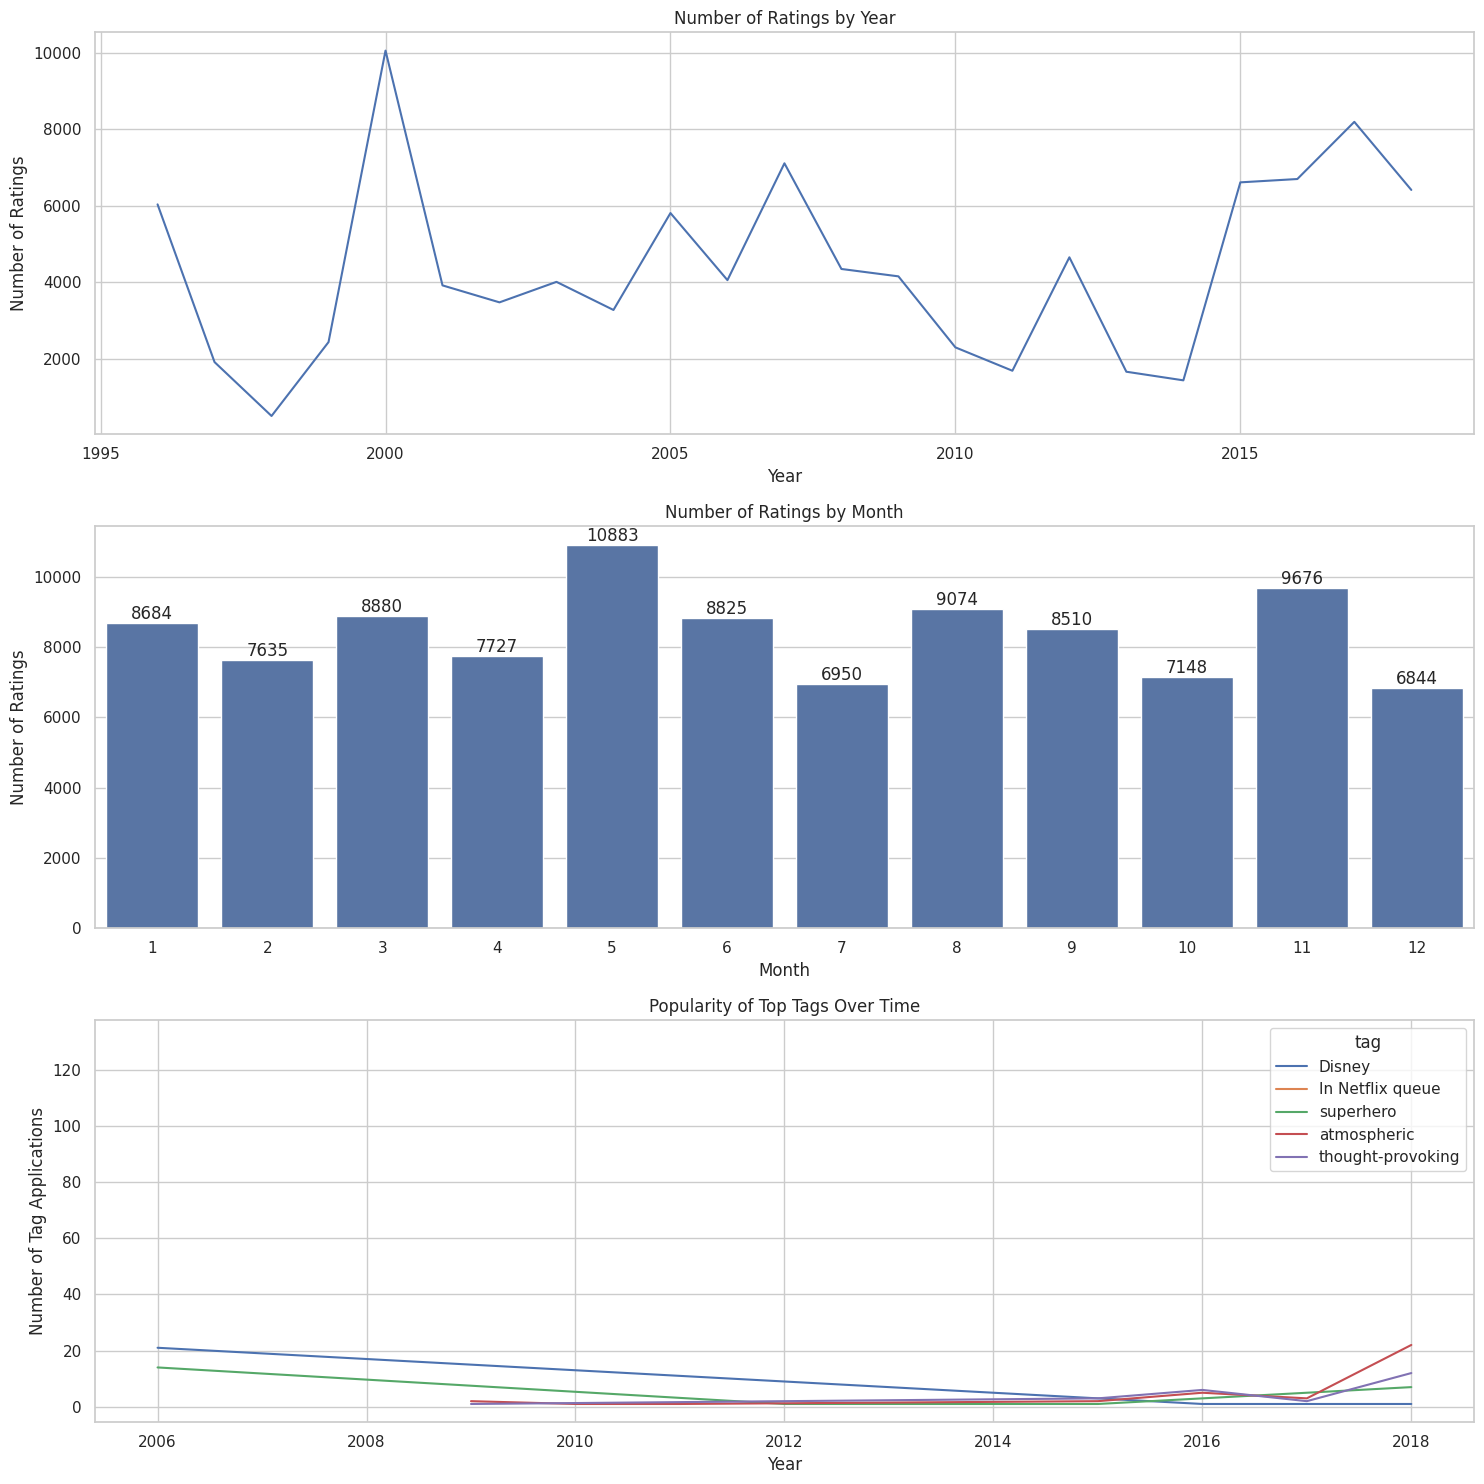

Temporal patterns plots displayed.

6. User Rating Consistency


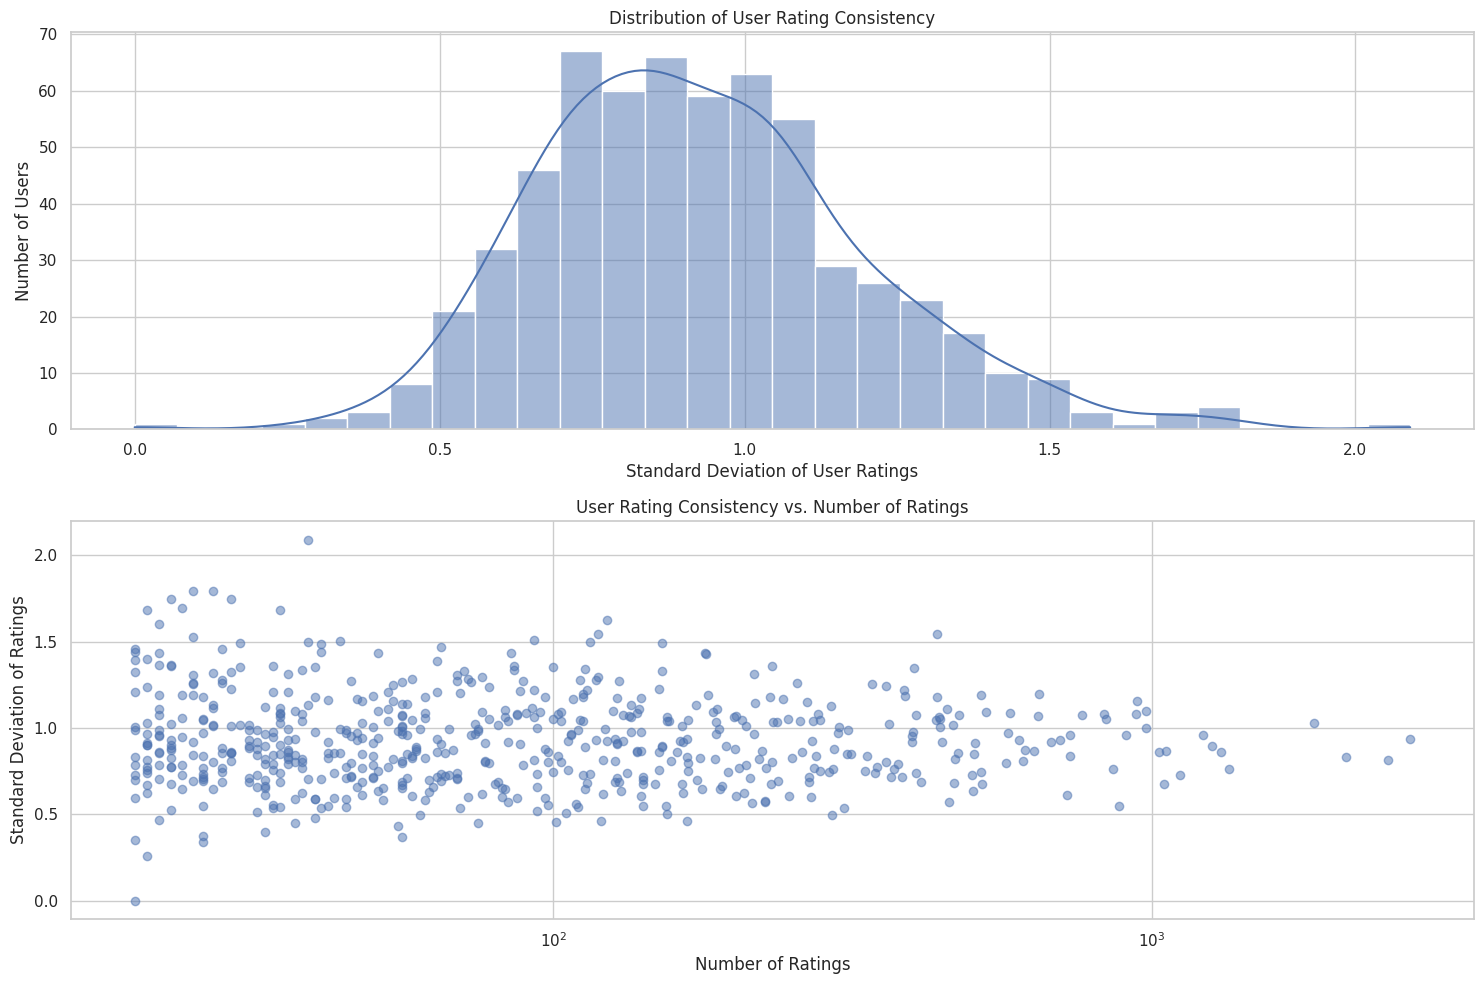

User consistency plots displayed.


In [9]:
print("\n===== 2.2 Key Visualizations =====")

# 1. Rating Distribution
print("\n1. Rating Distribution Visualization")
plt.figure(figsize=(15, 10))

# Rating histogram
plt.subplot(2, 1, 1)
ax1 = sns.histplot(ratings['rating'], bins=10, kde=True) # Ax ob'ektini saqlab olamiz
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Histogram ustunlariga qiymatlarni qo'shish
for patch in ax1.patches:
    height = patch.get_height()
    # Faqat nolga teng bo'lmagan balandliklarni annotatsiya qilamiz
    if height > 0:
        ax1.text(patch.get_x() + patch.get_width()/2., height,
                 f'{int(height)}', # Qiymatni butun son qilib ko'rsatamiz
                 ha='center', va='bottom') # Matnning joylashuvi

# Average rating over time
plt.subplot(2, 1, 2)
# Group by month and calculate mean
ratings_by_time = ratings.copy()
ratings_by_time['year_month'] = ratings_by_time['timestamp'].dt.to_period('M')
monthly_avg = ratings_by_time.groupby('year_month')['rating'].mean()

# Convert period index to datetime for plotting
monthly_avg.index = monthly_avg.index.to_timestamp()
plt.plot(monthly_avg.index, monthly_avg.values)
plt.title('Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.tight_layout()
# plt.savefig('rating_distribution.png')
# plt.close()
plt.show()
print("Rating distribution plots displayed.")

# 2. User Activity Analysis
print("\n2. User Activity Analysis")
plt.figure(figsize=(15, 10))

# Ratings per user
plt.subplot(2, 1, 1)
user_rating_counts = ratings['userId'].value_counts()
ax2 = sns.histplot(user_rating_counts, bins=50, kde=True) # Ax ob'ektini saqlab olamiz
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.xscale('log')

# User rating frequency
plt.subplot(2, 1, 2)
# Sort users by number of ratings
user_rating_counts = ratings['userId'].value_counts() # Yuqorida hisoblangan
top_users = user_rating_counts.head(20).index
top_user_data = user_rating_counts[user_rating_counts.index.isin(top_users)]
ax3 = sns.barplot(x=top_user_data.index, y=top_user_data.values) # Ax ob'ektini saqlab olamiz
plt.title('Top 20 Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)

# Barplot ustunlariga qiymatlarni qo'shish
for patch in ax3.patches:
    height = patch.get_height()
    ax3.text(patch.get_x() + patch.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
# plt.savefig('user_activity.png')
# plt.close()
plt.show()
print("User activity plots displayed.")

# 3. Movie Popularity Analysis
print("\n3. Movie Popularity Analysis")
plt.figure(figsize=(15, 15))

# Create a dataframe with movie info and rating counts
movie_stats = ratings.groupby('movieId').agg(
    rating_count=('rating', 'count'),
    rating_mean=('rating', 'mean')
).reset_index()

# Merge with movie titles
movie_stats = movie_stats.merge(movies[['movieId', 'title']], on='movieId')

# Most rated movies
plt.subplot(3, 1, 1)
top_rated_movies = movie_stats.sort_values('rating_count', ascending=False).head(10)
ax4 = sns.barplot(x='rating_count', y='title', data=top_rated_movies) # Ax ob'ektini saqlab olamiz
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')

# Barplot ustunlariga qiymatlarni qo'shish
for patch in ax4.patches:
    width = patch.get_width() # Gorizontal barplot uchun kenglikni olamiz
    ax4.text(width, patch.get_y() + patch.get_height()/2., # Matnning joylashuvi
             f'{int(width)}',
             ha='left', va='center') # Matnning joylashuvi

# Average rating vs. number of ratings (Scatter plot, sonlar ko'rsatilmaydi)
plt.subplot(3, 1, 2)
plt.scatter(movie_stats['rating_count'], movie_stats['rating_mean'], alpha=0.5)
plt.title('Average Rating vs. Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.xscale('log')

# Identify popular and highly rated movies (Scatter plot, sonlar ko'rsatilmaydi)
plt.subplot(3, 1, 3)
# Filter movies with at least 100 ratings
popular_movies = movie_stats[movie_stats['rating_count'] > 100]
plt.scatter(popular_movies['rating_count'], popular_movies['rating_mean'], alpha=0.5)

# Annotate some interesting points (Already annotating specific points)
for i, row in popular_movies.sort_values('rating_mean', ascending=False).head(5).iterrows():
    plt.annotate(row['title'], (row['rating_count'], row['rating_mean']),
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.title('Popular Movies (>100 ratings): Average Rating vs. Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.xscale('log')
plt.tight_layout()
# plt.savefig('movie_popularity.png')
# plt.close()
plt.show()
print("Movie popularity plots displayed.")

# 4. Genre Analysis
print("\n4. Genre Analysis")
plt.figure(figsize=(15, 15))

# Create a DataFrame for genres
genre_data = []
for _, row in movies.iterrows():
    movie_id = row['movieId']
    movie_title = row['title']
    for genre in row['genres'].split('|'):
        if genre != '(no genres listed)':
            genre_data.append({'movieId': movie_id, 'title': movie_title, 'genre': genre})

genre_df = pd.DataFrame(genre_data)

# Rating distribution by genre
plt.subplot(2, 1, 1)
# Merge genre data with ratings
genre_ratings = pd.merge(genre_df, ratings, on='movieId')
genre_avg = genre_ratings.groupby('genre')['rating'].mean().sort_values(ascending=False)

ax5 = sns.barplot(x=genre_avg.index, y=genre_avg.values) # Ax ob'ektini saqlab olamiz
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')

# Barplot ustunlariga qiymatlarni qo'shish (O'rtacha reytinglar, 2ta o'nlik kasr bilan ko'rsatamiz)
for patch in ax5.patches:
    height = patch.get_height()
    ax5.text(patch.get_x() + patch.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')


# Genre correlation heatmap (Heatmapda sonlar ko'rsatilgan annot=True orqali)
plt.subplot(2, 1, 2)
# Create a pivot table for genres per movie
genre_pivot = pd.crosstab(
    index=genre_df['movieId'],
    columns=genre_df['genre']
)

# Calculate correlation between genres
genre_corr = genre_pivot.corr()

# Plot heatmap
sns.heatmap(genre_corr, annot=True, fmt=".2f", cmap='coolwarm') # annot=True va fmt='.2f' qo'shildi
plt.title('Genre Correlation Matrix')
plt.tight_layout()
# plt.savefig('genre_analysis.png')
# plt.close()
plt.show()
print("Genre analysis plots displayed.")


# 5. Temporal Patterns
print("\n5. Temporal Patterns")
plt.figure(figsize=(15, 15))

# Ratings volume over time (Line plot, sonlar ko'rsatilmaydi)
plt.subplot(3, 1, 1)
ratings['year'] = ratings['timestamp'].dt.year
yearly_counts = ratings.groupby('year').size()
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values)
plt.title('Number of Ratings by Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')

# Seasonal trends (by month)
plt.subplot(3, 1, 2)
ratings['month'] = ratings['timestamp'].dt.month
monthly_counts = ratings.groupby('month').size()
ax6 = sns.barplot(x=monthly_counts.index, y=monthly_counts.values) # Ax ob'ektini saqlab olamiz
plt.title('Number of Ratings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')

# Barplot ustunlariga qiymatlarni qo'shish
for patch in ax6.patches:
    height = patch.get_height()
    ax6.text(patch.get_x() + patch.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Genre popularity over time (Line plot, sonlar ko'rsatilmaydi)
plt.subplot(3, 1, 3)
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')
tags['year'] = tags['timestamp'].dt.year
tag_counts_by_year = tags.groupby(['year', 'tag']).size().reset_index(name='count')

# Get top 5 tags overall
top_tags = tag_counts_by_year.groupby('tag')['count'].sum().sort_values(ascending=False).head(5).index

# Filter for only the top tags
top_tags_by_year = tag_counts_by_year[tag_counts_by_year['tag'].isin(top_tags)]

# Plot
sns.lineplot(data=top_tags_by_year, x='year', y='count', hue='tag')
plt.title('Popularity of Top Tags Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Tag Applications')
plt.tight_layout()
# plt.savefig('temporal_patterns.png')
# plt.close()
plt.show()
print("Temporal patterns plots displayed.")

# Additional Analysis: User Rating Consistency
print("\n6. User Rating Consistency")
plt.figure(figsize=(15, 10))

# Calculate standard deviation of ratings for each user
user_rating_std = ratings.groupby('userId')['rating'].std().dropna()

# Plot histogram of user rating standard deviations
plt.subplot(2, 1, 1)
ax7 = sns.histplot(user_rating_std, bins=30, kde=True) # Ax ob'ektini saqlab olamiz
plt.title('Distribution of User Rating Consistency')
plt.xlabel('Standard Deviation of User Ratings')
plt.ylabel('Number of Users')

# Bu histogramda ham juda ko'p binlar bo'lishi mumkin. Agar qo'shmoqchi bo'lsangiz:
# for patch in ax7.patches:
#     height = patch.get_height()
#     if height > 0:
#         ax7.text(patch.get_x() + patch.get_width()/2., height,
#                  f'{int(height)}',
#                  ha='center', va='bottom', fontsize=6)

# Compare number of ratings with rating consistency (Scatter plot, sonlar ko'rsatilmaydi)
plt.subplot(2, 1, 2)
user_rating_counts = ratings.groupby('userId').size()
consistency_vs_count = pd.DataFrame({
    'std': user_rating_std,
    'count': user_rating_counts[user_rating_std.index]
})

plt.scatter(consistency_vs_count['count'], consistency_vs_count['std'], alpha=0.5)
plt.title('User Rating Consistency vs. Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Standard Deviation of Ratings')
plt.xscale('log')
plt.tight_layout()
# plt.savefig('user_consistency.png')
# plt.close()
plt.show()
print("User consistency plots displayed.")

In [10]:
# Prepare a summary of key insights
print("\n===== 2.4 EDA Summary and Insights =====")

print("""
Tadqiqot ma'lumotlarini tahlil qilishning asosiy tushunchalari:

1. Reyting taqsimoti:
- O'rtacha reyting 3,5 atrofida bo'lib, ko'pchilik reytinglar 3,0 dan 4,5 gacha klasterlangan.
- Reytinglar vaqt o'tishi bilan ozgina tebranishlarni ko'rsatadi, lekin nisbatan barqaror bo'lib qoladi

2. Foydalanuvchi faoliyati:
- foydalanuvchi faoliyati hokimiyat qonuni taqsimotiga amal qiladi; kam sonli foydalanuvchilar ko'p sonli reytinglarni beradi
- Eng faol foydalanuvchilar minglab filmlarni baholagan bo'lsa, ko'pchilik foydalanuvchilar 100 dan kam baho berishadi

3. Filmning mashhurligi:
- Ommabop filmlar minglab baho oladi, lekin katta qismi 100 dan kam baho oladi
- Mashhurlik va o'rtacha reyting o'rtasida biroz ijobiy bog'liqlik bor
- Ba'zi yuqori baholangan filmlar nisbatan kam reytingga ega (potentsial "yashirin marvaridlar")

4. Janr tahlili:
- Ba'zi janrlar doimiy ravishda yuqori o'rtacha reytinglarni oladi (masalan, hujjatli filmlar, film-noir)
- Tegishli janrlar o'rtasida kuchli bog'liqlik mavjud (masalan, Harakat va Sarguzasht)
- Janr imtiyozlari foydalanuvchi bazasida farq qiladi, bu esa shaxsiylashtirish zarurligini bildiradi

5. Vaqtinchalik naqshlar:
- Reyting faolligi vaqt o'tishi bilan ortadi, ma'lum davrlarda eng yuqori darajaga etadi
- Foydalanuvchi faoliyatida mavsumiy naqshlar mavjud bo'lishi mumkin
- Teg foydalanish tendentsiyalari rivojlanayotgan kino tendentsiyalari va foydalanuvchilarning qiziqishlarini aks ettiradi

6. Foydalanuvchining muvofiqligi:
- foydalanuvchilar reytingning izchilligida farqlanadi; ba'zi foydalanuvchilar yuqori darajada barqaror reytinglarga ega, boshqalari esa ko'proq o'zgaruvchan
- Ko'proq reytingga ega bo'lgan foydalanuvchilar yanada barqaror reyting xatti-harakatlariga ega bo'lishadi

Oldindan ishlov berish bo'yicha tavsiyalar:
1. Foydalanuvchilar reytingidagi potentsial chegaralarni ko'rib chiqing (juda faol foydalanuvchilar modelni chalg'itishi mumkin)
2. Vaqtinchalik xususiyatlarni ko'rib chiqing, chunki ular reyting naqshlarida muhim ko'rinadi
3. Shaxsiy foydalanuvchi baholash shkalalarini hisobga olish uchun reytinglarni normallashtirish
4. Tavsiya modeli uchun muhim xususiyatlar sifatida janr ma'lumotlaridan foydalaning
5. Vaqtinchalik ta'sirlarni to'g'ri baholash uchun vaqtga asoslangan poezd/test bo'linmasidan foydalanishni o'ylab ko'ring

Ma'lumotlar to'plamidagi potentsial noaniqliklar:
1. Tanlovning noto'g'riligi: quvvat foydalanuvchilari nomutanosib ta'sirga ega
2. Mashhurlik tarafdori: Ommabop filmlar ko'proq reytingga ega
3. Vaqtinchalik tarafkashlik: vaqt o'tishi bilan reyting shakllari o'zgaradi
4. Janr tarafkashligi: Ayrim janrlar haddan tashqari ko‘p

Xususiyat muhandisligi bo'yicha takliflar:
1. Foydalanuvchi profili xususiyatlarini yarating (oʻrtacha reyting, reyting farqi, janr afzalliklari)
2. Vaqtinchalik xususiyatlarni ajratib oling (hafta kuni, kun vaqti, mavsumiylik)
3. Kino metadata xususiyatlarini ishlab chiqish (film yoshi, janr nisbati)
4. Foydalanuvchilar va filmlar o'rtasidagi o'zaro ta'sir xususiyatlarini hisoblang
5. Rivojlanayotgan foydalanuvchi didini qo'lga kiritish uchun yangilik xususiyatlarini ko'rib chiqing
""")

print("Exploratory Data Analysis completed!")


===== 2.4 EDA Summary and Insights =====

Tadqiqot ma'lumotlarini tahlil qilishning asosiy tushunchalari:

1. Reyting taqsimoti:
- O'rtacha reyting 3,5 atrofida bo'lib, ko'pchilik reytinglar 3,0 dan 4,5 gacha klasterlangan.
- Reytinglar vaqt o'tishi bilan ozgina tebranishlarni ko'rsatadi, lekin nisbatan barqaror bo'lib qoladi

2. Foydalanuvchi faoliyati:
- foydalanuvchi faoliyati hokimiyat qonuni taqsimotiga amal qiladi; kam sonli foydalanuvchilar ko'p sonli reytinglarni beradi
- Eng faol foydalanuvchilar minglab filmlarni baholagan bo'lsa, ko'pchilik foydalanuvchilar 100 dan kam baho berishadi

3. Filmning mashhurligi:
- Ommabop filmlar minglab baho oladi, lekin katta qismi 100 dan kam baho oladi
- Mashhurlik va o'rtacha reyting o'rtasida biroz ijobiy bog'liqlik bor
- Ba'zi yuqori baholangan filmlar nisbatan kam reytingga ega (potentsial "yashirin marvaridlar")

4. Janr tahlili:
- Ba'zi janrlar doimiy ravishda yuqori o'rtacha reytinglarni oladi (masalan, hujjatli filmlar, film-noir)


In [11]:
# Set random seed for reproducibility
np.random.seed(42)

print("Step 3: Data Preprocessing")
print("=========================")

# Load data files
print("Loading dataset files...")
data_path = './ml-latest-small/'

ratings = pd.read_csv(os.path.join(data_path, 'ratings.csv'))
movies = pd.read_csv(os.path.join(data_path, 'movies.csv'))
tags = pd.read_csv(os.path.join(data_path, 'tags.csv'))


# Convert timestamps to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# 1. Data Cleaning

# Check for missing values
print("Checking for missing values:")
print(f"Ratings missing values: {ratings.isnull().sum().sum()}")
print(f"Movies missing values: {movies.isnull().sum().sum()}")
print(f"Tags missing values: {tags.isnull().sum().sum()}")

# Handle missing values in movies data (if any)
if movies.isnull().sum().sum() > 0:
    print("Handling missing values in movies data...")
    # Fill missing titles with "Unknown Title"
    if movies['title'].isnull().sum() > 0:
        movies['title'] = movies['title'].fillna("Unknown Title")
    # Fill missing genres with "Unknown"
    if movies['genres'].isnull().sum() > 0:
        movies['genres'] = movies['genres'].fillna("Unknown")

# Check for and remove outliers in ratings
print("\nChecking for outliers in ratings...")
rating_counts = ratings.groupby('userId').size()
print(f"Rating counts per user - Min: {rating_counts.min()}, Max: {rating_counts.max()}, Mean: {rating_counts.mean():.2f}")
print(f"Users with fewer than 10 ratings: {(rating_counts < 10).sum()}")
print(f"Users with more than 1000 ratings: {(rating_counts > 1000).sum()}")

# Identify very extreme users
min_ratings_per_user = 5
max_ratings_per_user = 2500

# Remove users with too few or too many ratings
filtered_users = rating_counts[(rating_counts >= min_ratings_per_user) & (rating_counts <= max_ratings_per_user)].index
ratings_filtered = ratings[ratings['userId'].isin(filtered_users)]

print(f"Original ratings dataset shape: {ratings.shape}")
print(f"Filtered ratings dataset shape: {ratings_filtered.shape}")
print(f"Removed {ratings.shape[0] - ratings_filtered.shape[0]} ratings ({((ratings.shape[0] - ratings_filtered.shape[0]) / ratings.shape[0]) * 100:.2f}% of total)")

# Update ratings to the filtered version
ratings = ratings_filtered

# Check for rating distribution after filtering
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Rating Distribution After Filtering')
plt.savefig('rating_distribution_after_filtering.png')
plt.close()

Step 3: Data Preprocessing
Loading dataset files...
Checking for missing values:
Ratings missing values: 0
Movies missing values: 0
Tags missing values: 0

Checking for outliers in ratings...
Rating counts per user - Min: 20, Max: 2698, Mean: 165.30
Users with fewer than 10 ratings: 0
Users with more than 1000 ratings: 12
Original ratings dataset shape: (100836, 4)
Filtered ratings dataset shape: (98138, 4)
Removed 2698 ratings (2.68% of total)


In [12]:
# 2. Dataset splitting
print("\n3. Splitting dataset into train/validation/test sets...")

# Sort ratings by timestamp to create a time-based split
ratings_sorted = ratings.sort_values('timestamp')

# Calculate split indices (70% train, 15% validation, 15% test)
n_ratings = len(ratings_sorted)
train_end_idx = int(0.7 * n_ratings)
val_end_idx = int(0.85 * n_ratings)

# Create the splits
train_data = ratings_sorted.iloc[:train_end_idx]
val_data = ratings_sorted.iloc[train_end_idx:val_end_idx]
test_data = ratings_sorted.iloc[val_end_idx:]

print(f"Training set: {len(train_data)} ratings ({len(train_data)/n_ratings:.1%})")
print(f"Validation set: {len(val_data)} ratings ({len(val_data)/n_ratings:.1%})")
print(f"Test set: {len(test_data)} ratings ({len(test_data)/n_ratings:.1%})")

# Verify time-based split
print("\nVerifying time-based split:")
print(f"Training data time range: {train_data['timestamp'].min()} to {train_data['timestamp'].max()}")
print(f"Validation data time range: {val_data['timestamp'].min()} to {val_data['timestamp'].max()}")
print(f"Test data time range: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")


3. Splitting dataset into train/validation/test sets...
Training set: 68696 ratings (70.0%)
Validation set: 14721 ratings (15.0%)
Test set: 14721 ratings (15.0%)

Verifying time-based split:
Training data time range: 1996-03-29 18:36:55 to 2013-09-12 21:52:12
Validation data time range: 2013-09-12 22:09:58 to 2016-11-19 08:45:28
Test data time range: 2016-11-19 08:45:30 to 2018-09-24 14:27:30


In [13]:
# 3. Feature engineering
print("\n4. Feature engineering...")

# Create user features
print("Creating user features...")
user_features = ratings.groupby('userId').agg(
    user_mean_rating=('rating', 'mean'),
    user_rating_count=('rating', 'count'),
    user_rating_std=('rating', 'std'),
    user_latest_rating=('timestamp', 'max')
).fillna(0)

# Convert user_latest_rating datetime to numeric (Unix timestamp in seconds)
# Use .astype(int) to get nanoseconds timestamp and divide by 10**9 for seconds
user_features['user_latest_rating'] = user_features['user_latest_rating'].astype(int) / 10**9

# Normalize user features
user_scaler = MinMaxScaler()
user_features_scaled = user_scaler.fit_transform(user_features)
user_features_scaled = pd.DataFrame(
    user_features_scaled,
    index=user_features.index,
    columns=user_features.columns
)

print(f"Created {len(user_features)} user features")
print("User feature examples:")
print(user_features.head())

# Create movie features
print("\nCreating movie features...")

# Movie rating statistics
movie_features = ratings.groupby('movieId').agg(
    movie_mean_rating=('rating', 'mean'),
    movie_rating_count=('rating', 'count'),
    movie_rating_std=('rating', 'std'),
    movie_latest_rating=('timestamp', 'max')
).fillna(0)

# Convert datetime to numeric for scaling
movie_features['movie_latest_rating'] = movie_features['movie_latest_rating'].astype(int) / 10**9

# Normalize movie features
movie_scaler = MinMaxScaler()
movie_features_scaled = movie_scaler.fit_transform(movie_features)
movie_features_scaled = pd.DataFrame(
    movie_features_scaled,
    index=movie_features.index,
    columns=movie_features.columns
)

# Extract movie genres as one-hot encoding
print("Extracting movie genres...")
# Create a list of unique genres
genre_list = set()
for genres in movies['genres'].str.split('|'):
    genre_list.update(genres)

if '(no genres listed)' in genre_list:
    genre_list.remove('(no genres listed)')

# Create one-hot encoded genre features
for genre in genre_list:
    movies[f'genre_{genre}'] = movies['genres'].apply(
        lambda x: 1 if genre in x.split('|') else 0
    )

# Extract year from movie title
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
# Fill missing years with median
movies['year'] = movies['year'].fillna(movies['year'].median())
# Normalize year
movies['year_norm'] = (movies['year'] - movies['year'].min()) / (movies['year'].max() - movies['year'].min())

print(f"Created {movie_features.shape[1]} movie rating features and {len(genre_list)} genre features")
print("Movie feature examples:")
print(movie_features.head())

# Extract temporal features from timestamps
print("\nExtracting temporal features...")

def extract_temporal_features(df):
    """Extract temporal features from timestamp column"""
    df = df.copy()
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    # Convert timestamp to days since first rating
    min_timestamp = df['timestamp'].min()
    df['days_since_first'] = (df['timestamp'] - min_timestamp).dt.days
    return df

# Extract temporal features for each dataset
train_data = extract_temporal_features(train_data)
val_data = extract_temporal_features(val_data)
test_data = extract_temporal_features(test_data)

print("Temporal features extracted")
print("Examples of temporal features:")
print(train_data[['timestamp', 'day_of_week', 'hour_of_day', 'month', 'year', 'days_since_first']].head())

# Create user-item interaction features
print("\nCreating user-movie interaction features...")

# Get user genre preferences
user_genre_preferences = {}

for user_id in train_data['userId'].unique():
    # Get all movies rated by this user
    user_movies = train_data[train_data['userId'] == user_id]['movieId']
    # Get genres of these movies
    user_movie_genres = movies[movies['movieId'].isin(user_movies)]

    # Calculate average rating by genre for this user
    genre_ratings = {}
    for genre in genre_list:
        genre_col = f'genre_{genre}'
        if genre_col in user_movie_genres.columns:
            # Get movies of this genre rated by the user
            genre_movies = user_movie_genres[user_movie_genres[genre_col] == 1]['movieId']
            if len(genre_movies) > 0:
                # Get user ratings for these movies
                genre_movie_ratings = train_data[
                    (train_data['userId'] == user_id) &
                    (train_data['movieId'].isin(genre_movies))
                ]
                # Calculate average rating
                if len(genre_movie_ratings) > 0:
                    genre_ratings[genre] = genre_movie_ratings['rating'].mean()

    user_genre_preferences[user_id] = genre_ratings

# Create a function to build the user-item interaction feature for a given user-movie pair
def create_interaction_features(user_id, movie_id):
    features = {}

    # User-specific features
    if user_id in user_features.index:
        user_mean = user_features.loc[user_id, 'user_mean_rating']
        features['user_mean_rating'] = user_mean
    else:
        features['user_mean_rating'] = 0

    # Movie-specific features
    if movie_id in movie_features.index:
        movie_mean = movie_features.loc[movie_id, 'movie_mean_rating']
        features['movie_mean_rating'] = movie_mean
    else:
        features['movie_mean_rating'] = 0

    # Genre preference match
    if user_id in user_genre_preferences:
        user_prefs = user_genre_preferences[user_id]

        # Get movie genres
        movie_row = movies[movies['movieId'] == movie_id]
        if not movie_row.empty:
            movie_genres = [g for g in movie_row['genres'].iloc[0].split('|')
                           if g in genre_list]

            # Calculate genre preference score
            genre_score = 0
            count = 0
            for genre in movie_genres:
                if genre in user_prefs:
                    genre_score += user_prefs[genre]
                    count += 1

            if count > 0:
                features['genre_preference_score'] = genre_score / count
            else:
                features['genre_preference_score'] = 0
        else:
            features['genre_preference_score'] = 0
    else:
        features['genre_preference_score'] = 0

    return features

# Sample a small subset to demonstrate interaction features
sample_interactions = train_data.sample(5)
for _, row in sample_interactions.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    interaction_features = create_interaction_features(user_id, movie_id)
    print(f"User {user_id}, Movie {movie_id}: {interaction_features}")

# Create user-item matrix (for matrix factorization approaches)
print("\n5. Creating user-item matrix...")

# Create a sparse matrix representation of user-item interactions
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()

# Create mapping dictionaries
user_id_map = {id: i for i, id in enumerate(user_ids)}
movie_id_map = {id: i for i, id in enumerate(movie_ids)}
reverse_user_id_map = {i: id for id, i in user_id_map.items()}
reverse_movie_id_map = {i: id for id, i in movie_id_map.items()}

# Function to create sparse matrix for a dataset
def create_user_item_matrix(data):
    n_users = len(user_ids)
    n_movies = len(movie_ids)

    # Initialize matrix with zeros
    matrix = np.zeros((n_users, n_movies))

    # Fill in the matrix with ratings
    for _, row in data.iterrows():
        user_idx = user_id_map[row['userId']]
        movie_idx = movie_id_map[row['movieId']]
        matrix[user_idx, movie_idx] = row['rating']

    return matrix

# Create matrices for train, validation, and test sets
train_matrix = create_user_item_matrix(train_data)
val_matrix = create_user_item_matrix(val_data)
test_matrix = create_user_item_matrix(test_data)

print(f"Train matrix shape: {train_matrix.shape}")
print(f"Validation matrix shape: {val_matrix.shape}")
print(f"Test matrix shape: {test_matrix.shape}")
print(f"Sparsity: {train_matrix.nonzero()[0].shape[0] / (train_matrix.shape[0] * train_matrix.shape[1]):.5f}")

# Save preprocessed data
print("\n6. Saving preprocessed data...")

preprocessed_data = {
    'train_data': train_data,
    'val_data': val_data,
    'test_data': test_data,
    'train_matrix': train_matrix,
    'val_matrix': val_matrix,
    'test_matrix': test_matrix,
    'user_features': user_features,
    'movie_features': movie_features,
    'user_features_scaled': user_features_scaled,
    'movie_features_scaled': movie_features_scaled,
    'movies': movies,
    'user_id_map': user_id_map,
    'movie_id_map': movie_id_map,
    'reverse_user_id_map': reverse_user_id_map,
    'reverse_movie_id_map': reverse_movie_id_map,
    'genre_list': list(genre_list),
    'user_genre_preferences': user_genre_preferences
}

with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

print("Preprocessing completed and data saved to 'preprocessed_data.pkl'")

# Generate a summary of preprocessing steps and results
print("\n===== Data Preprocessing Summary =====")
print(f"Original dataset: {len(ratings_filtered)} ratings")
print(f"After filtering: {len(ratings)} ratings")
print(f"Number of users: {len(user_features)}")
print(f"Number of movies: {len(movie_features)}")
print(f"Train set: {len(train_data)} ratings")
print(f"Validation set: {len(val_data)} ratings")
print(f"Test set: {len(test_data)} ratings")
print(f"Sparsity level: {(1 - (ratings.shape[0] / (len(user_ids) * len(movie_ids)))):.4f}")
print(f"User features: {user_features.shape[1]}")
print(f"Movie features: {movie_features.shape[1]} + {len(genre_list)} genre features")


4. Feature engineering...
Creating user features...
Created 609 user features
User feature examples:
        user_mean_rating  user_rating_count  user_rating_std  user_latest_rating
userId                                                                          
1               4.366379                232         0.800048        9.657197e+08
2               3.948276                 29         0.805615        1.445715e+09
3               2.435897                 39         2.090642        1.306464e+09
4               3.555556                216         1.314204        1.007575e+09
5               3.636364                 44         0.990441        8.474353e+08

Creating movie features...
Extracting movie genres...
Created 4 movie rating features and 19 genre features
Movie feature examples:
         movie_mean_rating  movie_rating_count  movie_rating_std  movie_latest_rating
movieId                                                                              
1                 3.920561

In [14]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Step 4: Model Development and Training")
print("==========================================================")

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load preprocessed data
try:
    with open('preprocessed_data.pkl', 'rb') as f:
        data = pickle.load(f)

    train_data = data['train_data']
    val_data = data['val_data']
    test_data = data['test_data']
    train_matrix = data['train_matrix']
    val_matrix = data['val_matrix']
    test_matrix = data['test_matrix']
    user_features = data['user_features']
    movie_features = data['movie_features']
    user_features_scaled = data['user_features_scaled']
    movie_features_scaled = data['movie_features_scaled']
    movies = data['movies']
    user_id_map = data['user_id_map']
    movie_id_map = data['movie_id_map']
    reverse_user_id_map = data['reverse_user_id_map']
    reverse_movie_id_map = data['reverse_movie_id_map']
    genre_list = data['genre_list']
    user_genre_preferences = data['user_genre_preferences']

    print("Preprocessed data loaded successfully!")
    print(f"Training data: {len(train_data)} ratings")
    print(f"Validation data: {len(val_data)} ratings")
    print(f"Test data: {len(test_data)} ratings")
except FileNotFoundError:
    print("Error: Preprocessed data file not found. Please run the data preprocessing script first.")
    exit(1)

# Create directory for saving models
if not os.path.exists('models'):
    os.makedirs('models')

# Create directory for saving results
if not os.path.exists('results'):
    os.makedirs('results')

# 1. PyTorch Implementation of Matrix Factorization
class MatrixFactorization(nn.Module):
    """Matrix Factorization model implemented with PyTorch"""

    def __init__(self, n_users, n_items, n_factors=50, bias=True):
        super(MatrixFactorization, self).__init__()

        # User and item embeddings
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)

        # Bias terms
        self.bias = bias
        if bias:
            self.user_bias = nn.Embedding(n_users, 1)
            self.item_bias = nn.Embedding(n_items, 1)
            self.global_bias = nn.Parameter(torch.zeros(1))

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights with Gaussian distribution"""
        nn.init.normal_(self.user_factors.weight, std=0.1)
        nn.init.normal_(self.item_factors.weight, std=0.1)

        if self.bias:
            nn.init.zeros_(self.user_bias.weight)
            nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_indices, item_indices):
        # Look up embeddings
        user_embedding = self.user_factors(user_indices)
        item_embedding = self.item_factors(item_indices)

        # Compute dot product
        dot_product = torch.sum(user_embedding * item_embedding, dim=1)

        # Add bias terms if enabled
        if self.bias:
            user_b = self.user_bias(user_indices).squeeze()
            item_b = self.item_bias(item_indices).squeeze()
            pred = self.global_bias + user_b + item_b + dot_product
        else:
            pred = dot_product

        return pred

# Create PyTorch Dataset for all models
class MovieLensDataset(Dataset):
    """MovieLens PyTorch dataset"""

    def __init__(self, ratings_df, n_users, n_items, user_id_map, movie_id_map):
        self.ratings_df = ratings_df
        self.n_users = n_users
        self.n_items = n_items
        self.user_id_map = user_id_map
        self.movie_id_map = movie_id_map

    def __len__(self):
        return len(self.ratings_df)

    def __getitem__(self, idx):
        row = self.ratings_df.iloc[idx]

        user_id = row['userId']
        movie_id = row['movieId']
        rating = row['rating']

        # Convert to internal indices
        user_idx = self.user_id_map[user_id]
        movie_idx = self.movie_id_map[movie_id]

        return {
            'user_idx': torch.tensor(user_idx, dtype=torch.long),
            'movie_idx': torch.tensor(movie_idx, dtype=torch.long),
            'rating': torch.tensor(rating, dtype=torch.float)
        }

# Create datasets and dataloaders
train_dataset = MovieLensDataset(
    train_data,
    len(user_id_map),
    len(movie_id_map),
    user_id_map,
    movie_id_map
)

val_dataset = MovieLensDataset(
    val_data,
    len(user_id_map),
    len(movie_id_map),
    user_id_map,
    movie_id_map
)

test_dataset = MovieLensDataset(
    test_data,
    len(user_id_map),
    len(movie_id_map),
    user_id_map,
    movie_id_map
)

# Create DataLoaders
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Function to train and evaluate models
def train_and_evaluate(model, train_loader, val_loader, test_loader,
                       optimizer, criterion, n_epochs, device, early_stopping=5):
    """Train and evaluate model"""

    # Training and validation history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_rmse': [],
        'val_mae': []
    }

    # Best model tracking
    best_val_rmse = float('inf')
    best_model_state = None
    no_improvement_count = 0

    # Training loop
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
            user_idx = batch['user_idx'].to(device)
            movie_idx = batch['movie_idx'].to(device)
            rating = batch['rating'].to(device)

            # Forward pass
            prediction = model(user_idx, movie_idx)
            loss = criterion(prediction, rating)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * user_idx.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for batch in val_loader:
                user_idx = batch['user_idx'].to(device)
                movie_idx = batch['movie_idx'].to(device)
                rating = batch['rating'].to(device)

                # Forward pass
                prediction = model(user_idx, movie_idx)
                loss = criterion(prediction, rating)

                val_loss += loss.item() * user_idx.size(0)
                val_preds.extend(prediction.cpu().numpy())
                val_targets.extend(rating.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
        val_mae = mean_absolute_error(val_targets, val_preds)

        history['val_loss'].append(val_loss)
        history['val_rmse'].append(val_rmse)
        history['val_mae'].append(val_mae)

        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}")

        # Save best model
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model_state = model.state_dict().copy()
            print(f"New best model saved with validation RMSE: {best_val_rmse:.4f}")
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Early stopping
        if early_stopping > 0 and no_improvement_count >= early_stopping:
            print(f"Early stopping after {epoch+1} epochs with no improvement")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    # Evaluate on test set
    model.eval()
    test_preds = []
    test_targets = []

    with torch.no_grad():
        for batch in test_loader:
            user_idx = batch['user_idx'].to(device)
            movie_idx = batch['movie_idx'].to(device)
            rating = batch['rating'].to(device)

            # Forward pass
            prediction = model(user_idx, movie_idx)

            test_preds.extend(prediction.cpu().numpy())
            test_targets.extend(rating.cpu().numpy())

    test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))
    test_mae = mean_absolute_error(test_targets, test_preds)

    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")

    return model, history, test_rmse, test_mae, test_preds, test_targets

Step 4: Model Development and Training
Using device: cuda
Preprocessed data loaded successfully!
Training data: 68696 ratings
Validation data: 14721 ratings
Test data: 14721 ratings


In [15]:
# 2.1 Pure Matrix Factorization
print("\nTraining MF (Matrix Factorization) model")

# Hyperparameters for MF
mf_configs = [
    {'n_factors': 50, 'bias': True, 'lr': 0.005, 'weight_decay': 0.02},
    {'n_factors': 100, 'bias': True, 'lr': 0.003, 'weight_decay': 0.02},
    {'n_factors': 150, 'bias': True, 'lr': 0.001, 'weight_decay': 0.05}
]

best_mf_rmse = float('inf')
best_mf_model = None
best_mf_history = None
best_mf_config = None
best_mf_test_results = None

for i, config in enumerate(mf_configs):
    print(f"\nTraining MF model with config {i+1}: {config}")

    # Create model
    mf_model = MatrixFactorization(
        n_users=len(user_id_map),
        n_items=len(movie_id_map),
        n_factors=config['n_factors'],
        bias=config['bias']
    ).to(device)

    # Create optimizer and loss function
    optimizer = optim.Adam(mf_model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    criterion = nn.MSELoss()

    # Train and evaluate
    model, history, test_rmse, test_mae, test_preds, test_targets = train_and_evaluate(
        model=mf_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        criterion=criterion,
        n_epochs=100,
        device=device
    )

    # Save if best model
    if test_rmse < best_mf_rmse:
        best_mf_rmse = test_rmse
        best_mf_model = model
        best_mf_history = history
        best_mf_config = config
        best_mf_test_results = {
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_preds': test_preds,
            'test_targets': test_targets
        }

        print(f"New best MF model with test RMSE: {best_mf_rmse:.4f}")

# Save best MF model and results
torch.save(best_mf_model.state_dict(), 'models/best_mf_model.pt')

mf_results = {
    'config': best_mf_config,
    'history': best_mf_history,
    'test_rmse': best_mf_test_results['test_rmse'],
    'test_mae': best_mf_test_results['test_mae'],
    'test_preds': best_mf_test_results['test_preds'],
    'test_targets': best_mf_test_results['test_targets']
}

with open('models/mf_model_results.pkl', 'wb') as f:
    pickle.dump(mf_results, f)

print("\nBest MF model saved. Configuration:", best_mf_config)
print(f"Test RMSE: {best_mf_test_results['test_rmse']:.4f}, "
      f"Test MAE: {best_mf_test_results['test_mae']:.4f}")


Training MF (Matrix Factorization) model

Training MF model with config 1: {'n_factors': 50, 'bias': True, 'lr': 0.005, 'weight_decay': 0.02}


Epoch 1/100: Train Loss: 11.0464, Val Loss: 10.8951, Val RMSE: 3.3008, Val MAE: 3.1382
New best model saved with validation RMSE: 3.3008


Epoch 2/100: Train Loss: 7.5788, Val Loss: 8.8742, Val RMSE: 2.9790, Val MAE: 2.8047
New best model saved with validation RMSE: 2.9790


Epoch 3/100: Train Loss: 5.5338, Val Loss: 7.3858, Val RMSE: 2.7177, Val MAE: 2.5362
New best model saved with validation RMSE: 2.7177


Epoch 4/100: Train Loss: 4.2543, Val Loss: 6.2271, Val RMSE: 2.4954, Val MAE: 2.3108
New best model saved with validation RMSE: 2.4954


Epoch 5/100: Train Loss: 3.4153, Val Loss: 5.2930, Val RMSE: 2.3007, Val MAE: 2.1146
New best model saved with validation RMSE: 2.3007


Epoch 6/100: Train Loss: 2.8487, Val Loss: 4.5257, Val RMSE: 2.1274, Val MAE: 1.9403
New best model saved with validation RMSE: 2.1274


Epoch 7/100: Train Loss: 2.4408, Val Loss: 3.8864, Val RMSE: 1.9714, Val MAE: 1.7850
New best model saved with validation RMSE: 1.9714


Epoch 8/100: Train Loss: 2.1386, Val Loss: 3.3521, Val RMSE: 1.8309, Val MAE: 1.6429
New best model saved with validation RMSE: 1.8309


Epoch 9/100: Train Loss: 1.9001, Val Loss: 2.9052, Val RMSE: 1.7045, Val MAE: 1.5206
New best model saved with validation RMSE: 1.7045


Epoch 10/100: Train Loss: 1.7099, Val Loss: 2.5284, Val RMSE: 1.5901, Val MAE: 1.4090
New best model saved with validation RMSE: 1.5901


Epoch 11/100: Train Loss: 1.5567, Val Loss: 2.2174, Val RMSE: 1.4891, Val MAE: 1.3067
New best model saved with validation RMSE: 1.4891


Epoch 12/100: Train Loss: 1.4323, Val Loss: 1.9626, Val RMSE: 1.4009, Val MAE: 1.2197
New best model saved with validation RMSE: 1.4009


Epoch 13/100: Train Loss: 1.3310, Val Loss: 1.7544, Val RMSE: 1.3245, Val MAE: 1.1465
New best model saved with validation RMSE: 1.3245


Epoch 14/100: Train Loss: 1.2480, Val Loss: 1.5863, Val RMSE: 1.2595, Val MAE: 1.0795
New best model saved with validation RMSE: 1.2595


Epoch 15/100: Train Loss: 1.1822, Val Loss: 1.4535, Val RMSE: 1.2056, Val MAE: 1.0198
New best model saved with validation RMSE: 1.2056


Epoch 16/100: Train Loss: 1.1310, Val Loss: 1.3489, Val RMSE: 1.1614, Val MAE: 0.9680
New best model saved with validation RMSE: 1.1614


Epoch 17/100: Train Loss: 1.0901, Val Loss: 1.2683, Val RMSE: 1.1262, Val MAE: 0.9349
New best model saved with validation RMSE: 1.1262


Epoch 18/100: Train Loss: 1.0591, Val Loss: 1.2059, Val RMSE: 1.0981, Val MAE: 0.9095
New best model saved with validation RMSE: 1.0981


Epoch 19/100: Train Loss: 1.0356, Val Loss: 1.1594, Val RMSE: 1.0768, Val MAE: 0.8876
New best model saved with validation RMSE: 1.0768


Epoch 20/100: Train Loss: 1.0184, Val Loss: 1.1233, Val RMSE: 1.0599, Val MAE: 0.8680
New best model saved with validation RMSE: 1.0599


Epoch 21/100: Train Loss: 1.0048, Val Loss: 1.0978, Val RMSE: 1.0478, Val MAE: 0.8522
New best model saved with validation RMSE: 1.0478


Epoch 22/100: Train Loss: 0.9946, Val Loss: 1.0778, Val RMSE: 1.0382, Val MAE: 0.8380
New best model saved with validation RMSE: 1.0382


Epoch 23/100: Train Loss: 0.9869, Val Loss: 1.0637, Val RMSE: 1.0313, Val MAE: 0.8268
New best model saved with validation RMSE: 1.0313


Epoch 24/100: Train Loss: 0.9823, Val Loss: 1.0533, Val RMSE: 1.0263, Val MAE: 0.8177
New best model saved with validation RMSE: 1.0263


Epoch 25/100: Train Loss: 0.9780, Val Loss: 1.0453, Val RMSE: 1.0224, Val MAE: 0.8098
New best model saved with validation RMSE: 1.0224


Epoch 26/100: Train Loss: 0.9750, Val Loss: 1.0400, Val RMSE: 1.0198, Val MAE: 0.8040
New best model saved with validation RMSE: 1.0198


Epoch 27/100: Train Loss: 0.9731, Val Loss: 1.0360, Val RMSE: 1.0178, Val MAE: 0.7995
New best model saved with validation RMSE: 1.0178


Epoch 28/100: Train Loss: 0.9719, Val Loss: 1.0330, Val RMSE: 1.0164, Val MAE: 0.7956
New best model saved with validation RMSE: 1.0164


Epoch 29/100: Train Loss: 0.9702, Val Loss: 1.0307, Val RMSE: 1.0152, Val MAE: 0.7925
New best model saved with validation RMSE: 1.0152


Epoch 30/100: Train Loss: 0.9699, Val Loss: 1.0291, Val RMSE: 1.0144, Val MAE: 0.7904
New best model saved with validation RMSE: 1.0144


Epoch 31/100: Train Loss: 0.9694, Val Loss: 1.0282, Val RMSE: 1.0140, Val MAE: 0.7889
New best model saved with validation RMSE: 1.0140


Epoch 32/100: Train Loss: 0.9691, Val Loss: 1.0271, Val RMSE: 1.0135, Val MAE: 0.7877
New best model saved with validation RMSE: 1.0135


Epoch 33/100: Train Loss: 0.9686, Val Loss: 1.0268, Val RMSE: 1.0133, Val MAE: 0.7872
New best model saved with validation RMSE: 1.0133


Epoch 34/100: Train Loss: 0.9684, Val Loss: 1.0263, Val RMSE: 1.0131, Val MAE: 0.7866
New best model saved with validation RMSE: 1.0131


Epoch 35/100: Train Loss: 0.9681, Val Loss: 1.0263, Val RMSE: 1.0131, Val MAE: 0.7865


Epoch 36/100: Train Loss: 0.9687, Val Loss: 1.0262, Val RMSE: 1.0130, Val MAE: 0.7863
New best model saved with validation RMSE: 1.0130


Epoch 37/100: Train Loss: 0.9687, Val Loss: 1.0253, Val RMSE: 1.0126, Val MAE: 0.7855
New best model saved with validation RMSE: 1.0126


Epoch 38/100: Train Loss: 0.9671, Val Loss: 1.0252, Val RMSE: 1.0125, Val MAE: 0.7854
New best model saved with validation RMSE: 1.0125


Epoch 39/100: Train Loss: 0.9680, Val Loss: 1.0259, Val RMSE: 1.0128, Val MAE: 0.7857


Epoch 40/100: Train Loss: 0.9685, Val Loss: 1.0258, Val RMSE: 1.0128, Val MAE: 0.7856


Epoch 41/100: Train Loss: 0.9680, Val Loss: 1.0256, Val RMSE: 1.0127, Val MAE: 0.7852


Epoch 42/100: Train Loss: 0.9683, Val Loss: 1.0251, Val RMSE: 1.0125, Val MAE: 0.7854
New best model saved with validation RMSE: 1.0125


Epoch 43/100: Train Loss: 0.9672, Val Loss: 1.0255, Val RMSE: 1.0127, Val MAE: 0.7855


Epoch 44/100: Train Loss: 0.9679, Val Loss: 1.0259, Val RMSE: 1.0129, Val MAE: 0.7857


Epoch 45/100: Train Loss: 0.9682, Val Loss: 1.0258, Val RMSE: 1.0128, Val MAE: 0.7857


Epoch 46/100: Train Loss: 0.9682, Val Loss: 1.0250, Val RMSE: 1.0124, Val MAE: 0.7854
New best model saved with validation RMSE: 1.0124


Epoch 47/100: Train Loss: 0.9685, Val Loss: 1.0251, Val RMSE: 1.0125, Val MAE: 0.7853


Epoch 48/100: Train Loss: 0.9680, Val Loss: 1.0254, Val RMSE: 1.0126, Val MAE: 0.7857


Epoch 49/100: Train Loss: 0.9682, Val Loss: 1.0250, Val RMSE: 1.0124, Val MAE: 0.7855
New best model saved with validation RMSE: 1.0124


Epoch 50/100: Train Loss: 0.9676, Val Loss: 1.0254, Val RMSE: 1.0126, Val MAE: 0.7853


Epoch 51/100: Train Loss: 0.9679, Val Loss: 1.0252, Val RMSE: 1.0125, Val MAE: 0.7856


Epoch 52/100: Train Loss: 0.9682, Val Loss: 1.0249, Val RMSE: 1.0124, Val MAE: 0.7855
New best model saved with validation RMSE: 1.0124


Epoch 53/100: Train Loss: 0.9681, Val Loss: 1.0248, Val RMSE: 1.0123, Val MAE: 0.7851
New best model saved with validation RMSE: 1.0123


Epoch 54/100: Train Loss: 0.9680, Val Loss: 1.0256, Val RMSE: 1.0127, Val MAE: 0.7854


Epoch 55/100: Train Loss: 0.9687, Val Loss: 1.0252, Val RMSE: 1.0125, Val MAE: 0.7852


Epoch 56/100: Train Loss: 0.9689, Val Loss: 1.0250, Val RMSE: 1.0124, Val MAE: 0.7853


Epoch 57/100: Train Loss: 0.9675, Val Loss: 1.0247, Val RMSE: 1.0123, Val MAE: 0.7851
New best model saved with validation RMSE: 1.0123


Epoch 58/100: Train Loss: 0.9682, Val Loss: 1.0257, Val RMSE: 1.0128, Val MAE: 0.7857


Epoch 59/100: Train Loss: 0.9683, Val Loss: 1.0254, Val RMSE: 1.0126, Val MAE: 0.7855


Epoch 60/100: Train Loss: 0.9678, Val Loss: 1.0254, Val RMSE: 1.0126, Val MAE: 0.7856


Epoch 61/100: Train Loss: 0.9682, Val Loss: 1.0250, Val RMSE: 1.0124, Val MAE: 0.7853


Epoch 62/100: Train Loss: 0.9683, Val Loss: 1.0253, Val RMSE: 1.0126, Val MAE: 0.7855
Early stopping after 62 epochs with no improvement
Test RMSE: 1.0970, Test MAE: 0.8699
New best MF model with test RMSE: 1.0970

Training MF model with config 2: {'n_factors': 100, 'bias': True, 'lr': 0.003, 'weight_decay': 0.02}


Epoch 1/100: Train Loss: 11.9120, Val Loss: 11.9650, Val RMSE: 3.4590, Val MAE: 3.3037
New best model saved with validation RMSE: 3.4590


Epoch 2/100: Train Loss: 9.3971, Val Loss: 10.4658, Val RMSE: 3.2351, Val MAE: 3.0693
New best model saved with validation RMSE: 3.2351


Epoch 3/100: Train Loss: 7.5955, Val Loss: 9.2585, Val RMSE: 3.0428, Val MAE: 2.8699
New best model saved with validation RMSE: 3.0428


Epoch 4/100: Train Loss: 6.2646, Val Loss: 8.2616, Val RMSE: 2.8743, Val MAE: 2.6965
New best model saved with validation RMSE: 2.8743


Epoch 5/100: Train Loss: 5.2610, Val Loss: 7.4139, Val RMSE: 2.7228, Val MAE: 2.5412
New best model saved with validation RMSE: 2.7228


Epoch 6/100: Train Loss: 4.4944, Val Loss: 6.6803, Val RMSE: 2.5846, Val MAE: 2.4008
New best model saved with validation RMSE: 2.5846


Epoch 7/100: Train Loss: 3.8979, Val Loss: 6.0399, Val RMSE: 2.4576, Val MAE: 2.2728
New best model saved with validation RMSE: 2.4576


Epoch 8/100: Train Loss: 3.4314, Val Loss: 5.4771, Val RMSE: 2.3403, Val MAE: 2.1547
New best model saved with validation RMSE: 2.3403


Epoch 9/100: Train Loss: 3.0603, Val Loss: 4.9758, Val RMSE: 2.2306, Val MAE: 2.0433
New best model saved with validation RMSE: 2.2306


Epoch 10/100: Train Loss: 2.7592, Val Loss: 4.5251, Val RMSE: 2.1272, Val MAE: 1.9400
New best model saved with validation RMSE: 2.1272


Epoch 11/100: Train Loss: 2.5112, Val Loss: 4.1213, Val RMSE: 2.0301, Val MAE: 1.8437
New best model saved with validation RMSE: 2.0301


Epoch 12/100: Train Loss: 2.3038, Val Loss: 3.7592, Val RMSE: 1.9389, Val MAE: 1.7523
New best model saved with validation RMSE: 1.9389


Epoch 13/100: Train Loss: 2.1286, Val Loss: 3.4312, Val RMSE: 1.8523, Val MAE: 1.6647
New best model saved with validation RMSE: 1.8523


Epoch 14/100: Train Loss: 1.9752, Val Loss: 3.1359, Val RMSE: 1.7708, Val MAE: 1.5839
New best model saved with validation RMSE: 1.7708


Epoch 15/100: Train Loss: 1.8436, Val Loss: 2.8712, Val RMSE: 1.6945, Val MAE: 1.5110
New best model saved with validation RMSE: 1.6945


Epoch 16/100: Train Loss: 1.7277, Val Loss: 2.6319, Val RMSE: 1.6223, Val MAE: 1.4409
New best model saved with validation RMSE: 1.6223


Epoch 17/100: Train Loss: 1.6245, Val Loss: 2.4176, Val RMSE: 1.5549, Val MAE: 1.3738
New best model saved with validation RMSE: 1.5549


Epoch 18/100: Train Loss: 1.5348, Val Loss: 2.2284, Val RMSE: 1.4928, Val MAE: 1.3105
New best model saved with validation RMSE: 1.4928


Epoch 19/100: Train Loss: 1.4558, Val Loss: 2.0597, Val RMSE: 1.4352, Val MAE: 1.2515
New best model saved with validation RMSE: 1.4352


Epoch 20/100: Train Loss: 1.3855, Val Loss: 1.9097, Val RMSE: 1.3819, Val MAE: 1.2018
New best model saved with validation RMSE: 1.3819


Epoch 21/100: Train Loss: 1.3234, Val Loss: 1.7783, Val RMSE: 1.3335, Val MAE: 1.1553
New best model saved with validation RMSE: 1.3335


Epoch 22/100: Train Loss: 1.2698, Val Loss: 1.6635, Val RMSE: 1.2898, Val MAE: 1.1113
New best model saved with validation RMSE: 1.2898


Epoch 23/100: Train Loss: 1.2231, Val Loss: 1.5639, Val RMSE: 1.2506, Val MAE: 1.0699
New best model saved with validation RMSE: 1.2506


Epoch 24/100: Train Loss: 1.1817, Val Loss: 1.4764, Val RMSE: 1.2151, Val MAE: 1.0307
New best model saved with validation RMSE: 1.2151


Epoch 25/100: Train Loss: 1.1459, Val Loss: 1.4013, Val RMSE: 1.1838, Val MAE: 0.9942
New best model saved with validation RMSE: 1.1838


Epoch 26/100: Train Loss: 1.1163, Val Loss: 1.3378, Val RMSE: 1.1566, Val MAE: 0.9623
New best model saved with validation RMSE: 1.1566


Epoch 27/100: Train Loss: 1.0910, Val Loss: 1.2836, Val RMSE: 1.1330, Val MAE: 0.9406
New best model saved with validation RMSE: 1.1330


Epoch 28/100: Train Loss: 1.0689, Val Loss: 1.2379, Val RMSE: 1.1126, Val MAE: 0.9229
New best model saved with validation RMSE: 1.1126


Epoch 29/100: Train Loss: 1.0505, Val Loss: 1.1999, Val RMSE: 1.0954, Val MAE: 0.9068
New best model saved with validation RMSE: 1.0954


Epoch 30/100: Train Loss: 1.0353, Val Loss: 1.1674, Val RMSE: 1.0805, Val MAE: 0.8916
New best model saved with validation RMSE: 1.0805


Epoch 31/100: Train Loss: 1.0222, Val Loss: 1.1406, Val RMSE: 1.0680, Val MAE: 0.8778
New best model saved with validation RMSE: 1.0680


Epoch 32/100: Train Loss: 1.0116, Val Loss: 1.1186, Val RMSE: 1.0576, Val MAE: 0.8653
New best model saved with validation RMSE: 1.0576


Epoch 33/100: Train Loss: 1.0035, Val Loss: 1.1008, Val RMSE: 1.0492, Val MAE: 0.8542
New best model saved with validation RMSE: 1.0492


Epoch 34/100: Train Loss: 0.9963, Val Loss: 1.0859, Val RMSE: 1.0420, Val MAE: 0.8442
New best model saved with validation RMSE: 1.0420


Epoch 35/100: Train Loss: 0.9907, Val Loss: 1.0741, Val RMSE: 1.0364, Val MAE: 0.8353
New best model saved with validation RMSE: 1.0364


Epoch 36/100: Train Loss: 0.9863, Val Loss: 1.0643, Val RMSE: 1.0317, Val MAE: 0.8274
New best model saved with validation RMSE: 1.0317


Epoch 37/100: Train Loss: 0.9821, Val Loss: 1.0567, Val RMSE: 1.0280, Val MAE: 0.8206
New best model saved with validation RMSE: 1.0280


Epoch 38/100: Train Loss: 0.9791, Val Loss: 1.0501, Val RMSE: 1.0247, Val MAE: 0.8147
New best model saved with validation RMSE: 1.0247


Epoch 39/100: Train Loss: 0.9766, Val Loss: 1.0450, Val RMSE: 1.0223, Val MAE: 0.8095
New best model saved with validation RMSE: 1.0223


Epoch 40/100: Train Loss: 0.9748, Val Loss: 1.0412, Val RMSE: 1.0204, Val MAE: 0.8052
New best model saved with validation RMSE: 1.0204


Epoch 41/100: Train Loss: 0.9733, Val Loss: 1.0378, Val RMSE: 1.0187, Val MAE: 0.8015
New best model saved with validation RMSE: 1.0187


Epoch 42/100: Train Loss: 0.9721, Val Loss: 1.0352, Val RMSE: 1.0175, Val MAE: 0.7983
New best model saved with validation RMSE: 1.0175


Epoch 43/100: Train Loss: 0.9713, Val Loss: 1.0330, Val RMSE: 1.0164, Val MAE: 0.7956
New best model saved with validation RMSE: 1.0164


Epoch 44/100: Train Loss: 0.9702, Val Loss: 1.0314, Val RMSE: 1.0156, Val MAE: 0.7932
New best model saved with validation RMSE: 1.0156


Epoch 45/100: Train Loss: 0.9695, Val Loss: 1.0302, Val RMSE: 1.0150, Val MAE: 0.7916
New best model saved with validation RMSE: 1.0150


Epoch 46/100: Train Loss: 0.9687, Val Loss: 1.0291, Val RMSE: 1.0144, Val MAE: 0.7901
New best model saved with validation RMSE: 1.0144


Epoch 47/100: Train Loss: 0.9690, Val Loss: 1.0285, Val RMSE: 1.0141, Val MAE: 0.7891
New best model saved with validation RMSE: 1.0141


Epoch 48/100: Train Loss: 0.9684, Val Loss: 1.0276, Val RMSE: 1.0137, Val MAE: 0.7881
New best model saved with validation RMSE: 1.0137


Epoch 49/100: Train Loss: 0.9682, Val Loss: 1.0271, Val RMSE: 1.0134, Val MAE: 0.7874
New best model saved with validation RMSE: 1.0134


Epoch 50/100: Train Loss: 0.9679, Val Loss: 1.0269, Val RMSE: 1.0134, Val MAE: 0.7870
New best model saved with validation RMSE: 1.0134


Epoch 51/100: Train Loss: 0.9680, Val Loss: 1.0264, Val RMSE: 1.0131, Val MAE: 0.7865
New best model saved with validation RMSE: 1.0131


Epoch 52/100: Train Loss: 0.9675, Val Loss: 1.0260, Val RMSE: 1.0129, Val MAE: 0.7862
New best model saved with validation RMSE: 1.0129


Epoch 53/100: Train Loss: 0.9678, Val Loss: 1.0259, Val RMSE: 1.0129, Val MAE: 0.7860
New best model saved with validation RMSE: 1.0129


Epoch 54/100: Train Loss: 0.9674, Val Loss: 1.0254, Val RMSE: 1.0126, Val MAE: 0.7855
New best model saved with validation RMSE: 1.0126


Epoch 55/100: Train Loss: 0.9674, Val Loss: 1.0260, Val RMSE: 1.0129, Val MAE: 0.7858


Epoch 56/100: Train Loss: 0.9673, Val Loss: 1.0256, Val RMSE: 1.0127, Val MAE: 0.7855


Epoch 57/100: Train Loss: 0.9675, Val Loss: 1.0256, Val RMSE: 1.0127, Val MAE: 0.7855


Epoch 58/100: Train Loss: 0.9678, Val Loss: 1.0254, Val RMSE: 1.0126, Val MAE: 0.7853
New best model saved with validation RMSE: 1.0126


Epoch 59/100: Train Loss: 0.9678, Val Loss: 1.0254, Val RMSE: 1.0126, Val MAE: 0.7855


Epoch 60/100: Train Loss: 0.9674, Val Loss: 1.0250, Val RMSE: 1.0124, Val MAE: 0.7852
New best model saved with validation RMSE: 1.0124


Epoch 61/100: Train Loss: 0.9671, Val Loss: 1.0256, Val RMSE: 1.0127, Val MAE: 0.7855


Epoch 62/100: Train Loss: 0.9674, Val Loss: 1.0254, Val RMSE: 1.0126, Val MAE: 0.7853


Epoch 63/100: Train Loss: 0.9670, Val Loss: 1.0253, Val RMSE: 1.0126, Val MAE: 0.7853


Epoch 64/100: Train Loss: 0.9681, Val Loss: 1.0255, Val RMSE: 1.0127, Val MAE: 0.7854


Epoch 65/100: Train Loss: 0.9675, Val Loss: 1.0252, Val RMSE: 1.0125, Val MAE: 0.7851
Early stopping after 65 epochs with no improvement
Test RMSE: 1.0973, Test MAE: 0.8699

Training MF model with config 3: {'n_factors': 150, 'bias': True, 'lr': 0.001, 'weight_decay': 0.05}


Epoch 1/100: Train Loss: 12.9105, Val Loss: 13.2489, Val RMSE: 3.6399, Val MAE: 3.4921
New best model saved with validation RMSE: 3.6399


Epoch 2/100: Train Loss: 11.9355, Val Loss: 12.6493, Val RMSE: 3.5566, Val MAE: 3.4057
New best model saved with validation RMSE: 3.5566


Epoch 3/100: Train Loss: 11.1126, Val Loss: 12.1157, Val RMSE: 3.4808, Val MAE: 3.3264
New best model saved with validation RMSE: 3.4808


Epoch 4/100: Train Loss: 10.3957, Val Loss: 11.6251, Val RMSE: 3.4096, Val MAE: 3.2517
New best model saved with validation RMSE: 3.4096


Epoch 5/100: Train Loss: 9.7610, Val Loss: 11.1690, Val RMSE: 3.3420, Val MAE: 3.1806
New best model saved with validation RMSE: 3.3420


Epoch 6/100: Train Loss: 9.1927, Val Loss: 10.7417, Val RMSE: 3.2775, Val MAE: 3.1126
New best model saved with validation RMSE: 3.2775


Epoch 7/100: Train Loss: 8.6805, Val Loss: 10.3373, Val RMSE: 3.2152, Val MAE: 3.0470
New best model saved with validation RMSE: 3.2152


Epoch 8/100: Train Loss: 8.2154, Val Loss: 9.9549, Val RMSE: 3.1551, Val MAE: 2.9843
New best model saved with validation RMSE: 3.1551


Epoch 9/100: Train Loss: 7.7894, Val Loss: 9.5891, Val RMSE: 3.0966, Val MAE: 2.9244
New best model saved with validation RMSE: 3.0966


Epoch 10/100: Train Loss: 7.3996, Val Loss: 9.2395, Val RMSE: 3.0397, Val MAE: 2.8660
New best model saved with validation RMSE: 3.0397


Epoch 11/100: Train Loss: 7.0403, Val Loss: 8.9049, Val RMSE: 2.9841, Val MAE: 2.8089
New best model saved with validation RMSE: 2.9841


Epoch 12/100: Train Loss: 6.7086, Val Loss: 8.5831, Val RMSE: 2.9297, Val MAE: 2.7529
New best model saved with validation RMSE: 2.9297


Epoch 13/100: Train Loss: 6.4012, Val Loss: 8.2749, Val RMSE: 2.8766, Val MAE: 2.6981
New best model saved with validation RMSE: 2.8766


Epoch 14/100: Train Loss: 6.1164, Val Loss: 7.9783, Val RMSE: 2.8246, Val MAE: 2.6445
New best model saved with validation RMSE: 2.8246


Epoch 15/100: Train Loss: 5.8503, Val Loss: 7.6920, Val RMSE: 2.7734, Val MAE: 2.5924
New best model saved with validation RMSE: 2.7734


Epoch 16/100: Train Loss: 5.6012, Val Loss: 7.4147, Val RMSE: 2.7230, Val MAE: 2.5412
New best model saved with validation RMSE: 2.7230


Epoch 17/100: Train Loss: 5.3670, Val Loss: 7.1486, Val RMSE: 2.6737, Val MAE: 2.4916
New best model saved with validation RMSE: 2.6737


Epoch 18/100: Train Loss: 5.1476, Val Loss: 6.8909, Val RMSE: 2.6251, Val MAE: 2.4431
New best model saved with validation RMSE: 2.6251


Epoch 19/100: Train Loss: 4.9415, Val Loss: 6.6416, Val RMSE: 2.5771, Val MAE: 2.3951
New best model saved with validation RMSE: 2.5771


Epoch 20/100: Train Loss: 4.7481, Val Loss: 6.4026, Val RMSE: 2.5303, Val MAE: 2.3482
New best model saved with validation RMSE: 2.5303


Epoch 21/100: Train Loss: 4.5630, Val Loss: 6.1700, Val RMSE: 2.4839, Val MAE: 2.3015
New best model saved with validation RMSE: 2.4839


Epoch 22/100: Train Loss: 4.3879, Val Loss: 5.9450, Val RMSE: 2.4382, Val MAE: 2.2559
New best model saved with validation RMSE: 2.4382


Epoch 23/100: Train Loss: 4.2226, Val Loss: 5.7276, Val RMSE: 2.3932, Val MAE: 2.2109
New best model saved with validation RMSE: 2.3932


Epoch 24/100: Train Loss: 4.0655, Val Loss: 5.5177, Val RMSE: 2.3490, Val MAE: 2.1664
New best model saved with validation RMSE: 2.3490


Epoch 25/100: Train Loss: 3.9147, Val Loss: 5.3139, Val RMSE: 2.3052, Val MAE: 2.1223
New best model saved with validation RMSE: 2.3052


Epoch 26/100: Train Loss: 3.7714, Val Loss: 5.1169, Val RMSE: 2.2621, Val MAE: 2.0789
New best model saved with validation RMSE: 2.2621


Epoch 27/100: Train Loss: 3.6340, Val Loss: 4.9269, Val RMSE: 2.2197, Val MAE: 2.0370
New best model saved with validation RMSE: 2.2197


Epoch 28/100: Train Loss: 3.5031, Val Loss: 4.7433, Val RMSE: 2.1779, Val MAE: 1.9958
New best model saved with validation RMSE: 2.1779


Epoch 29/100: Train Loss: 3.3781, Val Loss: 4.5649, Val RMSE: 2.1366, Val MAE: 1.9547
New best model saved with validation RMSE: 2.1366


Epoch 30/100: Train Loss: 3.2577, Val Loss: 4.3928, Val RMSE: 2.0959, Val MAE: 1.9141
New best model saved with validation RMSE: 2.0959


Epoch 31/100: Train Loss: 3.1428, Val Loss: 4.2266, Val RMSE: 2.0559, Val MAE: 1.8739
New best model saved with validation RMSE: 2.0559


Epoch 32/100: Train Loss: 3.0319, Val Loss: 4.0657, Val RMSE: 2.0164, Val MAE: 1.8340
New best model saved with validation RMSE: 2.0164


Epoch 33/100: Train Loss: 2.9264, Val Loss: 3.9115, Val RMSE: 1.9777, Val MAE: 1.7948
New best model saved with validation RMSE: 1.9777


Epoch 34/100: Train Loss: 2.8242, Val Loss: 3.7621, Val RMSE: 1.9396, Val MAE: 1.7559
New best model saved with validation RMSE: 1.9396


Epoch 35/100: Train Loss: 2.7266, Val Loss: 3.6185, Val RMSE: 1.9022, Val MAE: 1.7177
New best model saved with validation RMSE: 1.9022


Epoch 36/100: Train Loss: 2.6338, Val Loss: 3.4807, Val RMSE: 1.8657, Val MAE: 1.6804
New best model saved with validation RMSE: 1.8657


Epoch 37/100: Train Loss: 2.5434, Val Loss: 3.3472, Val RMSE: 1.8295, Val MAE: 1.6447
New best model saved with validation RMSE: 1.8295


Epoch 38/100: Train Loss: 2.4572, Val Loss: 3.2190, Val RMSE: 1.7942, Val MAE: 1.6114
New best model saved with validation RMSE: 1.7942


Epoch 39/100: Train Loss: 2.3737, Val Loss: 3.0954, Val RMSE: 1.7594, Val MAE: 1.5783
New best model saved with validation RMSE: 1.7594


Epoch 40/100: Train Loss: 2.2936, Val Loss: 2.9770, Val RMSE: 1.7254, Val MAE: 1.5457
New best model saved with validation RMSE: 1.7254


Epoch 41/100: Train Loss: 2.2172, Val Loss: 2.8635, Val RMSE: 1.6922, Val MAE: 1.5135
New best model saved with validation RMSE: 1.6922


Epoch 42/100: Train Loss: 2.1441, Val Loss: 2.7546, Val RMSE: 1.6597, Val MAE: 1.4817
New best model saved with validation RMSE: 1.6597


Epoch 43/100: Train Loss: 2.0760, Val Loss: 2.6515, Val RMSE: 1.6283, Val MAE: 1.4506
New best model saved with validation RMSE: 1.6283


Epoch 44/100: Train Loss: 2.0094, Val Loss: 2.5521, Val RMSE: 1.5975, Val MAE: 1.4197
New best model saved with validation RMSE: 1.5975


Epoch 45/100: Train Loss: 1.9454, Val Loss: 2.4566, Val RMSE: 1.5673, Val MAE: 1.3892
New best model saved with validation RMSE: 1.5673


Epoch 46/100: Train Loss: 1.8850, Val Loss: 2.3664, Val RMSE: 1.5383, Val MAE: 1.3595
New best model saved with validation RMSE: 1.5383


Epoch 47/100: Train Loss: 1.8265, Val Loss: 2.2797, Val RMSE: 1.5099, Val MAE: 1.3300
New best model saved with validation RMSE: 1.5099


Epoch 48/100: Train Loss: 1.7720, Val Loss: 2.1977, Val RMSE: 1.4825, Val MAE: 1.3014
New best model saved with validation RMSE: 1.4825


Epoch 49/100: Train Loss: 1.7195, Val Loss: 2.1194, Val RMSE: 1.4558, Val MAE: 1.2748
New best model saved with validation RMSE: 1.4558


Epoch 50/100: Train Loss: 1.6694, Val Loss: 2.0451, Val RMSE: 1.4301, Val MAE: 1.2509
New best model saved with validation RMSE: 1.4301


Epoch 51/100: Train Loss: 1.6228, Val Loss: 1.9746, Val RMSE: 1.4052, Val MAE: 1.2274
New best model saved with validation RMSE: 1.4052


Epoch 52/100: Train Loss: 1.5784, Val Loss: 1.9081, Val RMSE: 1.3813, Val MAE: 1.2043
New best model saved with validation RMSE: 1.3813


Epoch 53/100: Train Loss: 1.5368, Val Loss: 1.8453, Val RMSE: 1.3584, Val MAE: 1.1818
New best model saved with validation RMSE: 1.3584


Epoch 54/100: Train Loss: 1.4974, Val Loss: 1.7862, Val RMSE: 1.3365, Val MAE: 1.1598
New best model saved with validation RMSE: 1.3365


Epoch 55/100: Train Loss: 1.4604, Val Loss: 1.7302, Val RMSE: 1.3154, Val MAE: 1.1381
New best model saved with validation RMSE: 1.3154


Epoch 56/100: Train Loss: 1.4253, Val Loss: 1.6774, Val RMSE: 1.2952, Val MAE: 1.1171
New best model saved with validation RMSE: 1.2952


Epoch 57/100: Train Loss: 1.3923, Val Loss: 1.6282, Val RMSE: 1.2760, Val MAE: 1.0967
New best model saved with validation RMSE: 1.2760


Epoch 58/100: Train Loss: 1.3612, Val Loss: 1.5812, Val RMSE: 1.2575, Val MAE: 1.0765
New best model saved with validation RMSE: 1.2575


Epoch 59/100: Train Loss: 1.3323, Val Loss: 1.5379, Val RMSE: 1.2401, Val MAE: 1.0572
New best model saved with validation RMSE: 1.2401


Epoch 60/100: Train Loss: 1.3054, Val Loss: 1.4974, Val RMSE: 1.2237, Val MAE: 1.0385
New best model saved with validation RMSE: 1.2237


Epoch 61/100: Train Loss: 1.2808, Val Loss: 1.4599, Val RMSE: 1.2083, Val MAE: 1.0204
New best model saved with validation RMSE: 1.2083


Epoch 62/100: Train Loss: 1.2575, Val Loss: 1.4246, Val RMSE: 1.1936, Val MAE: 1.0029
New best model saved with validation RMSE: 1.1936


Epoch 63/100: Train Loss: 1.2356, Val Loss: 1.3917, Val RMSE: 1.1797, Val MAE: 0.9863
New best model saved with validation RMSE: 1.1797


Epoch 64/100: Train Loss: 1.2152, Val Loss: 1.3610, Val RMSE: 1.1666, Val MAE: 0.9712
New best model saved with validation RMSE: 1.1666


Epoch 65/100: Train Loss: 1.1965, Val Loss: 1.3328, Val RMSE: 1.1545, Val MAE: 0.9613
New best model saved with validation RMSE: 1.1545


Epoch 66/100: Train Loss: 1.1798, Val Loss: 1.3067, Val RMSE: 1.1431, Val MAE: 0.9521
New best model saved with validation RMSE: 1.1431


Epoch 67/100: Train Loss: 1.1636, Val Loss: 1.2826, Val RMSE: 1.1325, Val MAE: 0.9431
New best model saved with validation RMSE: 1.1325


Epoch 68/100: Train Loss: 1.1498, Val Loss: 1.2608, Val RMSE: 1.1228, Val MAE: 0.9346
New best model saved with validation RMSE: 1.1228


Epoch 69/100: Train Loss: 1.1363, Val Loss: 1.2403, Val RMSE: 1.1137, Val MAE: 0.9262
New best model saved with validation RMSE: 1.1137


Epoch 70/100: Train Loss: 1.1239, Val Loss: 1.2217, Val RMSE: 1.1053, Val MAE: 0.9183
New best model saved with validation RMSE: 1.1053


Epoch 71/100: Train Loss: 1.1128, Val Loss: 1.2046, Val RMSE: 1.0976, Val MAE: 0.9106
New best model saved with validation RMSE: 1.0976


Epoch 72/100: Train Loss: 1.1029, Val Loss: 1.1892, Val RMSE: 1.0905, Val MAE: 0.9033
New best model saved with validation RMSE: 1.0905


Epoch 73/100: Train Loss: 1.0937, Val Loss: 1.1750, Val RMSE: 1.0840, Val MAE: 0.8963
New best model saved with validation RMSE: 1.0840


Epoch 74/100: Train Loss: 1.0854, Val Loss: 1.1622, Val RMSE: 1.0781, Val MAE: 0.8898
New best model saved with validation RMSE: 1.0781


Epoch 75/100: Train Loss: 1.0778, Val Loss: 1.1507, Val RMSE: 1.0727, Val MAE: 0.8835
New best model saved with validation RMSE: 1.0727


Epoch 76/100: Train Loss: 1.0714, Val Loss: 1.1402, Val RMSE: 1.0678, Val MAE: 0.8775
New best model saved with validation RMSE: 1.0678


Epoch 77/100: Train Loss: 1.0653, Val Loss: 1.1307, Val RMSE: 1.0633, Val MAE: 0.8718
New best model saved with validation RMSE: 1.0633


Epoch 78/100: Train Loss: 1.0599, Val Loss: 1.1222, Val RMSE: 1.0593, Val MAE: 0.8666
New best model saved with validation RMSE: 1.0593


Epoch 79/100: Train Loss: 1.0552, Val Loss: 1.1146, Val RMSE: 1.0558, Val MAE: 0.8617
New best model saved with validation RMSE: 1.0558


Epoch 80/100: Train Loss: 1.0511, Val Loss: 1.1079, Val RMSE: 1.0526, Val MAE: 0.8571
New best model saved with validation RMSE: 1.0526


Epoch 81/100: Train Loss: 1.0469, Val Loss: 1.1017, Val RMSE: 1.0496, Val MAE: 0.8527
New best model saved with validation RMSE: 1.0496


Epoch 82/100: Train Loss: 1.0436, Val Loss: 1.0964, Val RMSE: 1.0471, Val MAE: 0.8487
New best model saved with validation RMSE: 1.0471


Epoch 83/100: Train Loss: 1.0407, Val Loss: 1.0916, Val RMSE: 1.0448, Val MAE: 0.8450
New best model saved with validation RMSE: 1.0448


Epoch 84/100: Train Loss: 1.0381, Val Loss: 1.0874, Val RMSE: 1.0428, Val MAE: 0.8417
New best model saved with validation RMSE: 1.0428


Epoch 85/100: Train Loss: 1.0354, Val Loss: 1.0833, Val RMSE: 1.0408, Val MAE: 0.8383
New best model saved with validation RMSE: 1.0408


Epoch 86/100: Train Loss: 1.0333, Val Loss: 1.0800, Val RMSE: 1.0392, Val MAE: 0.8354
New best model saved with validation RMSE: 1.0392


Epoch 87/100: Train Loss: 1.0316, Val Loss: 1.0769, Val RMSE: 1.0377, Val MAE: 0.8327
New best model saved with validation RMSE: 1.0377


Epoch 88/100: Train Loss: 1.0305, Val Loss: 1.0744, Val RMSE: 1.0365, Val MAE: 0.8303
New best model saved with validation RMSE: 1.0365


Epoch 89/100: Train Loss: 1.0287, Val Loss: 1.0721, Val RMSE: 1.0354, Val MAE: 0.8283
New best model saved with validation RMSE: 1.0354


Epoch 90/100: Train Loss: 1.0274, Val Loss: 1.0700, Val RMSE: 1.0344, Val MAE: 0.8262
New best model saved with validation RMSE: 1.0344


Epoch 91/100: Train Loss: 1.0263, Val Loss: 1.0681, Val RMSE: 1.0335, Val MAE: 0.8243
New best model saved with validation RMSE: 1.0335


Epoch 92/100: Train Loss: 1.0256, Val Loss: 1.0666, Val RMSE: 1.0328, Val MAE: 0.8228
New best model saved with validation RMSE: 1.0328


Epoch 93/100: Train Loss: 1.0245, Val Loss: 1.0648, Val RMSE: 1.0319, Val MAE: 0.8212
New best model saved with validation RMSE: 1.0319


Epoch 94/100: Train Loss: 1.0240, Val Loss: 1.0641, Val RMSE: 1.0315, Val MAE: 0.8203
New best model saved with validation RMSE: 1.0315


Epoch 95/100: Train Loss: 1.0233, Val Loss: 1.0629, Val RMSE: 1.0310, Val MAE: 0.8190
New best model saved with validation RMSE: 1.0310


Epoch 96/100: Train Loss: 1.0228, Val Loss: 1.0620, Val RMSE: 1.0305, Val MAE: 0.8181
New best model saved with validation RMSE: 1.0305


Epoch 97/100: Train Loss: 1.0221, Val Loss: 1.0612, Val RMSE: 1.0301, Val MAE: 0.8171
New best model saved with validation RMSE: 1.0301


Epoch 98/100: Train Loss: 1.0219, Val Loss: 1.0607, Val RMSE: 1.0299, Val MAE: 0.8165
New best model saved with validation RMSE: 1.0299


Epoch 99/100: Train Loss: 1.0218, Val Loss: 1.0601, Val RMSE: 1.0296, Val MAE: 0.8157
New best model saved with validation RMSE: 1.0296


Epoch 100/100: Train Loss: 1.0216, Val Loss: 1.0600, Val RMSE: 1.0296, Val MAE: 0.8156
New best model saved with validation RMSE: 1.0296
Test RMSE: 1.0946, Test MAE: 0.8805
New best MF model with test RMSE: 1.0946

Best MF model saved. Configuration: {'n_factors': 150, 'bias': True, 'lr': 0.001, 'weight_decay': 0.05}
Test RMSE: 1.0946, Test MAE: 0.8805


In [16]:
# 3. Neural Collaborative Filtering (PyTorch implementation)
print("\n3. Implementing Neural Collaborative Filtering model...")

class NCF(nn.Module):
    """Neural Collaborative Filtering model"""

    def __init__(self, n_users, n_items, embedding_dim=50, layers=[100, 50, 20], dropout=0.2):
        super(NCF, self).__init__()

        # Embedding layers for user and item
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        # MLP layers
        self.fc_layers = nn.ModuleList()

        # First layer (concatenated embeddings)
        self.fc_layers.append(nn.Linear(2 * embedding_dim, layers[0]))

        # Hidden layers
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i+1]))

        # Output layer
        self.output_layer = nn.Linear(layers[-1], 1)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights with Gaussian distribution"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.01)

    def forward(self, user_indices, item_indices):
        # Embedding look-up
        user_embedded = self.user_embedding(user_indices)
        item_embedded = self.item_embedding(item_indices)

        # Concatenate embeddings
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through hidden layers
        for i, layer in enumerate(self.fc_layers):
            vector = layer(vector)
            vector = self.relu(vector)
            vector = self.dropout(vector)

        # Output prediction
        pred = self.output_layer(vector)

        return pred.view(-1)

# Hyperparameter configurations for NCF
ncf_configs = [
    {'embedding_dim': 32, 'layers': [64, 32, 16], 'dropout': 0.2, 'lr': 0.001},
    {'embedding_dim': 64, 'layers': [128, 64, 32], 'dropout': 0.3, 'lr': 0.001},
    {'embedding_dim': 50, 'layers': [100, 50, 25], 'dropout': 0.25, 'lr': 0.0005}
]

# Train and evaluate NCF with different hyperparameters
best_ncf_rmse = float('inf')
best_ncf_model = None
best_ncf_history = None
best_ncf_config = None
best_ncf_test_results = None

print("Training Neural Collaborative Filtering with different hyperparameters...")

for i, config in enumerate(ncf_configs):
    print(f"\nTraining NCF model with config {i+1}: {config}")

    # Create model
    ncf_model = NCF(
        n_users=len(user_id_map),
        n_items=len(movie_id_map),
        embedding_dim=config['embedding_dim'],
        layers=config['layers'],
        dropout=config['dropout']
    ).to(device)

    # Create optimizer and loss function
    optimizer = optim.Adam(ncf_model.parameters(), lr=config['lr'])
    criterion = nn.MSELoss()

    # Train and evaluate
    model, history, test_rmse, test_mae, test_preds, test_targets = train_and_evaluate(
        model=ncf_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        criterion=criterion,
        n_epochs=100,
        device=device
    )

    # Save if best model
    if test_rmse < best_ncf_rmse:
        best_ncf_rmse = test_rmse
        best_ncf_model = model
        best_ncf_history = history
        best_ncf_config = config
        best_ncf_test_results = {
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_preds': test_preds,
            'test_targets': test_targets
        }

        print(f"New best NCF model with test RMSE: {best_ncf_rmse:.4f}")

# Save best NCF model and results
torch.save(best_ncf_model.state_dict(), 'models/best_ncf_model.pt')

ncf_results = {
    'config': best_ncf_config,
    'history': best_ncf_history,
    'test_rmse': best_ncf_test_results['test_rmse'],
    'test_mae': best_ncf_test_results['test_mae'],
    'test_preds': best_ncf_test_results['test_preds'],
    'test_targets': best_ncf_test_results['test_targets']
}

with open('models/ncf_model_results.pkl', 'wb') as f:
    pickle.dump(ncf_results, f)

print("\nBest NCF model saved. Configuration:", best_ncf_config)
print(f"Test RMSE: {best_ncf_test_results['test_rmse']:.4f}, "
      f"Test MAE: {best_ncf_test_results['test_mae']:.4f}")


3. Implementing Neural Collaborative Filtering model...
Training Neural Collaborative Filtering with different hyperparameters...

Training NCF model with config 1: {'embedding_dim': 32, 'layers': [64, 32, 16], 'dropout': 0.2, 'lr': 0.001}


Epoch 1/100: Train Loss: 11.6471, Val Loss: 6.6512, Val RMSE: 2.5790, Val MAE: 2.3807
New best model saved with validation RMSE: 2.5790


Epoch 2/100: Train Loss: 1.6023, Val Loss: 4.1904, Val RMSE: 2.0470, Val MAE: 1.8166
New best model saved with validation RMSE: 2.0470


Epoch 3/100: Train Loss: 1.2870, Val Loss: 3.9717, Val RMSE: 1.9929, Val MAE: 1.7632
New best model saved with validation RMSE: 1.9929


Epoch 4/100: Train Loss: 1.2225, Val Loss: 3.8540, Val RMSE: 1.9632, Val MAE: 1.7336
New best model saved with validation RMSE: 1.9632


Epoch 5/100: Train Loss: 1.1893, Val Loss: 3.7324, Val RMSE: 1.9319, Val MAE: 1.7024
New best model saved with validation RMSE: 1.9319


Epoch 6/100: Train Loss: 1.1775, Val Loss: 3.6409, Val RMSE: 1.9081, Val MAE: 1.6789
New best model saved with validation RMSE: 1.9081


Epoch 7/100: Train Loss: 1.1670, Val Loss: 3.5164, Val RMSE: 1.8752, Val MAE: 1.6463
New best model saved with validation RMSE: 1.8752


Epoch 8/100: Train Loss: 1.1504, Val Loss: 3.4498, Val RMSE: 1.8574, Val MAE: 1.6296
New best model saved with validation RMSE: 1.8574


Epoch 9/100: Train Loss: 1.1439, Val Loss: 3.3599, Val RMSE: 1.8330, Val MAE: 1.6057
New best model saved with validation RMSE: 1.8330


Epoch 10/100: Train Loss: 1.1314, Val Loss: 3.3092, Val RMSE: 1.8191, Val MAE: 1.5935
New best model saved with validation RMSE: 1.8191


Epoch 11/100: Train Loss: 1.1353, Val Loss: 3.2369, Val RMSE: 1.7991, Val MAE: 1.5755
New best model saved with validation RMSE: 1.7991


Epoch 12/100: Train Loss: 1.1214, Val Loss: 3.1264, Val RMSE: 1.7682, Val MAE: 1.5457
New best model saved with validation RMSE: 1.7682


Epoch 13/100: Train Loss: 1.1218, Val Loss: 2.9825, Val RMSE: 1.7270, Val MAE: 1.5054
New best model saved with validation RMSE: 1.7270


Epoch 14/100: Train Loss: 1.1025, Val Loss: 2.8832, Val RMSE: 1.6980, Val MAE: 1.4775
New best model saved with validation RMSE: 1.6980


Epoch 15/100: Train Loss: 1.0813, Val Loss: 2.7531, Val RMSE: 1.6592, Val MAE: 1.4410
New best model saved with validation RMSE: 1.6592


Epoch 16/100: Train Loss: 1.0591, Val Loss: 2.5956, Val RMSE: 1.6111, Val MAE: 1.3936
New best model saved with validation RMSE: 1.6111


Epoch 17/100: Train Loss: 1.0510, Val Loss: 2.4712, Val RMSE: 1.5720, Val MAE: 1.3562
New best model saved with validation RMSE: 1.5720


Epoch 18/100: Train Loss: 1.0403, Val Loss: 2.3008, Val RMSE: 1.5169, Val MAE: 1.3023
New best model saved with validation RMSE: 1.5169


Epoch 19/100: Train Loss: 1.0321, Val Loss: 2.2882, Val RMSE: 1.5127, Val MAE: 1.3017
New best model saved with validation RMSE: 1.5127


Epoch 20/100: Train Loss: 1.0280, Val Loss: 2.0627, Val RMSE: 1.4362, Val MAE: 1.2241
New best model saved with validation RMSE: 1.4362


Epoch 21/100: Train Loss: 1.0052, Val Loss: 1.9973, Val RMSE: 1.4133, Val MAE: 1.2017
New best model saved with validation RMSE: 1.4133


Epoch 22/100: Train Loss: 0.9998, Val Loss: 1.9613, Val RMSE: 1.4005, Val MAE: 1.1896
New best model saved with validation RMSE: 1.4005


Epoch 23/100: Train Loss: 0.9953, Val Loss: 1.9227, Val RMSE: 1.3866, Val MAE: 1.1762
New best model saved with validation RMSE: 1.3866


Epoch 24/100: Train Loss: 0.9846, Val Loss: 1.8499, Val RMSE: 1.3601, Val MAE: 1.1472
New best model saved with validation RMSE: 1.3601


Epoch 25/100: Train Loss: 0.9671, Val Loss: 1.7578, Val RMSE: 1.3258, Val MAE: 1.1098
New best model saved with validation RMSE: 1.3258


Epoch 26/100: Train Loss: 0.9579, Val Loss: 1.7157, Val RMSE: 1.3098, Val MAE: 1.0903
New best model saved with validation RMSE: 1.3098


Epoch 27/100: Train Loss: 0.9445, Val Loss: 1.7305, Val RMSE: 1.3155, Val MAE: 1.0977


Epoch 28/100: Train Loss: 0.9374, Val Loss: 1.6787, Val RMSE: 1.2957, Val MAE: 1.0745
New best model saved with validation RMSE: 1.2957


Epoch 29/100: Train Loss: 0.9301, Val Loss: 1.6557, Val RMSE: 1.2867, Val MAE: 1.0656
New best model saved with validation RMSE: 1.2867


Epoch 30/100: Train Loss: 0.9161, Val Loss: 1.6711, Val RMSE: 1.2927, Val MAE: 1.0730


Epoch 31/100: Train Loss: 0.9125, Val Loss: 1.6423, Val RMSE: 1.2815, Val MAE: 1.0621
New best model saved with validation RMSE: 1.2815


Epoch 32/100: Train Loss: 0.8994, Val Loss: 1.6108, Val RMSE: 1.2692, Val MAE: 1.0468
New best model saved with validation RMSE: 1.2692


Epoch 33/100: Train Loss: 0.8928, Val Loss: 1.5531, Val RMSE: 1.2462, Val MAE: 1.0233
New best model saved with validation RMSE: 1.2462


Epoch 34/100: Train Loss: 0.8807, Val Loss: 1.5415, Val RMSE: 1.2416, Val MAE: 1.0171
New best model saved with validation RMSE: 1.2416


Epoch 35/100: Train Loss: 0.8746, Val Loss: 1.5202, Val RMSE: 1.2330, Val MAE: 1.0094
New best model saved with validation RMSE: 1.2330


Epoch 36/100: Train Loss: 0.8690, Val Loss: 1.5213, Val RMSE: 1.2334, Val MAE: 1.0097


Epoch 37/100: Train Loss: 0.8574, Val Loss: 1.4844, Val RMSE: 1.2184, Val MAE: 0.9954
New best model saved with validation RMSE: 1.2184


Epoch 38/100: Train Loss: 0.8510, Val Loss: 1.4815, Val RMSE: 1.2172, Val MAE: 0.9970
New best model saved with validation RMSE: 1.2172


Epoch 39/100: Train Loss: 0.8475, Val Loss: 1.4349, Val RMSE: 1.1979, Val MAE: 0.9752
New best model saved with validation RMSE: 1.1979


Epoch 40/100: Train Loss: 0.8427, Val Loss: 1.4611, Val RMSE: 1.2088, Val MAE: 0.9895


Epoch 41/100: Train Loss: 0.8412, Val Loss: 1.4690, Val RMSE: 1.2120, Val MAE: 0.9913


Epoch 42/100: Train Loss: 0.8279, Val Loss: 1.4425, Val RMSE: 1.2010, Val MAE: 0.9782


Epoch 43/100: Train Loss: 0.8215, Val Loss: 1.4210, Val RMSE: 1.1920, Val MAE: 0.9665
New best model saved with validation RMSE: 1.1920


Epoch 44/100: Train Loss: 0.8176, Val Loss: 1.4261, Val RMSE: 1.1942, Val MAE: 0.9697


Epoch 45/100: Train Loss: 0.8038, Val Loss: 1.4081, Val RMSE: 1.1866, Val MAE: 0.9596
New best model saved with validation RMSE: 1.1866


Epoch 46/100: Train Loss: 0.7958, Val Loss: 1.4461, Val RMSE: 1.2025, Val MAE: 0.9809


Epoch 47/100: Train Loss: 0.7884, Val Loss: 1.4001, Val RMSE: 1.1833, Val MAE: 0.9572
New best model saved with validation RMSE: 1.1833


Epoch 48/100: Train Loss: 0.7843, Val Loss: 1.4252, Val RMSE: 1.1938, Val MAE: 0.9687


Epoch 49/100: Train Loss: 0.7752, Val Loss: 1.4651, Val RMSE: 1.2104, Val MAE: 0.9821


Epoch 50/100: Train Loss: 0.7670, Val Loss: 1.4501, Val RMSE: 1.2042, Val MAE: 0.9745


Epoch 51/100: Train Loss: 0.7570, Val Loss: 1.4563, Val RMSE: 1.2068, Val MAE: 0.9783


Epoch 52/100: Train Loss: 0.7503, Val Loss: 1.4582, Val RMSE: 1.2076, Val MAE: 0.9784
Early stopping after 52 epochs with no improvement
Test RMSE: 1.2585, Test MAE: 1.0212
New best NCF model with test RMSE: 1.2585

Training NCF model with config 2: {'embedding_dim': 64, 'layers': [128, 64, 32], 'dropout': 0.3, 'lr': 0.001}


Epoch 1/100: Train Loss: 9.0445, Val Loss: 5.3719, Val RMSE: 2.3177, Val MAE: 2.0918
New best model saved with validation RMSE: 2.3177


Epoch 2/100: Train Loss: 1.4768, Val Loss: 4.4438, Val RMSE: 2.1080, Val MAE: 1.8719
New best model saved with validation RMSE: 2.1080


Epoch 3/100: Train Loss: 1.3239, Val Loss: 4.3675, Val RMSE: 2.0899, Val MAE: 1.8556
New best model saved with validation RMSE: 2.0899


Epoch 4/100: Train Loss: 1.2848, Val Loss: 4.3113, Val RMSE: 2.0764, Val MAE: 1.8451
New best model saved with validation RMSE: 2.0764


Epoch 5/100: Train Loss: 1.2411, Val Loss: 4.1536, Val RMSE: 2.0380, Val MAE: 1.8067
New best model saved with validation RMSE: 2.0380


Epoch 6/100: Train Loss: 1.2047, Val Loss: 4.0017, Val RMSE: 2.0004, Val MAE: 1.7720
New best model saved with validation RMSE: 2.0004


Epoch 7/100: Train Loss: 1.1625, Val Loss: 3.7898, Val RMSE: 1.9467, Val MAE: 1.7189
New best model saved with validation RMSE: 1.9467


Epoch 8/100: Train Loss: 1.1691, Val Loss: 3.5672, Val RMSE: 1.8887, Val MAE: 1.6628
New best model saved with validation RMSE: 1.8887


Epoch 9/100: Train Loss: 1.1435, Val Loss: 3.3161, Val RMSE: 1.8210, Val MAE: 1.5966
New best model saved with validation RMSE: 1.8210


Epoch 10/100: Train Loss: 1.1386, Val Loss: 3.2636, Val RMSE: 1.8066, Val MAE: 1.5882
New best model saved with validation RMSE: 1.8066


Epoch 11/100: Train Loss: 1.1123, Val Loss: 2.9491, Val RMSE: 1.7173, Val MAE: 1.5003
New best model saved with validation RMSE: 1.7173


Epoch 12/100: Train Loss: 1.0916, Val Loss: 2.6880, Val RMSE: 1.6395, Val MAE: 1.4261
New best model saved with validation RMSE: 1.6395


Epoch 13/100: Train Loss: 1.0727, Val Loss: 2.3889, Val RMSE: 1.5456, Val MAE: 1.3341
New best model saved with validation RMSE: 1.5456


Epoch 14/100: Train Loss: 1.0597, Val Loss: 2.3404, Val RMSE: 1.5298, Val MAE: 1.3239
New best model saved with validation RMSE: 1.5298


Epoch 15/100: Train Loss: 1.0428, Val Loss: 2.1083, Val RMSE: 1.4520, Val MAE: 1.2461
New best model saved with validation RMSE: 1.4520


Epoch 16/100: Train Loss: 1.0225, Val Loss: 2.0022, Val RMSE: 1.4150, Val MAE: 1.2118
New best model saved with validation RMSE: 1.4150


Epoch 17/100: Train Loss: 1.0062, Val Loss: 1.8625, Val RMSE: 1.3647, Val MAE: 1.1591
New best model saved with validation RMSE: 1.3647


Epoch 18/100: Train Loss: 0.9939, Val Loss: 1.7793, Val RMSE: 1.3339, Val MAE: 1.1271
New best model saved with validation RMSE: 1.3339


Epoch 19/100: Train Loss: 0.9653, Val Loss: 1.7115, Val RMSE: 1.3082, Val MAE: 1.0968
New best model saved with validation RMSE: 1.3082


Epoch 20/100: Train Loss: 0.9579, Val Loss: 1.6750, Val RMSE: 1.2942, Val MAE: 1.0811
New best model saved with validation RMSE: 1.2942


Epoch 21/100: Train Loss: 0.9460, Val Loss: 1.7338, Val RMSE: 1.3167, Val MAE: 1.1078


Epoch 22/100: Train Loss: 0.9391, Val Loss: 1.5993, Val RMSE: 1.2646, Val MAE: 1.0524
New best model saved with validation RMSE: 1.2646


Epoch 23/100: Train Loss: 0.9264, Val Loss: 1.4934, Val RMSE: 1.2221, Val MAE: 1.0089
New best model saved with validation RMSE: 1.2221


Epoch 24/100: Train Loss: 0.9232, Val Loss: 1.5261, Val RMSE: 1.2354, Val MAE: 1.0193


Epoch 25/100: Train Loss: 0.8964, Val Loss: 1.5124, Val RMSE: 1.2298, Val MAE: 1.0157


Epoch 26/100: Train Loss: 0.8903, Val Loss: 1.4676, Val RMSE: 1.2115, Val MAE: 1.0011
New best model saved with validation RMSE: 1.2115


Epoch 27/100: Train Loss: 0.8823, Val Loss: 1.4485, Val RMSE: 1.2035, Val MAE: 0.9934
New best model saved with validation RMSE: 1.2035


Epoch 28/100: Train Loss: 0.8792, Val Loss: 1.4523, Val RMSE: 1.2051, Val MAE: 0.9998


Epoch 29/100: Train Loss: 0.8694, Val Loss: 1.4457, Val RMSE: 1.2024, Val MAE: 0.9918
New best model saved with validation RMSE: 1.2024


Epoch 30/100: Train Loss: 0.8625, Val Loss: 1.3835, Val RMSE: 1.1762, Val MAE: 0.9623
New best model saved with validation RMSE: 1.1762


Epoch 31/100: Train Loss: 0.8579, Val Loss: 1.3359, Val RMSE: 1.1558, Val MAE: 0.9433
New best model saved with validation RMSE: 1.1558


Epoch 32/100: Train Loss: 0.8449, Val Loss: 1.3791, Val RMSE: 1.1744, Val MAE: 0.9574


Epoch 33/100: Train Loss: 0.8456, Val Loss: 1.3628, Val RMSE: 1.1674, Val MAE: 0.9533


Epoch 34/100: Train Loss: 0.8303, Val Loss: 1.3679, Val RMSE: 1.1696, Val MAE: 0.9576


Epoch 35/100: Train Loss: 0.8255, Val Loss: 1.3546, Val RMSE: 1.1639, Val MAE: 0.9495


Epoch 36/100: Train Loss: 0.8182, Val Loss: 1.3769, Val RMSE: 1.1734, Val MAE: 0.9585
Early stopping after 36 epochs with no improvement
Test RMSE: 1.2127, Test MAE: 0.9866
New best NCF model with test RMSE: 1.2127

Training NCF model with config 3: {'embedding_dim': 50, 'layers': [100, 50, 25], 'dropout': 0.25, 'lr': 0.0005}


Epoch 1/100: Train Loss: 12.8490, Val Loss: 11.5950, Val RMSE: 3.4051, Val MAE: 3.2468
New best model saved with validation RMSE: 3.4051


Epoch 2/100: Train Loss: 2.9216, Val Loss: 4.4327, Val RMSE: 2.1054, Val MAE: 1.8661
New best model saved with validation RMSE: 2.1054


Epoch 3/100: Train Loss: 1.2851, Val Loss: 4.4057, Val RMSE: 2.0990, Val MAE: 1.8646
New best model saved with validation RMSE: 2.0990


Epoch 4/100: Train Loss: 1.2122, Val Loss: 4.3552, Val RMSE: 2.0869, Val MAE: 1.8543
New best model saved with validation RMSE: 2.0869


Epoch 5/100: Train Loss: 1.1438, Val Loss: 4.2019, Val RMSE: 2.0499, Val MAE: 1.8166
New best model saved with validation RMSE: 2.0499


Epoch 6/100: Train Loss: 1.1194, Val Loss: 4.0442, Val RMSE: 2.0110, Val MAE: 1.7772
New best model saved with validation RMSE: 2.0110


Epoch 7/100: Train Loss: 1.1072, Val Loss: 4.0063, Val RMSE: 2.0016, Val MAE: 1.7691
New best model saved with validation RMSE: 2.0016


Epoch 8/100: Train Loss: 1.0924, Val Loss: 3.8870, Val RMSE: 1.9715, Val MAE: 1.7380
New best model saved with validation RMSE: 1.9715


Epoch 9/100: Train Loss: 1.0840, Val Loss: 3.8797, Val RMSE: 1.9697, Val MAE: 1.7378
New best model saved with validation RMSE: 1.9697


Epoch 10/100: Train Loss: 1.0809, Val Loss: 3.8032, Val RMSE: 1.9502, Val MAE: 1.7180
New best model saved with validation RMSE: 1.9502


Epoch 11/100: Train Loss: 1.0753, Val Loss: 3.7149, Val RMSE: 1.9274, Val MAE: 1.6956
New best model saved with validation RMSE: 1.9274


Epoch 12/100: Train Loss: 1.0670, Val Loss: 3.7162, Val RMSE: 1.9277, Val MAE: 1.6965


Epoch 13/100: Train Loss: 1.0601, Val Loss: 3.6079, Val RMSE: 1.8995, Val MAE: 1.6678
New best model saved with validation RMSE: 1.8995


Epoch 14/100: Train Loss: 1.0577, Val Loss: 3.5320, Val RMSE: 1.8794, Val MAE: 1.6485
New best model saved with validation RMSE: 1.8794


Epoch 15/100: Train Loss: 1.0474, Val Loss: 3.4893, Val RMSE: 1.8680, Val MAE: 1.6377
New best model saved with validation RMSE: 1.8680


Epoch 16/100: Train Loss: 1.0502, Val Loss: 3.4263, Val RMSE: 1.8510, Val MAE: 1.6221
New best model saved with validation RMSE: 1.8510


Epoch 17/100: Train Loss: 1.0413, Val Loss: 3.3681, Val RMSE: 1.8352, Val MAE: 1.6073
New best model saved with validation RMSE: 1.8352


Epoch 18/100: Train Loss: 1.0439, Val Loss: 3.3316, Val RMSE: 1.8253, Val MAE: 1.5982
New best model saved with validation RMSE: 1.8253


Epoch 19/100: Train Loss: 1.0344, Val Loss: 3.3348, Val RMSE: 1.8262, Val MAE: 1.6010


Epoch 20/100: Train Loss: 1.0315, Val Loss: 3.1491, Val RMSE: 1.7746, Val MAE: 1.5485
New best model saved with validation RMSE: 1.7746


Epoch 21/100: Train Loss: 1.0336, Val Loss: 3.0766, Val RMSE: 1.7540, Val MAE: 1.5285
New best model saved with validation RMSE: 1.7540


Epoch 22/100: Train Loss: 1.0272, Val Loss: 3.0674, Val RMSE: 1.7514, Val MAE: 1.5281
New best model saved with validation RMSE: 1.7514


Epoch 23/100: Train Loss: 1.0215, Val Loss: 2.9828, Val RMSE: 1.7271, Val MAE: 1.5040
New best model saved with validation RMSE: 1.7271


Epoch 24/100: Train Loss: 1.0109, Val Loss: 2.8532, Val RMSE: 1.6892, Val MAE: 1.4661
New best model saved with validation RMSE: 1.6892


Epoch 25/100: Train Loss: 1.0063, Val Loss: 2.8641, Val RMSE: 1.6924, Val MAE: 1.4714


Epoch 26/100: Train Loss: 1.0029, Val Loss: 2.6657, Val RMSE: 1.6327, Val MAE: 1.4106
New best model saved with validation RMSE: 1.6327


Epoch 27/100: Train Loss: 1.0052, Val Loss: 2.6604, Val RMSE: 1.6311, Val MAE: 1.4117
New best model saved with validation RMSE: 1.6311


Epoch 28/100: Train Loss: 0.9952, Val Loss: 2.6191, Val RMSE: 1.6184, Val MAE: 1.3994
New best model saved with validation RMSE: 1.6184


Epoch 29/100: Train Loss: 0.9922, Val Loss: 2.4915, Val RMSE: 1.5784, Val MAE: 1.3601
New best model saved with validation RMSE: 1.5784


Epoch 30/100: Train Loss: 0.9868, Val Loss: 2.4716, Val RMSE: 1.5721, Val MAE: 1.3552
New best model saved with validation RMSE: 1.5721


Epoch 31/100: Train Loss: 0.9892, Val Loss: 2.3790, Val RMSE: 1.5424, Val MAE: 1.3265
New best model saved with validation RMSE: 1.5424


Epoch 32/100: Train Loss: 0.9737, Val Loss: 2.3514, Val RMSE: 1.5334, Val MAE: 1.3190
New best model saved with validation RMSE: 1.5334


Epoch 33/100: Train Loss: 0.9687, Val Loss: 2.2707, Val RMSE: 1.5069, Val MAE: 1.2919
New best model saved with validation RMSE: 1.5069


Epoch 34/100: Train Loss: 0.9590, Val Loss: 2.1274, Val RMSE: 1.4585, Val MAE: 1.2432
New best model saved with validation RMSE: 1.4585


Epoch 35/100: Train Loss: 0.9606, Val Loss: 2.1109, Val RMSE: 1.4529, Val MAE: 1.2380
New best model saved with validation RMSE: 1.4529


Epoch 36/100: Train Loss: 0.9561, Val Loss: 2.1136, Val RMSE: 1.4538, Val MAE: 1.2401


Epoch 37/100: Train Loss: 0.9500, Val Loss: 2.0581, Val RMSE: 1.4346, Val MAE: 1.2196
New best model saved with validation RMSE: 1.4346


Epoch 38/100: Train Loss: 0.9446, Val Loss: 2.0483, Val RMSE: 1.4312, Val MAE: 1.2157
New best model saved with validation RMSE: 1.4312


Epoch 39/100: Train Loss: 0.9377, Val Loss: 1.9698, Val RMSE: 1.4035, Val MAE: 1.1869
New best model saved with validation RMSE: 1.4035


Epoch 40/100: Train Loss: 0.9292, Val Loss: 1.9447, Val RMSE: 1.3945, Val MAE: 1.1759
New best model saved with validation RMSE: 1.3945


Epoch 41/100: Train Loss: 0.9289, Val Loss: 1.8619, Val RMSE: 1.3645, Val MAE: 1.1423
New best model saved with validation RMSE: 1.3645


Epoch 42/100: Train Loss: 0.9227, Val Loss: 1.9661, Val RMSE: 1.4022, Val MAE: 1.1836


Epoch 43/100: Train Loss: 0.9062, Val Loss: 1.8350, Val RMSE: 1.3546, Val MAE: 1.1297
New best model saved with validation RMSE: 1.3546


Epoch 44/100: Train Loss: 0.9068, Val Loss: 1.8604, Val RMSE: 1.3640, Val MAE: 1.1389


Epoch 45/100: Train Loss: 0.9019, Val Loss: 1.8465, Val RMSE: 1.3589, Val MAE: 1.1343


Epoch 46/100: Train Loss: 0.8888, Val Loss: 1.8395, Val RMSE: 1.3563, Val MAE: 1.1290


Epoch 47/100: Train Loss: 0.8867, Val Loss: 1.8078, Val RMSE: 1.3446, Val MAE: 1.1162
New best model saved with validation RMSE: 1.3446


Epoch 48/100: Train Loss: 0.8759, Val Loss: 1.7833, Val RMSE: 1.3354, Val MAE: 1.1081
New best model saved with validation RMSE: 1.3354


Epoch 49/100: Train Loss: 0.8700, Val Loss: 1.7327, Val RMSE: 1.3163, Val MAE: 1.0891
New best model saved with validation RMSE: 1.3163


Epoch 50/100: Train Loss: 0.8675, Val Loss: 1.7660, Val RMSE: 1.3289, Val MAE: 1.1032


Epoch 51/100: Train Loss: 0.8590, Val Loss: 1.7124, Val RMSE: 1.3086, Val MAE: 1.0828
New best model saved with validation RMSE: 1.3086


Epoch 52/100: Train Loss: 0.8657, Val Loss: 1.6566, Val RMSE: 1.2871, Val MAE: 1.0571
New best model saved with validation RMSE: 1.2871


Epoch 53/100: Train Loss: 0.8588, Val Loss: 1.6636, Val RMSE: 1.2898, Val MAE: 1.0636


Epoch 54/100: Train Loss: 0.8487, Val Loss: 1.6605, Val RMSE: 1.2886, Val MAE: 1.0612


Epoch 55/100: Train Loss: 0.8437, Val Loss: 1.6711, Val RMSE: 1.2927, Val MAE: 1.0644


Epoch 56/100: Train Loss: 0.8399, Val Loss: 1.6496, Val RMSE: 1.2844, Val MAE: 1.0560
New best model saved with validation RMSE: 1.2844


Epoch 57/100: Train Loss: 0.8351, Val Loss: 1.6516, Val RMSE: 1.2851, Val MAE: 1.0605


Epoch 58/100: Train Loss: 0.8321, Val Loss: 1.5932, Val RMSE: 1.2622, Val MAE: 1.0337
New best model saved with validation RMSE: 1.2622


Epoch 59/100: Train Loss: 0.8136, Val Loss: 1.6027, Val RMSE: 1.2660, Val MAE: 1.0400


Epoch 60/100: Train Loss: 0.8153, Val Loss: 1.5865, Val RMSE: 1.2596, Val MAE: 1.0275
New best model saved with validation RMSE: 1.2596


Epoch 61/100: Train Loss: 0.8078, Val Loss: 1.5850, Val RMSE: 1.2590, Val MAE: 1.0301
New best model saved with validation RMSE: 1.2590


Epoch 62/100: Train Loss: 0.8010, Val Loss: 1.5796, Val RMSE: 1.2568, Val MAE: 1.0255
New best model saved with validation RMSE: 1.2568


Epoch 63/100: Train Loss: 0.7973, Val Loss: 1.5447, Val RMSE: 1.2429, Val MAE: 1.0114
New best model saved with validation RMSE: 1.2429


Epoch 64/100: Train Loss: 0.7911, Val Loss: 1.5447, Val RMSE: 1.2428, Val MAE: 1.0065
New best model saved with validation RMSE: 1.2428


Epoch 65/100: Train Loss: 0.7858, Val Loss: 1.5498, Val RMSE: 1.2449, Val MAE: 1.0127


Epoch 66/100: Train Loss: 0.7830, Val Loss: 1.5244, Val RMSE: 1.2347, Val MAE: 1.0023
New best model saved with validation RMSE: 1.2347


Epoch 67/100: Train Loss: 0.7783, Val Loss: 1.5133, Val RMSE: 1.2302, Val MAE: 0.9986
New best model saved with validation RMSE: 1.2302


Epoch 68/100: Train Loss: 0.7730, Val Loss: 1.5221, Val RMSE: 1.2338, Val MAE: 1.0033


Epoch 69/100: Train Loss: 0.7755, Val Loss: 1.4998, Val RMSE: 1.2246, Val MAE: 0.9952
New best model saved with validation RMSE: 1.2246


Epoch 70/100: Train Loss: 0.7709, Val Loss: 1.4886, Val RMSE: 1.2201, Val MAE: 0.9883
New best model saved with validation RMSE: 1.2201


Epoch 71/100: Train Loss: 0.7681, Val Loss: 1.4998, Val RMSE: 1.2247, Val MAE: 0.9925


Epoch 72/100: Train Loss: 0.7643, Val Loss: 1.5021, Val RMSE: 1.2256, Val MAE: 0.9990


Epoch 73/100: Train Loss: 0.7567, Val Loss: 1.5156, Val RMSE: 1.2311, Val MAE: 1.0032


Epoch 74/100: Train Loss: 0.7575, Val Loss: 1.4853, Val RMSE: 1.2187, Val MAE: 0.9885
New best model saved with validation RMSE: 1.2187


Epoch 75/100: Train Loss: 0.7510, Val Loss: 1.4683, Val RMSE: 1.2118, Val MAE: 0.9820
New best model saved with validation RMSE: 1.2118


Epoch 76/100: Train Loss: 0.7475, Val Loss: 1.4945, Val RMSE: 1.2225, Val MAE: 0.9926


Epoch 77/100: Train Loss: 0.7403, Val Loss: 1.4713, Val RMSE: 1.2130, Val MAE: 0.9804


Epoch 78/100: Train Loss: 0.7455, Val Loss: 1.4763, Val RMSE: 1.2150, Val MAE: 0.9852


Epoch 79/100: Train Loss: 0.7356, Val Loss: 1.4678, Val RMSE: 1.2115, Val MAE: 0.9806
New best model saved with validation RMSE: 1.2115


Epoch 80/100: Train Loss: 0.7335, Val Loss: 1.4554, Val RMSE: 1.2064, Val MAE: 0.9772
New best model saved with validation RMSE: 1.2064


Epoch 81/100: Train Loss: 0.7270, Val Loss: 1.4615, Val RMSE: 1.2089, Val MAE: 0.9807


Epoch 82/100: Train Loss: 0.7239, Val Loss: 1.4512, Val RMSE: 1.2046, Val MAE: 0.9719
New best model saved with validation RMSE: 1.2046


Epoch 83/100: Train Loss: 0.7254, Val Loss: 1.4242, Val RMSE: 1.1934, Val MAE: 0.9619
New best model saved with validation RMSE: 1.1934


Epoch 84/100: Train Loss: 0.7164, Val Loss: 1.4358, Val RMSE: 1.1982, Val MAE: 0.9660


Epoch 85/100: Train Loss: 0.7110, Val Loss: 1.4362, Val RMSE: 1.1984, Val MAE: 0.9660


Epoch 86/100: Train Loss: 0.7028, Val Loss: 1.4344, Val RMSE: 1.1977, Val MAE: 0.9671


Epoch 87/100: Train Loss: 0.7009, Val Loss: 1.4511, Val RMSE: 1.2046, Val MAE: 0.9719


Epoch 88/100: Train Loss: 0.6960, Val Loss: 1.4174, Val RMSE: 1.1905, Val MAE: 0.9582
New best model saved with validation RMSE: 1.1905


Epoch 89/100: Train Loss: 0.6918, Val Loss: 1.4279, Val RMSE: 1.1950, Val MAE: 0.9667


Epoch 90/100: Train Loss: 0.6844, Val Loss: 1.4313, Val RMSE: 1.1964, Val MAE: 0.9643


Epoch 91/100: Train Loss: 0.6854, Val Loss: 1.4274, Val RMSE: 1.1947, Val MAE: 0.9621


Epoch 92/100: Train Loss: 0.6839, Val Loss: 1.4032, Val RMSE: 1.1846, Val MAE: 0.9535
New best model saved with validation RMSE: 1.1846


Epoch 93/100: Train Loss: 0.6795, Val Loss: 1.4094, Val RMSE: 1.1872, Val MAE: 0.9566


Epoch 94/100: Train Loss: 0.6755, Val Loss: 1.4152, Val RMSE: 1.1896, Val MAE: 0.9598


Epoch 95/100: Train Loss: 0.6637, Val Loss: 1.4125, Val RMSE: 1.1885, Val MAE: 0.9576


Epoch 96/100: Train Loss: 0.6605, Val Loss: 1.4143, Val RMSE: 1.1893, Val MAE: 0.9573


Epoch 97/100: Train Loss: 0.6579, Val Loss: 1.4133, Val RMSE: 1.1888, Val MAE: 0.9567
Early stopping after 97 epochs with no improvement
Test RMSE: 1.2439, Test MAE: 1.0056

Best NCF model saved. Configuration: {'embedding_dim': 64, 'layers': [128, 64, 32], 'dropout': 0.3, 'lr': 0.001}
Test RMSE: 1.2127, Test MAE: 0.9866


In [17]:
# 4. Hybrid Neural Model that combines content and collaborative filtering
print("\n4. Implementing Hybrid Neural Model...")

class HybridRecommender(nn.Module):
    """Hybrid model that combines collaborative filtering with content features"""

    def __init__(self, n_users, n_items, n_user_features=0, n_movie_features=0,
                embedding_dim=50, layers=[100, 50], dropout=0.2):
        super(HybridRecommender, self).__init__()

        # Embedding layers for collaborative filtering
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        # Feature input sizes
        self.n_user_features = n_user_features
        self.n_movie_features = n_movie_features

        # Define layers
        self.fc_layers = nn.ModuleList()

        # Input size: embeddings + features
        input_size = 2 * embedding_dim
        if n_user_features > 0:
            input_size += n_user_features
        if n_movie_features > 0:
            input_size += n_movie_features

        # First layer
        self.fc_layers.append(nn.Linear(input_size, layers[0]))

        # Hidden layers
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i+1]))

        # Output layer
        self.output_layer = nn.Linear(layers[-1], 1)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights with Gaussian distribution"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.01)

    def forward(self, user_indices, item_indices, user_features=None, movie_features=None):
        # Embedding look-up
        user_embedded = self.user_embedding(user_indices)
        item_embedded = self.item_embedding(item_indices)

        # Concatenate embeddings
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Add user features if provided
        if self.n_user_features > 0 and user_features is not None:
            vector = torch.cat([vector, user_features], dim=1)

        # Add movie features if provided
        if self.n_movie_features > 0 and movie_features is not None:
            vector = torch.cat([vector, movie_features], dim=1)

        # Pass through hidden layers
        for i, layer in enumerate(self.fc_layers):
            vector = layer(vector)
            vector = self.relu(vector)
            vector = self.dropout(vector)

        # Output prediction
        pred = self.output_layer(vector)

        return pred.view(-1)

# Create a dataset with features for hybrid model
class MovieLensWithFeaturesDataset(Dataset):
    """MovieLens dataset with additional features"""

    def __init__(self, ratings_df, user_features, movie_features,
                 n_users, n_items, user_id_map, movie_id_map):
        self.ratings_df = ratings_df
        self.user_features = user_features
        self.movie_features = movie_features
        self.n_users = n_users
        self.n_items = n_items
        self.user_id_map = user_id_map
        self.movie_id_map = movie_id_map

    def __len__(self):
        return len(self.ratings_df)

    def __getitem__(self, idx):
        row = self.ratings_df.iloc[idx]

        user_id = row['userId']
        movie_id = row['movieId']
        rating = row['rating']

        # Convert to internal indices
        user_idx = self.user_id_map[user_id]
        movie_idx = self.movie_id_map[movie_id]

        # Get user and movie features
        user_feat = torch.tensor(self.user_features.loc[user_id].values, dtype=torch.float)
        movie_feat = torch.tensor(self.movie_features.loc[movie_id].values, dtype=torch.float)

        return {
            'user_idx': torch.tensor(user_idx, dtype=torch.long),
            'movie_idx': torch.tensor(movie_idx, dtype=torch.long),
            'user_features': user_feat,
            'movie_features': movie_feat,
            'rating': torch.tensor(rating, dtype=torch.float)
        }

# Create datasets with features
# First ensure all users and movies in the datasets have features
print("Preparing user and movie features for hybrid model...")

# Filter user_features to include only users in the dataset
train_users = set(train_data['userId'])
val_users = set(val_data['userId'])
test_users = set(test_data['userId'])
all_users = train_users.union(val_users).union(test_users)

# Filter movie_features to include only movies in the dataset
train_movies = set(train_data['movieId'])
val_movies = set(val_data['movieId'])
test_movies = set(test_data['movieId'])
all_movies = train_movies.union(val_movies).union(test_movies)

# Create genre features for movies
movie_genre_features = movies[['movieId'] + [f'genre_{genre}' for genre in genre_list if f'genre_{genre}' in movies.columns]]
movie_genre_features.set_index('movieId', inplace=True)

# Combine movie numeric features and genre features
movie_combined_features = pd.concat([movie_features, movie_genre_features], axis=1, join='inner')

# Fill missing values if any
if movie_combined_features.isnull().sum().sum() > 0:
    movie_combined_features = movie_combined_features.fillna(0)

if user_features.isnull().sum().sum() > 0:
    user_features = user_features.fillna(0)

print(f"User features shape: {user_features.shape}")
print(f"Combined movie features shape: {movie_combined_features.shape}")

# Create datasets
train_hybrid_dataset = MovieLensWithFeaturesDataset(
    train_data,
    user_features,
    movie_combined_features,
    len(user_id_map),
    len(movie_id_map),
    user_id_map,
    movie_id_map
)

val_hybrid_dataset = MovieLensWithFeaturesDataset(
    val_data,
    user_features,
    movie_combined_features,
    len(user_id_map),
    len(movie_id_map),
    user_id_map,
    movie_id_map
)

test_hybrid_dataset = MovieLensWithFeaturesDataset(
    test_data,
    user_features,
    movie_combined_features,
    len(user_id_map),
    len(movie_id_map),
    user_id_map,
    movie_id_map
)

# Create dataloaders
train_hybrid_loader = DataLoader(train_hybrid_dataset, batch_size=batch_size, shuffle=True)
val_hybrid_loader = DataLoader(val_hybrid_dataset, batch_size=batch_size)
test_hybrid_loader = DataLoader(test_hybrid_dataset, batch_size=batch_size)

# Function to train and evaluate hybrid model
def train_and_evaluate_hybrid(model, train_loader, val_loader, test_loader,
                             optimizer, criterion, n_epochs, device, early_stopping=5):
    """Train and evaluate hybrid model"""

    # Training and validation history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_rmse': [],
        'val_mae': []
    }

    # Best model tracking
    best_val_rmse = float('inf')
    best_model_state = None
    no_improvement_count = 0

    # Training loop
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
            user_idx = batch['user_idx'].to(device)
            movie_idx = batch['movie_idx'].to(device)
            user_features = batch['user_features'].to(device)
            movie_features = batch['movie_features'].to(device)
            rating = batch['rating'].to(device)

            # Forward pass
            prediction = model(user_idx, movie_idx, user_features, movie_features)
            loss = criterion(prediction, rating)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * user_idx.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for batch in val_loader:
                user_idx = batch['user_idx'].to(device)
                movie_idx = batch['movie_idx'].to(device)
                user_features = batch['user_features'].to(device)
                movie_features = batch['movie_features'].to(device)
                rating = batch['rating'].to(device)

                # Forward pass
                prediction = model(user_idx, movie_idx, user_features, movie_features)
                loss = criterion(prediction, rating)

                val_loss += loss.item() * user_idx.size(0)
                val_preds.extend(prediction.cpu().numpy())
                val_targets.extend(rating.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
        val_mae = mean_absolute_error(val_targets, val_preds)

        history['val_loss'].append(val_loss)
        history['val_rmse'].append(val_rmse)
        history['val_mae'].append(val_mae)

        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}")

        # Save best model
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model_state = model.state_dict().copy()
            print(f"New best model saved with validation RMSE: {best_val_rmse:.4f}")
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Early stopping
        if early_stopping > 0 and no_improvement_count >= early_stopping:
            print(f"Early stopping after {epoch+1} epochs with no improvement")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    # Evaluate on test set
    model.eval()
    test_preds = []
    test_targets = []

    with torch.no_grad():
        for batch in test_loader:
            user_idx = batch['user_idx'].to(device)
            movie_idx = batch['movie_idx'].to(device)
            user_features = batch['user_features'].to(device)
            movie_features = batch['movie_features'].to(device)
            rating = batch['rating'].to(device)

            # Forward pass
            prediction = model(user_idx, movie_idx, user_features, movie_features)

            test_preds.extend(prediction.cpu().numpy())
            test_targets.extend(rating.cpu().numpy())

    test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))
    test_mae = mean_absolute_error(test_targets, test_preds)

    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")

    return model, history, test_rmse, test_mae, test_preds, test_targets

# Train hybrid model
print("\nTraining Hybrid Recommendation Model...")

hybrid_configs = [
    {'embedding_dim': 32, 'layers': [128, 64], 'dropout': 0.3, 'lr': 0.001},
    {'embedding_dim': 50, 'layers': [200, 100], 'dropout': 0.25, 'lr': 0.0005}
]

best_hybrid_rmse = float('inf')
best_hybrid_model = None
best_hybrid_history = None
best_hybrid_config = None
best_hybrid_test_results = None

for i, config in enumerate(hybrid_configs):
    print(f"\nTraining Hybrid model with config {i+1}: {config}")

    # Create model
    hybrid_model = HybridRecommender(
        n_users=len(user_id_map),
        n_items=len(movie_id_map),
        n_user_features=user_features.shape[1],
        n_movie_features=movie_combined_features.shape[1],
        embedding_dim=config['embedding_dim'],
        layers=config['layers'],
        dropout=config['dropout']
    ).to(device)

    # Create optimizer and loss function
    optimizer = optim.Adam(hybrid_model.parameters(), lr=config['lr'])
    criterion = nn.MSELoss()

    # Train and evaluate
    model, history, test_rmse, test_mae, test_preds, test_targets = train_and_evaluate_hybrid(
        model=hybrid_model,
        train_loader=train_hybrid_loader,
        val_loader=val_hybrid_loader,
        test_loader=test_hybrid_loader,
        optimizer=optimizer,
        criterion=criterion,
        n_epochs=100,
        device=device
    )

    # Save if best model
    if test_rmse < best_hybrid_rmse:
        best_hybrid_rmse = test_rmse
        best_hybrid_model = model
        best_hybrid_history = history
        best_hybrid_config = config
        best_hybrid_test_results = {
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_preds': test_preds,
            'test_targets': test_targets
        }

        print(f"New best Hybrid model with test RMSE: {best_hybrid_rmse:.4f}")

# Save best Hybrid model and results
torch.save(best_hybrid_model.state_dict(), 'models/best_hybrid_model.pt')

hybrid_results = {
    'config': best_hybrid_config,
    'history': best_hybrid_history,
    'test_rmse': best_hybrid_test_results['test_rmse'],
    'test_mae': best_hybrid_test_results['test_mae'],
    'test_preds': best_hybrid_test_results['test_preds'],
    'test_targets': best_hybrid_test_results['test_targets']
}

with open('models/hybrid_model_results.pkl', 'wb') as f:
    pickle.dump(hybrid_results, f)

print("\nBest Hybrid model saved. Configuration:", best_hybrid_config)
print(f"Test RMSE: {best_hybrid_test_results['test_rmse']:.4f}, "
      f"Test MAE: {best_hybrid_test_results['test_mae']:.4f}")

# 5. Learning curves and model comparison
print("\n5. Generating learning curves and model comparison...")

# Plot learning curves for all models
plt.figure(figsize=(15, 10))

# Loss curves
plt.subplot(2, 2, 1)
plt.plot(best_mf_history['train_loss'], label='MF Train')
plt.plot(best_mf_history['val_loss'], label='MF Validation')
plt.title('Matrix Factorization Learning Curves - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(best_ncf_history['train_loss'], label='NCF Train')
plt.plot(best_ncf_history['val_loss'], label='NCF Validation')
plt.title('NCF Learning Curves - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(best_hybrid_history['train_loss'], label='Hybrid Train')
plt.plot(best_hybrid_history['val_loss'], label='Hybrid Validation')
plt.title('Hybrid Learning Curves - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# RMSE curves
plt.subplot(2, 2, 4)
plt.plot(best_mf_history['val_rmse'], label='MF')
plt.plot(best_ncf_history['val_rmse'], label='NCF')
plt.plot(best_hybrid_history['val_rmse'], label='Hybrid')
plt.title('Model Comparison - Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('results/learning_curves_comparison.png')
plt.close()

# Model comparison
models = ['MF', 'NCF', 'Hybrid']
test_rmse = [mf_results['test_rmse'], ncf_results['test_rmse'], hybrid_results['test_rmse']]
test_mae = [mf_results['test_mae'], ncf_results['test_mae'], hybrid_results['test_mae']]

# Plot model comparison
plt.figure(figsize=(12, 6))

# RMSE comparison
plt.subplot(1, 2, 1)
sns.barplot(x=models, y=test_rmse)
plt.title('Model Comparison - Test RMSE')
plt.ylabel('RMSE')
plt.ylim(min(test_rmse) * 0.9, max(test_rmse) * 1.1)

# MAE comparison
plt.subplot(1, 2, 2)
sns.barplot(x=models, y=test_mae)
plt.title('Model Comparison - Test MAE')
plt.ylabel('MAE')
plt.ylim(min(test_mae) * 0.9, max(test_mae) * 1.1)

plt.tight_layout()
plt.savefig('results/model_comparison.png')
plt.close()

# 6. Generate static recommendations for each user
print("\n6. Generating static recommendations for users...")

# Function to get top N recommendations for a user
def get_top_n_recommendations(model_type, model, user_id, n=10, exclude_rated=True):
    """Generate top-N recommendations for a user"""

    if user_id not in user_id_map:
        return []

    user_idx = user_id_map[user_id]

    # Get movies rated by this user to exclude them
    rated_movies = set()
    if exclude_rated:
        rated_movies = set(train_data[train_data['userId'] == user_id]['movieId'])
        rated_movies.update(val_data[val_data['userId'] == user_id]['movieId'])

    # Generate predictions for all items
    predictions = []
    model.eval()

    # For all models we need to create batches for efficiency
    all_movies = [movie_id for movie_id in movie_id_map.keys() if movie_id not in rated_movies]
    all_movie_indices = [movie_id_map[movie_id] for movie_id in all_movies]

    # Process in batches
    batch_size = 512
    num_batches = (len(all_movie_indices) + batch_size - 1) // batch_size

    with torch.no_grad():
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(all_movie_indices))

            batch_movie_indices = all_movie_indices[start_idx:end_idx]
            batch_movies = all_movies[start_idx:end_idx]

            user_tensor = torch.tensor([user_idx] * len(batch_movie_indices), dtype=torch.long).to(device)
            movie_tensor = torch.tensor(batch_movie_indices, dtype=torch.long).to(device)

            if model_type in ['MF', 'NCF']:
                batch_preds = model(user_tensor, movie_tensor).cpu().numpy()
            elif model_type == 'Hybrid':
                # Get user features
                user_feat = torch.tensor(
                    user_features.loc[user_id].values,
                    dtype=torch.float
                ).unsqueeze(0).repeat(len(batch_movie_indices), 1).to(device)

                # Get movie features
                movie_feats = []
                for movie_id in batch_movies:
                    movie_feats.append(movie_combined_features.loc[movie_id].values)
                movie_feats = torch.tensor(movie_feats, dtype=torch.float).to(device)

                batch_preds = model(
                    user_tensor,
                    movie_tensor,
                    user_feat,
                    movie_feats
                ).cpu().numpy()

            # Append predictions
            for j, movie_id in enumerate(batch_movies):
                predictions.append((movie_id, float(batch_preds[j])))

    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Return top N
    return predictions[:n]

# Generate recommendations for a sample of users
sample_users = np.random.choice(list(user_id_map.keys()), 5)

# Create recommendations dict to store results
all_recommendations = {}

for user_id in sample_users:
    user_recs = {}

    # MF recommendations
    mf_recs = get_top_n_recommendations('MF', best_mf_model, user_id)
    user_recs['MF'] = [(movie_id, score, movies[movies['movieId'] == movie_id]['title'].iloc[0])
                     for movie_id, score in mf_recs]

    # NCF recommendations
    ncf_recs = get_top_n_recommendations('NCF', best_ncf_model, user_id)
    user_recs['NCF'] = [(movie_id, score, movies[movies['movieId'] == movie_id]['title'].iloc[0])
                       for movie_id, score in ncf_recs]

    # Hybrid recommendations
    hybrid_recs = get_top_n_recommendations('Hybrid', best_hybrid_model, user_id)
    user_recs['Hybrid'] = [(movie_id, score, movies[movies['movieId'] == movie_id]['title'].iloc[0])
                         for movie_id, score in hybrid_recs]

    all_recommendations[user_id] = user_recs

# Save recommendations
with open('results/sample_recommendations.pkl', 'wb') as f:
    pickle.dump(all_recommendations, f)

# Print sample recommendations
for user_id in sample_users:
    print(f"\nRecommendations for User {user_id}:")

    print("\nMatrix Factorization recommendations:")
    for movie_id, score, title in all_recommendations[user_id]['MF'][:5]:
        print(f"  {title} (ID: {movie_id}) - Predicted rating: {score:.2f}")

    print("\nNeural Collaborative Filtering recommendations:")
    for movie_id, score, title in all_recommendations[user_id]['NCF'][:5]:
        print(f"  {title} (ID: {movie_id}) - Predicted rating: {score:.2f}")

    print("\nHybrid model recommendations:")
    for movie_id, score, title in all_recommendations[user_id]['Hybrid'][:5]:
        print(f"  {title} (ID: {movie_id}) - Predicted rating: {score:.2f}")

# 7. Generate model comparison report
print("\n7. Generating model comparison report...")

# Create comparison table
comparison_table = pd.DataFrame({
    'Model': models,
    'Test RMSE': test_rmse,
    'Test MAE': test_mae
})

# Find best model
best_model_index = comparison_table['Test RMSE'].argmin()
best_model_name = comparison_table.iloc[best_model_index]['Model']

comparison_table['Rank'] = comparison_table['Test RMSE'].rank()

# Save comparison table
comparison_table.to_csv('results/model_comparison.csv', index=False)

print("\nModel Comparison:")
print(comparison_table)
print(f"\nBest performing model: {best_model_name} with RMSE: {comparison_table.iloc[best_model_index]['Test RMSE']:.4f}")

# Generate summary report
with open('results/model_summary.txt', 'w') as f:
    f.write("Movie Recommender System - Model Summary\n")
    f.write("=======================================\n\n")

    f.write("Dataset Statistics\n")
    f.write("-----------------\n")
    f.write(f"Number of users: {len(user_id_map)}\n")
    f.write(f"Number of movies: {len(movie_id_map)}\n")
    f.write(f"Number of ratings: {len(train_data) + len(val_data) + len(test_data)}\n")
    f.write(f"Training ratings: {len(train_data)}\n")
    f.write(f"Validation ratings: {len(val_data)}\n")
    f.write(f"Test ratings: {len(test_data)}\n\n")

    f.write("Model Performance\n")
    f.write("----------------\n")
    f.write(comparison_table.to_string(index=False))
    f.write(f"\n\nBest performing model: {best_model_name}\n\n")

    f.write("Model Details\n")
    f.write("------------\n")
    f.write("Matrix Factorization Model Parameters:\n")
    for param, value in best_mf_config.items():
        f.write(f"  {param}: {value}\n")
    f.write("\n")

    f.write("Neural Collaborative Filtering Model Parameters:\n")
    for param, value in best_ncf_config.items():
        f.write(f"  {param}: {value}\n")
    f.write("\n")

    f.write("Hybrid Model Parameters:\n")
    for param, value in best_hybrid_config.items():
        f.write(f"  {param}: {value}\n")
    f.write("\n")

    f.write("Notes\n")
    f.write("-----\n")
    f.write("- All models were evaluated using RMSE and MAE metrics.\n")
    f.write("- All models were trained with hyperparameter tuning.\n")
    f.write("- The best model will be used for the reinforcement learning phase.\n")
    f.write("- Recommendations have been generated for sample users.\n")

print("\nModel summary saved to 'results/model_summary.txt'")
print("\nStep 4: Model Development and Training completed successfully!")


4. Implementing Hybrid Neural Model...
Preparing user and movie features for hybrid model...
User features shape: (609, 4)
Combined movie features shape: (9596, 23)

Training Hybrid Recommendation Model...

Training Hybrid model with config 1: {'embedding_dim': 32, 'layers': [128, 64], 'dropout': 0.3, 'lr': 0.001}


Epoch 1/100: Train Loss: 2318163558.2615, Val Loss: 13.9342, Val RMSE: 3.7329, Val MAE: 3.5889
New best model saved with validation RMSE: 3.7329


Epoch 2/100: Train Loss: 1726813.1535, Val Loss: 13.9315, Val RMSE: 3.7325, Val MAE: 3.5885
New best model saved with validation RMSE: 3.7325


Epoch 3/100: Train Loss: 1055261.9593, Val Loss: 13.9295, Val RMSE: 3.7322, Val MAE: 3.5882
New best model saved with validation RMSE: 3.7322


Epoch 4/100: Train Loss: 756418.6249, Val Loss: 13.9279, Val RMSE: 3.7320, Val MAE: 3.5880
New best model saved with validation RMSE: 3.7320


Epoch 5/100: Train Loss: 556043.4272, Val Loss: 13.9267, Val RMSE: 3.7318, Val MAE: 3.5878
New best model saved with validation RMSE: 3.7318


Epoch 6/100: Train Loss: 393975.8860, Val Loss: 13.9256, Val RMSE: 3.7317, Val MAE: 3.5877
New best model saved with validation RMSE: 3.7317


Epoch 7/100: Train Loss: 317294.2579, Val Loss: 13.9248, Val RMSE: 3.7316, Val MAE: 3.5876
New best model saved with validation RMSE: 3.7316


Epoch 8/100: Train Loss: 268482.8804, Val Loss: 13.9239, Val RMSE: 3.7315, Val MAE: 3.5875
New best model saved with validation RMSE: 3.7315


Epoch 9/100: Train Loss: 220056.5460, Val Loss: 13.9231, Val RMSE: 3.7314, Val MAE: 3.5873
New best model saved with validation RMSE: 3.7314


Epoch 10/100: Train Loss: 199949.2791, Val Loss: 13.9223, Val RMSE: 3.7313, Val MAE: 3.5872
New best model saved with validation RMSE: 3.7313


Epoch 11/100: Train Loss: 171951.0120, Val Loss: 13.9216, Val RMSE: 3.7312, Val MAE: 3.5871
New best model saved with validation RMSE: 3.7312


Epoch 12/100: Train Loss: 140828.5369, Val Loss: 13.9209, Val RMSE: 3.7311, Val MAE: 3.5870
New best model saved with validation RMSE: 3.7311


Epoch 13/100: Train Loss: 118521.4985, Val Loss: 13.9202, Val RMSE: 3.7310, Val MAE: 3.5869
New best model saved with validation RMSE: 3.7310


Epoch 14/100: Train Loss: 111029.8792, Val Loss: 13.9196, Val RMSE: 3.7309, Val MAE: 3.5869
New best model saved with validation RMSE: 3.7309


Epoch 15/100: Train Loss: 108991.7206, Val Loss: 13.9189, Val RMSE: 3.7308, Val MAE: 3.5868
New best model saved with validation RMSE: 3.7308


Epoch 16/100: Train Loss: 98983.7368, Val Loss: 13.9183, Val RMSE: 3.7307, Val MAE: 3.5867
New best model saved with validation RMSE: 3.7307


Epoch 17/100: Train Loss: 84897.9668, Val Loss: 13.9178, Val RMSE: 3.7307, Val MAE: 3.5866
New best model saved with validation RMSE: 3.7307


Epoch 18/100: Train Loss: 86198.1950, Val Loss: 13.9171, Val RMSE: 3.7306, Val MAE: 3.5865
New best model saved with validation RMSE: 3.7306


Epoch 19/100: Train Loss: 77204.4152, Val Loss: 13.9165, Val RMSE: 3.7305, Val MAE: 3.5864
New best model saved with validation RMSE: 3.7305


Epoch 20/100: Train Loss: 68811.6108, Val Loss: 13.9159, Val RMSE: 3.7304, Val MAE: 3.5863
New best model saved with validation RMSE: 3.7304


Epoch 21/100: Train Loss: 64936.5438, Val Loss: 13.9154, Val RMSE: 3.7303, Val MAE: 3.5863
New best model saved with validation RMSE: 3.7303


Epoch 22/100: Train Loss: 63100.8887, Val Loss: 13.9146, Val RMSE: 3.7302, Val MAE: 3.5862
New best model saved with validation RMSE: 3.7302


Epoch 23/100: Train Loss: 52089.4993, Val Loss: 13.9140, Val RMSE: 3.7302, Val MAE: 3.5861
New best model saved with validation RMSE: 3.7302


Epoch 24/100: Train Loss: 59406.8649, Val Loss: 13.9133, Val RMSE: 3.7300, Val MAE: 3.5860
New best model saved with validation RMSE: 3.7300


Epoch 25/100: Train Loss: 44588.7224, Val Loss: 13.9126, Val RMSE: 3.7300, Val MAE: 3.5859
New best model saved with validation RMSE: 3.7300


Epoch 26/100: Train Loss: 44475.5425, Val Loss: 13.9118, Val RMSE: 3.7299, Val MAE: 3.5858
New best model saved with validation RMSE: 3.7299


Epoch 27/100: Train Loss: 45666.5613, Val Loss: 13.9112, Val RMSE: 3.7298, Val MAE: 3.5857
New best model saved with validation RMSE: 3.7298


Epoch 28/100: Train Loss: 41140.1804, Val Loss: 13.9104, Val RMSE: 3.7297, Val MAE: 3.5856
New best model saved with validation RMSE: 3.7297


Epoch 29/100: Train Loss: 38754.5725, Val Loss: 13.9096, Val RMSE: 3.7296, Val MAE: 3.5855
New best model saved with validation RMSE: 3.7296


Epoch 30/100: Train Loss: 35256.1702, Val Loss: 13.9088, Val RMSE: 3.7294, Val MAE: 3.5854
New best model saved with validation RMSE: 3.7294


Epoch 31/100: Train Loss: 36001.5235, Val Loss: 13.9080, Val RMSE: 3.7293, Val MAE: 3.5852
New best model saved with validation RMSE: 3.7293


Epoch 32/100: Train Loss: 34273.9640, Val Loss: 13.9072, Val RMSE: 3.7292, Val MAE: 3.5851
New best model saved with validation RMSE: 3.7292


Epoch 33/100: Train Loss: 32576.3550, Val Loss: 13.9064, Val RMSE: 3.7291, Val MAE: 3.5850
New best model saved with validation RMSE: 3.7291


Epoch 34/100: Train Loss: 32799.5691, Val Loss: 13.9056, Val RMSE: 3.7290, Val MAE: 3.5849
New best model saved with validation RMSE: 3.7290


Epoch 35/100: Train Loss: 20341.7205, Val Loss: 13.9048, Val RMSE: 3.7289, Val MAE: 3.5848
New best model saved with validation RMSE: 3.7289


Epoch 36/100: Train Loss: 25657.1351, Val Loss: 13.9039, Val RMSE: 3.7288, Val MAE: 3.5847
New best model saved with validation RMSE: 3.7288


Epoch 37/100: Train Loss: 27340.1151, Val Loss: 13.9028, Val RMSE: 3.7287, Val MAE: 3.5845
New best model saved with validation RMSE: 3.7287


Epoch 38/100: Train Loss: 23532.0124, Val Loss: 13.9018, Val RMSE: 3.7285, Val MAE: 3.5844
New best model saved with validation RMSE: 3.7285


Epoch 39/100: Train Loss: 20234.8426, Val Loss: 13.9007, Val RMSE: 3.7284, Val MAE: 3.5842
New best model saved with validation RMSE: 3.7284


Epoch 40/100: Train Loss: 21483.7414, Val Loss: 13.8996, Val RMSE: 3.7282, Val MAE: 3.5841
New best model saved with validation RMSE: 3.7282


Epoch 41/100: Train Loss: 15459.5628, Val Loss: 13.8986, Val RMSE: 3.7281, Val MAE: 3.5839
New best model saved with validation RMSE: 3.7281


Epoch 42/100: Train Loss: 17560.6825, Val Loss: 13.8975, Val RMSE: 3.7279, Val MAE: 3.5838
New best model saved with validation RMSE: 3.7279


Epoch 43/100: Train Loss: 13101.8990, Val Loss: 13.8964, Val RMSE: 3.7278, Val MAE: 3.5836
New best model saved with validation RMSE: 3.7278


Epoch 44/100: Train Loss: 15904.6508, Val Loss: 13.8952, Val RMSE: 3.7276, Val MAE: 3.5835
New best model saved with validation RMSE: 3.7276


Epoch 45/100: Train Loss: 14436.0606, Val Loss: 13.8941, Val RMSE: 3.7275, Val MAE: 3.5833
New best model saved with validation RMSE: 3.7275


Epoch 46/100: Train Loss: 21297.2271, Val Loss: 13.8930, Val RMSE: 3.7273, Val MAE: 3.5831
New best model saved with validation RMSE: 3.7273


Epoch 47/100: Train Loss: 13660.9592, Val Loss: 13.8918, Val RMSE: 3.7272, Val MAE: 3.5830
New best model saved with validation RMSE: 3.7272


Epoch 48/100: Train Loss: 15077.4820, Val Loss: 13.8906, Val RMSE: 3.7270, Val MAE: 3.5828
New best model saved with validation RMSE: 3.7270


Epoch 49/100: Train Loss: 12591.2533, Val Loss: 13.8893, Val RMSE: 3.7268, Val MAE: 3.5826
New best model saved with validation RMSE: 3.7268


Epoch 50/100: Train Loss: 14308.0247, Val Loss: 13.8880, Val RMSE: 3.7267, Val MAE: 3.5825
New best model saved with validation RMSE: 3.7267


Epoch 51/100: Train Loss: 14742.8710, Val Loss: 13.8867, Val RMSE: 3.7265, Val MAE: 3.5823
New best model saved with validation RMSE: 3.7265


Epoch 52/100: Train Loss: 13818.1523, Val Loss: 13.8853, Val RMSE: 3.7263, Val MAE: 3.5821
New best model saved with validation RMSE: 3.7263


Epoch 53/100: Train Loss: 14520.0366, Val Loss: 13.8838, Val RMSE: 3.7261, Val MAE: 3.5819
New best model saved with validation RMSE: 3.7261


Epoch 54/100: Train Loss: 10787.4204, Val Loss: 13.8825, Val RMSE: 3.7259, Val MAE: 3.5817
New best model saved with validation RMSE: 3.7259


Epoch 55/100: Train Loss: 11503.4979, Val Loss: 13.8812, Val RMSE: 3.7257, Val MAE: 3.5815
New best model saved with validation RMSE: 3.7257


Epoch 56/100: Train Loss: 9343.5825, Val Loss: 13.8798, Val RMSE: 3.7256, Val MAE: 3.5813
New best model saved with validation RMSE: 3.7256


Epoch 57/100: Train Loss: 10750.1931, Val Loss: 13.8782, Val RMSE: 3.7254, Val MAE: 3.5811
New best model saved with validation RMSE: 3.7254


Epoch 58/100: Train Loss: 11408.5244, Val Loss: 13.8766, Val RMSE: 3.7251, Val MAE: 3.5809
New best model saved with validation RMSE: 3.7251


Epoch 59/100: Train Loss: 8390.1102, Val Loss: 13.8751, Val RMSE: 3.7249, Val MAE: 3.5806
New best model saved with validation RMSE: 3.7249


Epoch 60/100: Train Loss: 12542.2366, Val Loss: 13.8732, Val RMSE: 3.7247, Val MAE: 3.5804
New best model saved with validation RMSE: 3.7247


Epoch 61/100: Train Loss: 10591.5283, Val Loss: 13.8714, Val RMSE: 3.7244, Val MAE: 3.5801
New best model saved with validation RMSE: 3.7244


Epoch 62/100: Train Loss: 8213.9982, Val Loss: 13.8696, Val RMSE: 3.7242, Val MAE: 3.5799
New best model saved with validation RMSE: 3.7242


Epoch 63/100: Train Loss: 7219.7170, Val Loss: 13.8679, Val RMSE: 3.7240, Val MAE: 3.5796
New best model saved with validation RMSE: 3.7240


Epoch 64/100: Train Loss: 8840.3304, Val Loss: 13.8661, Val RMSE: 3.7237, Val MAE: 3.5794
New best model saved with validation RMSE: 3.7237


Epoch 65/100: Train Loss: 7868.7385, Val Loss: 13.8640, Val RMSE: 3.7234, Val MAE: 3.5791
New best model saved with validation RMSE: 3.7234


Epoch 66/100: Train Loss: 8365.7291, Val Loss: 13.8620, Val RMSE: 3.7232, Val MAE: 3.5788
New best model saved with validation RMSE: 3.7232


Epoch 67/100: Train Loss: 7734.3564, Val Loss: 13.8601, Val RMSE: 3.7229, Val MAE: 3.5786
New best model saved with validation RMSE: 3.7229


Epoch 68/100: Train Loss: 8591.0265, Val Loss: 13.8579, Val RMSE: 3.7226, Val MAE: 3.5782
New best model saved with validation RMSE: 3.7226


Epoch 69/100: Train Loss: 6090.3415, Val Loss: 13.8558, Val RMSE: 3.7223, Val MAE: 3.5780
New best model saved with validation RMSE: 3.7223


Epoch 70/100: Train Loss: 7332.8626, Val Loss: 13.8533, Val RMSE: 3.7220, Val MAE: 3.5776
New best model saved with validation RMSE: 3.7220


Epoch 71/100: Train Loss: 5720.5271, Val Loss: 13.8511, Val RMSE: 3.7217, Val MAE: 3.5773
New best model saved with validation RMSE: 3.7217


Epoch 72/100: Train Loss: 5454.9158, Val Loss: 13.8489, Val RMSE: 3.7214, Val MAE: 3.5770
New best model saved with validation RMSE: 3.7214


Epoch 73/100: Train Loss: 3876.2059, Val Loss: 13.8467, Val RMSE: 3.7211, Val MAE: 3.5767
New best model saved with validation RMSE: 3.7211


Epoch 74/100: Train Loss: 4333.7096, Val Loss: 13.8445, Val RMSE: 3.7208, Val MAE: 3.5764
New best model saved with validation RMSE: 3.7208


Epoch 75/100: Train Loss: 4842.3452, Val Loss: 13.8425, Val RMSE: 3.7205, Val MAE: 3.5761
New best model saved with validation RMSE: 3.7205


Epoch 76/100: Train Loss: 3674.6498, Val Loss: 13.8399, Val RMSE: 3.7202, Val MAE: 3.5757
New best model saved with validation RMSE: 3.7202


Epoch 77/100: Train Loss: 7249.7564, Val Loss: 13.8372, Val RMSE: 3.7198, Val MAE: 3.5754
New best model saved with validation RMSE: 3.7198


Epoch 78/100: Train Loss: 2998.4923, Val Loss: 13.8347, Val RMSE: 3.7195, Val MAE: 3.5750
New best model saved with validation RMSE: 3.7195


Epoch 79/100: Train Loss: 2879.1394, Val Loss: 13.8320, Val RMSE: 3.7191, Val MAE: 3.5746
New best model saved with validation RMSE: 3.7191


Epoch 80/100: Train Loss: 4721.4292, Val Loss: 13.8292, Val RMSE: 3.7188, Val MAE: 3.5742
New best model saved with validation RMSE: 3.7188


Epoch 81/100: Train Loss: 3263.8621, Val Loss: 13.8264, Val RMSE: 3.7184, Val MAE: 3.5738
New best model saved with validation RMSE: 3.7184


Epoch 82/100: Train Loss: 3954.3339, Val Loss: 13.8235, Val RMSE: 3.7180, Val MAE: 3.5734
New best model saved with validation RMSE: 3.7180


Epoch 83/100: Train Loss: 4583.6701, Val Loss: 13.8204, Val RMSE: 3.7176, Val MAE: 3.5730
New best model saved with validation RMSE: 3.7176


Epoch 84/100: Train Loss: 3847.9951, Val Loss: 13.8174, Val RMSE: 3.7172, Val MAE: 3.5726
New best model saved with validation RMSE: 3.7172


Epoch 85/100: Train Loss: 8406.1867, Val Loss: 13.8139, Val RMSE: 3.7167, Val MAE: 3.5721
New best model saved with validation RMSE: 3.7167


Epoch 86/100: Train Loss: 2680.9826, Val Loss: 13.8104, Val RMSE: 3.7162, Val MAE: 3.5716
New best model saved with validation RMSE: 3.7162


Epoch 87/100: Train Loss: 3038.6969, Val Loss: 13.8072, Val RMSE: 3.7158, Val MAE: 3.5712
New best model saved with validation RMSE: 3.7158


Epoch 88/100: Train Loss: 3321.5527, Val Loss: 13.8036, Val RMSE: 3.7153, Val MAE: 3.5706
New best model saved with validation RMSE: 3.7153


Epoch 89/100: Train Loss: 3768.4334, Val Loss: 13.7999, Val RMSE: 3.7148, Val MAE: 3.5701
New best model saved with validation RMSE: 3.7148


Epoch 90/100: Train Loss: 3293.0877, Val Loss: 13.7962, Val RMSE: 3.7143, Val MAE: 3.5696
New best model saved with validation RMSE: 3.7143


Epoch 91/100: Train Loss: 3988.8303, Val Loss: 13.7923, Val RMSE: 3.7138, Val MAE: 3.5691
New best model saved with validation RMSE: 3.7138


Epoch 92/100: Train Loss: 2192.4408, Val Loss: 13.7879, Val RMSE: 3.7132, Val MAE: 3.5685
New best model saved with validation RMSE: 3.7132


Epoch 93/100: Train Loss: 3747.2287, Val Loss: 13.7839, Val RMSE: 3.7127, Val MAE: 3.5679
New best model saved with validation RMSE: 3.7127


Epoch 94/100: Train Loss: 2671.3952, Val Loss: 13.7794, Val RMSE: 3.7121, Val MAE: 3.5673
New best model saved with validation RMSE: 3.7121


Epoch 95/100: Train Loss: 2280.1667, Val Loss: 13.7751, Val RMSE: 3.7115, Val MAE: 3.5667
New best model saved with validation RMSE: 3.7115


Epoch 96/100: Train Loss: 2784.7911, Val Loss: 13.7703, Val RMSE: 3.7108, Val MAE: 3.5660
New best model saved with validation RMSE: 3.7108


Epoch 97/100: Train Loss: 3689.4371, Val Loss: 13.7656, Val RMSE: 3.7102, Val MAE: 3.5653
New best model saved with validation RMSE: 3.7102


Epoch 98/100: Train Loss: 3255.7711, Val Loss: 13.7605, Val RMSE: 3.7095, Val MAE: 3.5646
New best model saved with validation RMSE: 3.7095


Epoch 99/100: Train Loss: 3129.8859, Val Loss: 13.7553, Val RMSE: 3.7088, Val MAE: 3.5639
New best model saved with validation RMSE: 3.7088


Epoch 100/100: Train Loss: 1248.8552, Val Loss: 13.7503, Val RMSE: 3.7081, Val MAE: 3.5632
New best model saved with validation RMSE: 3.7081
Test RMSE: 3.5146, Test MAE: 3.3386
New best Hybrid model with test RMSE: 3.5146

Training Hybrid model with config 2: {'embedding_dim': 50, 'layers': [200, 100], 'dropout': 0.25, 'lr': 0.0005}


Epoch 1/100: Train Loss: 1001841756.2143, Val Loss: 5342.7822, Val RMSE: 73.0943, Val MAE: 72.7679
New best model saved with validation RMSE: 73.0943


Epoch 2/100: Train Loss: 1389507.0218, Val Loss: 214.1798, Val RMSE: 14.6349, Val MAE: 14.4664
New best model saved with validation RMSE: 14.6349


Epoch 3/100: Train Loss: 819552.5700, Val Loss: 33.7148, Val RMSE: 5.8064, Val MAE: 5.6993
New best model saved with validation RMSE: 5.8064


Epoch 4/100: Train Loss: 609012.5223, Val Loss: 6.9406, Val RMSE: 2.6345, Val MAE: 2.4540
New best model saved with validation RMSE: 2.6345


Epoch 5/100: Train Loss: 419795.9203, Val Loss: 6.8971, Val RMSE: 2.6262, Val MAE: 2.4455
New best model saved with validation RMSE: 2.6262


Epoch 6/100: Train Loss: 339316.0347, Val Loss: 6.7795, Val RMSE: 2.6037, Val MAE: 2.4225
New best model saved with validation RMSE: 2.6037


Epoch 7/100: Train Loss: 323407.4510, Val Loss: 7.0897, Val RMSE: 2.6626, Val MAE: 2.4827


Epoch 8/100: Train Loss: 226772.0396, Val Loss: 8.1525, Val RMSE: 2.8553, Val MAE: 2.6792


Epoch 9/100: Train Loss: 174599.5148, Val Loss: 10.3407, Val RMSE: 3.2157, Val MAE: 3.0488


Epoch 10/100: Train Loss: 176375.2694, Val Loss: 9.4849, Val RMSE: 3.0798, Val MAE: 2.9091


Epoch 11/100: Train Loss: 156347.5133, Val Loss: 11.3445, Val RMSE: 3.3682, Val MAE: 3.2072
Early stopping after 11 epochs with no improvement
Test RMSE: 3.2272, Test MAE: 3.0360
New best Hybrid model with test RMSE: 3.2272

Best Hybrid model saved. Configuration: {'embedding_dim': 50, 'layers': [200, 100], 'dropout': 0.25, 'lr': 0.0005}
Test RMSE: 3.2272, Test MAE: 3.0360

5. Generating learning curves and model comparison...

6. Generating static recommendations for users...


/tmp/ipython-input-17-1049472059.py:520: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  movie_feats = torch.tensor(movie_feats, dtype=torch.float).to(device)



Recommendations for User 103:

Matrix Factorization recommendations:
  American Beauty (1999) (ID: 2858) - Predicted rating: 3.48
  Terminator 2: Judgment Day (1991) (ID: 589) - Predicted rating: 3.48
  Fugitive, The (1993) (ID: 457) - Predicted rating: 3.48
  Twelve Monkeys (a.k.a. 12 Monkeys) (1995) (ID: 32) - Predicted rating: 3.47
  Monty Python and the Holy Grail (1975) (ID: 1136) - Predicted rating: 3.47

Neural Collaborative Filtering recommendations:
  Alien Contamination (1980) (ID: 6835) - Predicted rating: 4.50
  Dune (2000) (ID: 7842) - Predicted rating: 4.46
  Galaxy of Terror (Quest) (1981) (ID: 5746) - Predicted rating: 4.44
  Sorority House Massacre II (1990) (ID: 3942) - Predicted rating: 4.43
  Looker (1981) (ID: 5764) - Predicted rating: 4.41

Hybrid model recommendations:
  Crumb (1994) (ID: 162) - Predicted rating: 0.35
  Smokey and the Bandit II (1980) (ID: 5246) - Predicted rating: 0.35
  Smokey and the Bandit (1977) (ID: 5247) - Predicted rating: 0.35
  Solo: A

In [18]:
from collections import defaultdict
from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import pickle
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader # Import DataLoader
from tqdm import tqdm # Import tqdm for progress bars


# Set style for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Step 5: Model Evaluation")
print("=======================")

# 1. Load preprocessed data and trained models
print("\n1. Loading data and models...")

# Create results directory if it doesn't exist
if not os.path.exists('evaluation_results'):
    os.makedirs('evaluation_results')

# Load preprocessed data
try:
    with open('preprocessed_data.pkl', 'rb') as f:
        data = pickle.load(f)

    train_data = data['train_data']
    val_data = data['val_data']
    test_data = data['test_data']
    movies = data['movies']
    user_id_map = data['user_id_map']
    movie_id_map = data['movie_id_map']
    reverse_user_id_map = data['reverse_user_id_map']
    reverse_movie_id_map = data['reverse_movie_id_map']
    # Load features for the hybrid model directly here
    user_features_eval = data['user_features']
    # Recreate movie_combined_features as done in preprocessing
    genre_list_eval = data['genre_list']
    movie_features_eval = data['movie_features']

    movie_genre_features_eval = movies[['movieId'] + [f'genre_{genre}' for genre in genre_list_eval if f'genre_{genre}' in movies.columns]]
    movie_genre_features_eval.set_index('movieId', inplace=True)
    movie_combined_features_eval = pd.concat([movie_features_eval, movie_genre_features_eval], axis=1, join='inner')
    movie_combined_features_eval = movie_combined_features_eval.fillna(0)

    print("Preprocessed data loaded successfully!")
except FileNotFoundError:
    print("Error: Preprocessed data file not found.")
    exit(1)
except KeyError as e:
    print(f"Error loading necessary data from preprocessed_data.pkl: {e}")
    exit(1)


# Load model results
model_files = {
    'MF': 'models/mf_model_results.pkl',
    'NCF': 'models/ncf_model_results.pkl',
    'Hybrid': 'models/hybrid_model_results.pkl'
}

model_results = {}
for model_name, file_path in model_files.items():
    try:
        with open(file_path, 'rb') as f:
            model_results[model_name] = pickle.load(f)
        print(f"{model_name} model results loaded successfully!")
    except FileNotFoundError:
        print(f"Warning: {model_name} model results file not found.")

# Check if at least one model is loaded
if not model_results:
    print("Error: No model results found. Please run the model development script first.")
    exit(1)

# 2. Calculate evaluation metrics for all models
print("\n2. Calculating evaluation metrics...")

# Function to calculate RMSE, MAE, and other metrics
def calculate_metrics(predictions, targets):
    """Calculate various evaluation metrics"""
    # Ensure inputs are numpy arrays for safety
    predictions = np.asarray(predictions)
    targets = np.asarray(targets)

    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)

    # Calculate precision@k and recall@k (for top 10% items)
    # Sort pairs by prediction to get top-k
    # Ensure predictions and targets have the same length before zipping
    if len(predictions) != len(targets) or len(predictions) == 0:
        # print("Warning: Mismatched or empty predictions/targets in calculate_metrics.") # Optional debug
        return {
            'RMSE': np.nan,
            'MAE': np.nan,
            'Precision@k': np.nan,
            'Recall@k': np.nan,
            'NDCG@k': np.nan
        }

    pred_target_pairs = sorted(list(zip(predictions, targets)), key=lambda x: x[0], reverse=True)

    k_percent = 0.1
    k = max(1, int(len(pred_target_pairs) * k_percent))  # Top 10%, ensure k is at least 1 if data exists

    # Ensure k does not exceed the number of pairs
    k = min(k, len(pred_target_pairs))

    top_k_pairs = pred_target_pairs[:k]

    # Precision@k: Among items we predicted would be liked (rating >= 4),
    # what fraction was actually liked
    # Define "liked" threshold
    liked_threshold = 4.0
    relevant_preds = len([p for p, t in top_k_pairs if t >= liked_threshold])
    precision_at_k = relevant_preds / k if k > 0 else 0

    # Recall@k: Among all items that would be liked (rating >= 4),
    # what fraction did we correctly identify in our top k
    total_relevant = len([t for _, t in pred_target_pairs if t >= liked_threshold])
    recall_at_k = relevant_preds / total_relevant if total_relevant > 0 else 0

    # Calculate NDCG@k (Normalized Discounted Cumulative Gain)
    # DCG@k = sum(rel_i / log2(i+1)) from i=1 to k
    # Using actual ratings as relevance scores, adjusted to be non-negative and higher for better ratings
    # Example: rating 0.5 -> rel 0, 1 -> 0, 1.5 -> 0, ..., 3.5 -> 0, 4 -> 1, 4.5 -> 2, 5 -> 3
    # Or, using 2^rating - 1 as relevance (common for graded relevance)
    # Let's use the 2^rating - 1 formula as in the original code
    dcg_k = sum((2**(t - 1) - 1) / np.log2(i + 2) for i, (_, t) in enumerate(top_k_pairs))

    # Ideal DCG: Sort by actual ratings and calculate DCG
    ideal_items = sorted([(p, t) for p, t in pred_target_pairs],
                        key=lambda x: x[1], reverse=True)[:k]
    idcg_k = sum((2**(t - 1) - 1) / np.log2(i + 2) for i, (_, t) in enumerate(ideal_items))

    ndcg_k = dcg_k / idcg_k if idcg_k > 0 else 0

    return {
        'RMSE': rmse,
        'MAE': mae,
        'Precision@k': precision_at_k,
        'Recall@k': recall_at_k,
        'NDCG@k': ndcg_k
    }

# Calculate metrics for each model
metrics_table = []
for model_name, results in model_results.items():
    predictions = results.get('test_preds', []) # Use .get with default empty list
    targets = results.get('test_targets', [])

    # Ensure predictions and targets are not empty and match length
    if len(predictions) == 0 or len(targets) == 0 or len(predictions) != len(targets):
         print(f"Warning: Skipping metrics calculation for {model_name} due to missing, mismatched, or empty test_preds/test_targets.")
         continue

    metrics = calculate_metrics(predictions, targets)

    # Check if calculated metrics are valid (not NaN)
    if not np.isnan(metrics['RMSE']):
        metrics['Model'] = model_name
        metrics_table.append(metrics)
    else:
        print(f"Warning: Metrics calculation returned NaN for {model_name}. Skipping.")


# Convert to DataFrame for easier display
metrics_df = pd.DataFrame(metrics_table)
metrics_df = metrics_df[['Model', 'RMSE', 'MAE', 'Precision@k', 'Recall@k', 'NDCG@k']]

print("\nEvaluation Metrics for All Models:")
# Check if metrics_df is empty before printing
if not metrics_df.empty:
    print(tabulate(metrics_df, headers='keys', tablefmt='pretty', floatfmt='.4f'))
else:
    print("No evaluation metrics could be calculated.")


# 3. Error analysis across different user types
print("\n3. Performing error analysis across different user groups...")

# Helper function to bin users by activity level
def bin_users_by_activity(data):
    """Group users into activity bins based on number of ratings"""
    user_ratings = data.groupby('userId').size()

    # Define bins: low (<10), medium (10-50), high (>50)
    bins = [0, 10, 50, float('inf')]
    labels = ['low', 'medium', 'high']

    # Use include_lowest=True to include the 0 count in the 'low' bin
    user_activity = pd.cut(user_ratings, bins=bins, labels=labels, right=False, include_lowest=True)
    return user_activity.to_dict()

# Get user activity levels
# Use all data (train + val + test) to get overall user activity
user_activity = bin_users_by_activity(pd.concat([train_data, val_data, test_data]))


# Calculate error by user activity level
error_by_activity = defaultdict(lambda: defaultdict(list))

for model_name, results in model_results.items():
     # Check if test_data exists and has the same length as predictions
     if 'test_data' not in data or len(results.get('test_preds', [])) != len(data['test_data']):
         print(f"Warning: Skipping activity error analysis for {model_name} due to missing test_data or mismatched lengths.")
         continue

     # Get user IDs for each prediction
     test_user_ids = data['test_data']['userId'].values
     test_preds = np.array(results['test_preds'])
     test_targets = np.array(results['test_targets'])
     errors = np.abs(test_preds - test_targets)

     for i, user_id in enumerate(test_user_ids):
         error = errors[i]

         # Ensure user_id is in user_activity dictionary and not NaN
         if user_id in user_activity and pd.notna(user_activity[user_id]): # Check for NaN labels from pd.cut
             activity_level = user_activity[user_id]
             error_by_activity[model_name][activity_level].append(error)
         # else:
             # print(f"Warning: User ID {user_id} not found in user activity mapping.") # Optional debug print

# Calculate average errors by activity level
activity_error_table = []

for model_name, activity_errors in error_by_activity.items():
    # Sort activity levels for consistent plotting order
    # Ensure activity_errors.keys() is not empty
    if activity_errors:
        for activity_level in sorted(activity_errors.keys(), key=lambda x: ['low', 'medium', 'high'].index(x) if x in ['low', 'medium', 'high'] else 99): # Handle unexpected keys
            errors = activity_errors[activity_level]
            if len(errors) > 0: # Ensure there are errors to calculate mean/std from
                activity_error_table.append({
                    'Model': model_name,
                    'Activity Level': activity_level,
                    'Avg Error': np.mean(errors),
                    'Std Error': np.std(errors),
                    'Count': len(errors)
                })
            # else:
                # print(f"Warning: No errors recorded for model {model_name}, activity level {activity_level}") # Optional debug
    # else:
        # print(f"Warning: No activity error data collected for model {model_name}") # Optional debug


# Convert to DataFrame
activity_error_df = pd.DataFrame(activity_error_table)

# Plot error by activity level
plt.figure(figsize=(10, 6))
# Check if activity_error_df is empty before plotting
if not activity_error_df.empty:
    # Ensure order is based on available levels
    plot_order = [level for level in ['low', 'medium', 'high'] if level in activity_error_df['Activity Level'].unique()]
    sns.barplot(x='Activity Level', y='Avg Error', hue='Model', data=activity_error_df, order=plot_order)
    plt.title('Average Prediction Error by User Activity Level')
    plt.ylabel('Mean Absolute Error')
    plt.savefig('evaluation_results/error_by_activity.png')
    # plt.show() # Removed plt.show() for script execution
    plt.close() # Added plt.close() to free memory
else:
    print("No data available for Error by User Activity Level plot.")


# 4. Error analysis by rating value
print("\n4. Performing error analysis by rating value...")

# Calculate error by rating value
error_by_rating = defaultdict(lambda: defaultdict(list))

for model_name, results in model_results.items():
     # Check if test_data exists and has the same length as predictions
     if 'test_data' not in data or len(results.get('test_preds', [])) != len(data['test_data']):
         print(f"Warning: Skipping rating error analysis for {model_name} due to missing test_data or mismatched lengths.")
         continue

     # Calculate errors by actual rating value
     targets = np.array(results['test_targets'])
     preds = np.array(results['test_preds'])
     errors = np.abs(preds - targets)

     # Ensure targets is not empty before iterating unique ratings
     if len(targets) > 0:
         # Use test_data ratings directly to avoid potential issues with floating point targets
         actual_test_ratings = data['test_data']['rating'].values
         for rating_value in np.unique(actual_test_ratings): # Use actual discrete ratings
             mask = (actual_test_ratings == rating_value)
             if np.any(mask):
                 error_by_rating[model_name][rating_value] = errors[mask].tolist() # Store as list to append
    # else:
        # print(f"Warning: No target ratings available for rating error analysis for model {model_name}.") # Optional debug


# Calculate average errors by rating value
rating_error_table = []

for model_name, rating_errors in error_by_rating.items():
    # Sort rating values for consistent plotting order
     if rating_errors:
         for rating_value in sorted(rating_errors.keys()):
             errors = rating_errors[rating_value]
             if len(errors) > 0: # Ensure there are errors to calculate mean/std from
                 rating_error_table.append({
                     'Model': model_name,
                     'Rating': rating_value,
                     'Avg Error': np.mean(errors),
                     'Std Error': np.std(errors),
                     'Count': len(errors)
                 })
             # else:
                 # print(f"Warning: No errors recorded for model {model_name}, rating value {rating_value}") # Optional debug
     # else:
         # print(f"Warning: No rating error data collected for model {model_name}") # Optional debug


# Convert to DataFrame
rating_error_df = pd.DataFrame(rating_error_table)

# Plot error by rating value
plt.figure(figsize=(12, 6))
# Check if rating_error_df is empty before plotting
if not rating_error_df.empty:
    for model_name in rating_error_df['Model'].unique(): # Iterate through models present in the df
        model_data = rating_error_df[rating_error_df['Model'] == model_name]
        # Ensure model_data is not empty
        if not model_data.empty:
             plt.plot(model_data['Rating'], model_data['Avg Error'], marker='o', label=model_name)
        # else:
            # print(f"Warning: No rating error data available for model {model_name} for plotting.") # Optional debug

    plt.title('Average Prediction Error by Rating Value')
    plt.xlabel('Actual Rating')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    # Set ticks at 0.5 increments, ensuring they cover the range of actual ratings in the dataframe
    min_rating = rating_error_df['Rating'].min() if not rating_error_df.empty else 0.5
    max_rating = rating_error_df['Rating'].max() if not rating_error_df.empty else 5.0
    plt.xticks(np.arange(max(0.5, min_rating), min(5.5, max_rating + 0.5), 0.5))
    plt.savefig('evaluation_results/error_by_rating.png')
    # plt.show() # Removed plt.show()
    plt.close() # Added plt.close()
else:
    print("No data available for Error by Rating Value plot.")


# 5. Error analysis by movie popularity
print("\n5. Performing error analysis by movie popularity...")

# Calculate movie popularity based on number of ratings in the training set
# This is consistent with using train data to calculate features
movie_popularity = train_data.groupby('movieId').size()

# Define popularity bins
popularity_bins = [0, 10, 50, 100, float('inf')]
popularity_labels = ['very low', 'low', 'medium', 'high']

# Assign popularity level to each movie that has at least one rating in train_data
# Handle cases where a movie might be in test_data but not train_data for popularity calculation
all_movies_in_data = pd.concat([train_data, val_data, test_data])['movieId'].unique()
# Create a popularity series for all movies, filling missing with 0 for binning
all_movie_popularity = all_movies_in_data.tolist() # Start with all unique movie ids
all_movie_popularity = pd.Series(0, index=all_movie_popularity)
all_movie_popularity.update(movie_popularity) # Update with counts from train data


movie_popularity_level = pd.cut(all_movie_popularity, bins=popularity_bins, labels=popularity_labels, right=False, include_lowest=True).to_dict()

# Calculate error by movie popularity
error_by_popularity = defaultdict(lambda: defaultdict(list))

for model_name, results in model_results.items():
     # Check if test_data exists and has the same length as predictions
     if 'test_data' not in data or len(results.get('test_preds', [])) != len(data['test_data']):
         print(f"Warning: Skipping popularity error analysis for {model_name} due to missing test_data or mismatched lengths.")
         continue

     # Get movie IDs for each prediction from the test set
     test_movie_ids = data['test_data']['movieId'].values
     test_preds = np.array(results['test_preds'])
     test_targets = np.array(results['test_targets'])
     errors = np.abs(test_preds - test_targets)


     for i, movie_id in enumerate(test_movie_ids):
         error = errors[i]

         # Ensure movie_id is in movie_popularity_level dictionary and not NaN
         if movie_id in movie_popularity_level and pd.notna(movie_popularity_level[movie_id]):
             pop_level = movie_popularity_level[movie_id]
             error_by_popularity[model_name][pop_level].append(error)
         # else:
             # print(f"Warning: Movie ID {movie_id} not found in movie popularity mapping.") # Optional debug

# Calculate average errors by popularity level
popularity_error_table = []

for model_name, pop_errors in error_by_popularity.items():
    # Sort popularity levels for consistent plotting order
     if pop_errors:
        for pop_level in sorted(pop_errors.keys(), key=lambda x: ['very low', 'low', 'medium', 'high'].index(x) if x in ['very low', 'low', 'medium', 'high'] else 99): # Handle unexpected keys
            errors = pop_errors[pop_level]
            if len(errors) > 0: # Ensure there are errors to calculate mean/std from
                 popularity_error_table.append({
                    'Model': model_name,
                    'Popularity': pop_level,
                    'Avg Error': np.mean(errors),
                    'Std Error': np.std(errors),
                    'Count': len(errors)
                })
            # else:
                # print(f"Warning: No errors recorded for model {model_name}, popularity level {pop_level}") # Optional debug
     # else:
         # print(f"Warning: No popularity error data collected for model {model_name}") # Optional debug


# Convert to DataFrame
popularity_error_df = pd.DataFrame(popularity_error_table)

# Plot error by movie popularity
plt.figure(figsize=(10, 6))
# Check if popularity_error_df is empty before plotting
if not popularity_error_df.empty:
    # Ensure order is based on available levels
    plot_order = [level for level in ['very low', 'low', 'medium', 'high'] if level in popularity_error_df['Popularity'].unique()]
    sns.barplot(x='Popularity', y='Avg Error', hue='Model', data=popularity_error_df, order=plot_order)
    plt.title('Average Prediction Error by Movie Popularity')
    plt.ylabel('Mean Absolute Error')
    plt.savefig('evaluation_results/error_by_popularity.png')
    # plt.show() # Removed plt.show()
    plt.close() # Added plt.close()
else:
    print("No data available for Error by Movie Popularity plot.")


# 6. Analyzing distribution of prediction errors
print("\n6. Analyzing distribution of prediction errors...")

# Calculate prediction errors for each model
error_distributions = {}

for model_name, results in model_results.items():
     # Check if test_data exists and has the same length as predictions
     if 'test_data' not in data or len(results.get('test_preds', [])) != len(data['test_data']):
         print(f"Warning: Skipping error distribution analysis for {model_name} due to missing test_data or mismatched lengths.")
         continue

     preds = np.array(results.get('test_preds', []))
     targets = np.array(results.get('test_targets', []))
     errors = preds - targets
     error_distributions[model_name] = errors

# Plot error distributions
# Check if error_distributions is empty before plotting
if error_distributions:
    # Filter out models with empty error arrays before determining subplot count
    plottable_error_distributions = {name: errors for name, errors in error_distributions.items() if errors.size > 0}

    if plottable_error_distributions:
        plt.figure(figsize=(12, 4 * len(plottable_error_distributions))) # Adjust figure size

        for i, (model_name, errors) in enumerate(plottable_error_distributions.items()):
            plt.subplot(len(plottable_error_distributions), 1, i+1)
            sns.histplot(errors, bins=50, kde=True)
            plt.title(f'{model_name} - Error Distribution')
            plt.axvline(x=0, color='r', linestyle='--')
            plt.xlabel('Prediction Error (Predicted - Actual)')
            plt.ylabel('Count')
            # Determine reasonable x limits based on error data, or keep fixed
            # Consider outliers for xlim calculation
            q1 = np.percentile(errors, 1)
            q99 = np.percentile(errors, 99)
            plt.xlim(q1, q99)


            # Add statistics
            mean_error = np.mean(errors)
            std_error = np.std(errors)
            plt.annotate(f'Mean: {mean_error:.3f}, Std: {std_error:.3f}',
                         xy=(0.7, 0.85), xycoords='axes fraction', fontsize=9) # Adjusted fontsize

        plt.tight_layout()
        plt.savefig('evaluation_results/error_distributions.png')
        # plt.show() # Removed plt.show()
        plt.close() # Added plt.close()
    else:
        print("No data available for Error Distribution plots after filtering empty arrays.")

else:
    print("No data available for Error Distribution plots.")


# 7. Calculating coverage and diversity metrics
print("\n7. Calculating coverage and diversity metrics...")

# Load sample recommendations
try:
    with open('results/sample_recommendations.pkl', 'rb') as f:
        recommendations = pickle.load(f)
    print("Sample recommendations loaded successfully!")
except FileNotFoundError:
    print("Warning: Sample recommendations file not found. Skipping coverage and diversity analysis.")
    recommendations = None

if recommendations:
    # Calculate coverage (what percentage of items are ever recommended)
    coverage = {}
    diversity = {}

    # Ensure movies dataframe and movie_id_map are available
    if 'movies' not in data or 'movie_id_map' not in data:
        print("Error: 'movies' or 'movie_id_map' not found in preprocessed data. Cannot calculate coverage/diversity.")
        recommendations = None # Disable coverage/diversity if crucial data is missing


if recommendations: # Check again in case it was set to None above
    for model_name in model_results.keys():
        # Collect all recommended movies for this model
        all_recommended_movies = set()
        genre_diversity = []

        # Ensure the model_name has recommendations in the sample file
        if model_name not in [m for user_recs in recommendations.values() for m in user_recs.keys()]:
             print(f"Warning: Model '{model_name}' not found in sample_recommendations.pkl. Skipping coverage/diversity.")
             coverage[model_name] = 0
             diversity[model_name] = 0
             continue # Skip to the next model

        # Ensure recommendations dictionary is not empty
        if not recommendations:
             print("Warning: Sample recommendations dictionary is empty. Skipping coverage/diversity calculation.")
             break # Exit the loop if recommendations is empty

        for user_id, user_recs in recommendations.items():
            # Ensure user_recs is a dictionary and contains model_name key
            if isinstance(user_recs, dict) and model_name in user_recs:
                # Add movie IDs to the set of all recommended movies
                rec_movies = user_recs[model_name]
                # Ensure rec_movies is iterable and contains movie IDs
                if isinstance(rec_movies, list):
                    all_recommended_movies.update([movie_id for movie_id, _, _ in rec_movies if isinstance(movie_id, (int, np.integer))]) # Ensure movie_id is numeric


                    # Calculate genre diversity for this user's recommendations
                    rec_movie_ids = [movie_id for movie_id, _, _ in rec_movies if isinstance(movie_id, (int, np.integer))]
                    movie_genres_list_for_user = []
                    for movie_id in rec_movie_ids:
                        # Ensure movie_id exists in the movies dataframe
                        movie = movies[movies['movieId'] == movie_id]
                        if not movie.empty:
                            # Ensure 'genres' column exists and is not NaN
                            if 'genres' in movie.columns and pd.notna(movie['genres'].iloc[0]):
                                movie_genres_list_for_user.append(movie['genres'].iloc[0].split('|'))
                            # else:
                                # print(f"Warning: Genres not found for movie ID {movie_id} in movies dataframe.") # Optional debug
                        # else:
                            # print(f"Warning: Movie ID {movie_id} not found in movies dataframe for genre analysis.") # Optional debug


                    # Measure diversity as the average number of unique genres for this user's recommendations
                    if movie_genres_list_for_user:
                        unique_genres = set()
                        for genres in movie_genres_list_for_user:
                            unique_genres.update([g for g in genres if g != '(no genres listed)' and isinstance(g, str)]) # Exclude "(no genres listed)" and ensure genre is string
                        genre_diversity.append(len(unique_genres))
                    # else:
                        # print(f"Warning: No valid genres found for user {user_id}'s recommendations.") # Optional debug
                # else:
                    # print(f"Warning: Recommendations for model {model_name}, user {user_id} is not a list. Skipping.") # Optional debug
            # else:
                 # print(f"Warning: Model '{model_name}' not found in user {user_id}'s recommendations.") # Optional debug


        # Calculate coverage (percentage of catalog that gets recommended)
        total_movies = len(movie_id_map) if 'movie_id_map' in data else 0
        coverage[model_name] = len(all_recommended_movies) / total_movies if total_movies > 0 else 0

        # Calculate average genre diversity
        if genre_diversity:
            diversity[model_name] = np.mean(genre_diversity)
        else:
            diversity[model_name] = 0
            # print(f"Warning: No genre diversity data collected for model {model_name}.") # Optional debug


    # Create coverage and diversity table
    coverage_diversity_table = []

    # Iterate through model_results.keys() to ensure consistent order
    for model_name in model_results.keys():
         # Ensure coverage and diversity are calculated for this model name
         if model_name in coverage and model_name in diversity:
            coverage_diversity_table.append({
                'Model': model_name,
                'Coverage (%)': coverage.get(model_name, 0) * 100,
                'Avg Genre Diversity': diversity.get(model_name, 0)
            })
         # else:
             # print(f"Warning: Coverage or diversity not calculated for model {model_name}. Skipping table entry.") # Optional debug


    # Convert to DataFrame
    coverage_diversity_df = pd.DataFrame(coverage_diversity_table)

    print("\nCoverage and Diversity Metrics:")
    # Check if coverage_diversity_df is empty before printing
    if not coverage_diversity_df.empty:
        print(tabulate(coverage_diversity_df, headers='keys', tablefmt='pretty', floatfmt='.2f'))
    else:
        print("No coverage and diversity metrics could be calculated.")

    # Save metrics to file
    if not coverage_diversity_df.empty:
         coverage_diversity_df.to_csv('evaluation_results/coverage_diversity_metrics.csv', index=False)

    # Plot coverage and diversity
    # Check if coverage_diversity_df is empty before plotting
    if not coverage_diversity_df.empty:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.barplot(x='Model', y='Coverage (%)', data=coverage_diversity_df)
        plt.title('Coverage by Model')
        plt.ylabel('Coverage (%)')
        plt.ylim(0, 100) # Ensure y-axis is from 0 to 100 for percentage

        plt.subplot(1, 2, 2)
        sns.barplot(x='Model', y='Avg Genre Diversity', data=coverage_diversity_df)
        plt.title('Genre Diversity by Model')
        plt.ylabel('Avg Number of Unique Genres')

        plt.tight_layout()
        plt.savefig('evaluation_results/coverage_diversity.png')
        # plt.show() # Removed plt.show()
        plt.close() # Added plt.close()
    else:
         print("No data available for Coverage and Diversity plots.")


# 8. Generating top-N recommendations for validation set users
print("\n8. Generating top-N recommendations for validation...")

class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, n_factors=50, bias=True):
        super(MatrixFactorization, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        self.bias = bias
        if bias:
            self.user_bias = nn.Embedding(n_users, 1)
            self.item_bias = nn.Embedding(n_items, 1)
            self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_factors(user_indices)
        item_embedding = self.item_factors(item_indices)
        dot_product = torch.sum(user_embedding * item_embedding, dim=1)
        if self.bias:
            user_b = self.user_bias(user_indices).squeeze()
            item_b = self.item_bias(item_indices).squeeze()
            pred = self.global_bias + user_b + item_b + dot_product
        else:
            pred = dot_product
        return pred

class NCF(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=50, layers=[100, 50, 20], dropout=0.2):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(2 * embedding_dim, layers[0]))
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i+1]))
        self.output_layer = nn.Linear(layers[-1], 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, user_indices, item_indices):
        user_embedded = self.user_embedding(user_indices)
        item_embedded = self.item_embedding(item_indices)
        vector = torch.cat([user_embedded, item_embedded], dim=-1)
        for i, layer in enumerate(self.fc_layers):
            vector = layer(vector)
            vector = self.relu(vector)
            vector = self.dropout(vector)
        pred = self.output_layer(vector)
        return pred.view(-1)

# Hybrid Model definition - must match the one in Step 4
class HybridRecommender(nn.Module):
    """Hybrid model that combines collaborative filtering with content features"""

    def __init__(self, n_users, n_items, n_user_features=0, n_movie_features=0,
                embedding_dim=50, layers=[100, 50], dropout=0.2):
        super(HybridRecommender, self).__init__()

        # Embedding layers for collaborative filtering
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        # Feature input sizes
        self.n_user_features = n_user_features
        self.n_movie_features = n_movie_features

        # Define layers
        self.fc_layers = nn.ModuleList()

        # Input size: embeddings + features
        input_size = 2 * embedding_dim
        if n_user_features > 0:
            input_size += n_user_features
        if n_movie_features > 0:
            input_size += n_movie_features

        # First layer
        # Handle case where input_size might be zero or invalid
        if input_size <= 0:
             # This should be caught during initialization
             raise ValueError(f"Hybrid model input size must be positive, but calculated {input_size}. Check feature counts.")
        self.fc_layers.append(nn.Linear(input_size, layers[0]))


        # Hidden layers
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i+1]))

        # Output layer
        self.output_layer = nn.Linear(layers[-1], 1)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

        # Initialize weights (Optional: Add weight initialization here if needed)


    def forward(self, user_indices, item_indices, user_features=None, movie_features=None):
        # Embedding look-up
        user_embedded = self.user_embedding(user_indices)
        item_embedded = self.item_embedding(item_indices)

        # Concatenate embeddings
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Add user features if provided and expected
        if self.n_user_features > 0 and user_features is not None:
            # Ensure feature tensor shape matches expected input size for user features
            if user_features.size(0) != vector.size(0) or user_features.size(-1) != self.n_user_features:
                raise ValueError(f"User features shape mismatch. Expected batch size {vector.size(0)} and feature dim {self.n_user_features}, got {user_features.shape}")
            vector = torch.cat([vector, user_features], dim=1)

        # Add movie features if provided and expected
        if self.n_movie_features > 0 and movie_features is not None:
             # Ensure feature tensor shape matches expected input size for movie features
            if movie_features.size(0) != vector.size(0) or movie_features.size(-1) != self.n_movie_features:
                raise ValueError(f"Movie features shape mismatch. Expected batch size {vector.size(0)} and feature dim {self.n_movie_features}, got {movie_features.shape}")
            vector = torch.cat([vector, movie_features], dim=1)
        # else:
             # print("Debug: No movie features added to vector in Hybrid forward pass.") # Optional debug


        # Pass through hidden layers
        for i, layer in enumerate(self.fc_layers):
            vector = layer(vector)
            vector = self.relu(vector)
            vector = self.dropout(vector)

        # Output prediction
        pred = self.output_layer(vector)

        return pred.view(-1)


# Function to compute precision, recall and ndcg for recommendations
def compute_recommendation_metrics(model_name, model_results_dict, preprocessed_data_dict, k=10):
    """Compute precision, recall and NDCG for top-k recommendations"""
    # Access necessary data from dictionaries
    val_data = preprocessed_data_dict['val_data']
    train_data = preprocessed_data_dict['train_data']
    user_id_map = preprocessed_data_dict['user_id_map']
    movie_id_map = preprocessed_data_dict['movie_id_map']
    movies = preprocessed_data_dict.get('movies') # Needed for genre diversity if calculated, use .get safely
    user_features_eval = preprocessed_data_dict.get('user_features_eval') # Loaded at the start
    movie_combined_features_eval = preprocessed_data_dict.get('movie_combined_features_eval') # Loaded at the start


    val_users = val_data['userId'].unique()

    # We'll sample a subset of users for efficiency
    sample_size = min(100, len(val_users)) # Use min to avoid error if less than 100 users
    if sample_size == 0:
        print("Warning: No validation users to sample. Skipping recommendation metrics.")
        return {'Precision@k': 0.0, 'Recall@k': 0.0, 'NDCG@k': 0.0, 'k': k}

    sample_users = np.random.choice(val_users, sample_size, replace=False)

    # Metrics to track
    precisions = []
    recalls = []
    ndcgs = []

    # Device for PyTorch models
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model if it's a PyTorch model
    model_obj = None # Initialize model_obj to None

    try:
        model_path = f'models/best_{model_name.lower()}_model.pt'
        if os.path.exists(model_path):
            # Load configuration for model initialization
            if model_name in model_results_dict and 'config' in model_results_dict[model_name]:
                config = model_results_dict[model_name]['config']
            else:
                 print(f"Error: Configuration not found for model '{model_name}'. Skipping.")
                 return {'Precision@k': 0.0, 'Recall@k': 0.0, 'NDCG@k': 0.0, 'k': k}


            # Create model object based on model_name
            if model_name == 'MF':
                model_obj = MatrixFactorization(
                    n_users=len(user_id_map),
                    n_items=len(movie_id_map),
                    n_factors=config.get('n_factors', 50), # Use .get for default if key missing
                    bias=config.get('bias', True)
                ).to(device)
            elif model_name == 'NCF':
                model_obj = NCF(
                    n_users=len(user_id_map),
                    n_items=len(movie_id_map),
                    embedding_dim=config.get('embedding_dim', 50),
                    layers=config.get('layers', [100, 50, 20]),
                    dropout=config.get('dropout', 0.2)
                ).to(device)
            elif model_name == 'Hybrid':
                # Need n_user_features and n_movie_features for Hybrid model initialization
                n_user_features = user_features_eval.shape[1] if user_features_eval is not None and not user_features_eval.empty else 0
                n_movie_features = movie_combined_features_eval.shape[1] if movie_combined_features_eval is not None and not movie_combined_features_eval.empty else 0

                if n_user_features == 0 or n_movie_features == 0:
                    print(f"Error: User or movie features not loaded correctly or are empty for Hybrid model initialization. User features shape: {user_features_eval.shape if user_features_eval is not None else 'None'}, Movie features shape: {movie_combined_features_eval.shape if movie_combined_features_eval is not None else 'None'}. Skipping.")
                    return {'Precision@k': 0.0, 'Recall@k': 0.0, 'NDCG@k': 0.0, 'k': k}

                model_obj = HybridRecommender(
                    n_users=len(user_id_map),
                    n_items=len(movie_id_map),
                    n_user_features=n_user_features,
                    n_movie_features=n_movie_features,
                    embedding_dim=config.get('embedding_dim', 50),
                    layers=config.get('layers', [100, 50]),
                    dropout=config.get('dropout', 0.2)
                ).to(device)
            else:
                # Handle cases where model_name is not recognized
                print(f"Warning: Unknown model name '{model_name}'. Skipping recommendation metrics.")
                return {
                    'Precision@k': 0.0,
                    'Recall@k': 0.0,
                    'NDCG@k': 0.0,
                    'k': k
                }

            # Load state dictionary if model_obj was successfully created
            if model_obj is not None:
                model_obj.load_state_dict(torch.load(model_path, map_location=device)) # Map to device
                model_obj.eval() # Set to evaluation mode
            else:
                 # This case should ideally not happen if initialization above works
                 print(f"Error: Failed to initialize model object for '{model_name}'. Skipping.")
                 return {'Precision@k': 0.0, 'Recall@k': 0.0, 'NDCG@k': 0.0, 'k': k}

        else:
            # If model state dict file doesn't exist, this is an error in this flow
            print(f"Error: Model '{model_name}' state dict not found at '{model_path}'. Cannot evaluate.")
            return {'Precision@k': 0.0, 'Recall@k': 0.0, 'NDCG@k': 0.0, 'k': k}

    except Exception as e:
        print(f"Error during model loading or initialization for '{model_name}': {e}. Skipping.")
        return {'Precision@k': 0.0, 'Recall@k': 0.0, 'NDCG@k': 0.0, 'k': k}


    # Ensure model_obj was successfully loaded before proceeding
    if model_obj is None:
         print(f"Error: model_obj is None after loading attempt for '{model_name}'. Skipping.")
         return {'Precision@k': 0.0, 'Recall@k': 0.0, 'NDCG@k': 0.0, 'k': k}


    # For each sampled user
    # Add a progress bar for users
    for user_id in tqdm(sample_users, desc=f"Evaluating {model_name} recs (k={k})", leave=False):
        # Get this user's actual ratings in the validation set
        user_val_data = val_data[val_data['userId'] == user_id]
        actual_ratings = dict(zip(user_val_data['movieId'], user_val_data['rating']))

        # Get all movies this user hasn't rated in the training set
        rated_in_train = set(train_data[train_data['userId'] == user_id]['movieId'])
        # Exclude movies the user has rated in the validation set as well (optional, but cleaner for top-N)
        rated_in_val = set(user_val_data['movieId'])
        candidate_movies = [movie_id for movie_id in movie_id_map if movie_id not in rated_in_train and movie_id not in rated_in_val]


        # Get user index
        # Ensure user_id is in the map before accessing
        if user_id not in user_id_map:
             print(f"Warning: User ID {user_id} not in user_id_map. Skipping recommendations for this user.")
             continue # Skip to next user

        user_idx = user_id_map[user_id]

        # Generate predictions for all candidate movies
        predictions = []

        # Process in batches for efficiency
        batch_size = 512
        # Ensure candidate_movies is not empty
        if not candidate_movies:
            # print(f"Warning: No candidate movies for user {user_id} after excluding rated movies. Skipping recommendation metrics for this user.")
            continue # Skip to next user if no candidates

        # Add a progress bar for batches for very large numbers of candidates
        # Using a simple range for now, tqdm on candidate_movies is also an option
        num_batches = (len(candidate_movies) + batch_size - 1) // batch_size
        for i in range(num_batches):
            batch_movies = candidate_movies[i*batch_size:(i+1)*batch_size]
            batch_movie_indices = [movie_id_map[movie_id] for movie_id in batch_movies]

            # Create tensors
            user_tensor = torch.tensor([user_idx] * len(batch_movie_indices), dtype=torch.long).to(device)
            movie_tensor = torch.tensor(batch_movie_indices, dtype=torch.long).to(device)

            batch_preds = None # Initialize batch_preds to None before prediction call

            try:
                with torch.no_grad():
                     # Need to handle features for Hybrid model
                     if model_name == 'Hybrid':
                          # Ensure user features are available
                          if user_features_eval is None or user_id not in user_features_eval.index:
                              print(f"Error: User features not found for user ID {user_id}. Skipping batch.")
                              continue # Skip this batch

                          user_feat = torch.tensor(
                              user_features_eval.loc[user_id].values,
                              dtype=torch.float
                          ).unsqueeze(0).repeat(len(batch_movie_indices), 1).to(device)

                          movie_feats_list = []
                          valid_batch_movies = [] # Track movies for which features were found
                          valid_batch_movie_indices = []
                          for movie_id in batch_movies:
                              if movie_combined_features_eval is not None and movie_id in movie_combined_features_eval.index:
                                  movie_feats_list.append(movie_combined_features_eval.loc[movie_id].values)
                                  valid_batch_movies.append(movie_id)
                                  valid_batch_movie_indices.append(movie_id_map[movie_id])
                              # else:
                                  # print(f"Warning: Movie features not found for movie ID {movie_id}. Skipping this movie in batch.") # Optional debug


                          if len(movie_feats_list) > 0:
                              movie_feats = torch.tensor(movie_feats_list, dtype=torch.float).to(device)
                               # Adjust user_tensor and movie_tensor to match the valid movies in the batch
                              user_tensor_valid = torch.tensor([user_idx] * len(valid_batch_movie_indices), dtype=torch.long).to(device)
                              movie_tensor_valid = torch.tensor(valid_batch_movie_indices, dtype=torch.long).to(device)

                              # Call hybrid model forward pass
                              batch_preds = model_obj(
                                  user_tensor_valid,
                                  movie_tensor_valid,
                                  user_feat[:len(valid_batch_movie_indices)], # Slice user_feat to match valid movies
                                  movie_feats
                              ).cpu().numpy()

                              # Append predictions mapping back to original movie IDs
                              for j, movie_id in enumerate(valid_batch_movies):
                                   predictions.append((movie_id, float(batch_preds[j])))


                          else:
                               # print(f"Warning: No valid movie features found for batch for user {user_id}. Skipping batch.") # Optional debug
                               continue # Skip this batch if no movie features were found


                     else: # MF or NCF models
                        # Call MF/NCF model forward pass
                        batch_preds = model_obj(user_tensor, movie_tensor).cpu().numpy()
                        # Append predictions
                        for j, movie_id in enumerate(batch_movies):
                             predictions.append((movie_id, float(batch_preds[j])))

            except Exception as e:
                 print(f"Error during model prediction for user {user_id}, batch starting with movie {batch_movies[0]} using model {model_name}: {e}. Skipping batch.")
                 # Ensure batch_preds is explicitly set to None or an empty array if prediction failed
                 batch_preds = None
                 continue # Skip this batch


        # Sort predictions by rating
        predictions.sort(key=lambda x: x[1], reverse=True)

        # Get top-k recommendations
        # Ensure there are enough predictions to get top-k
        if len(predictions) < k:
             # print(f"Warning: Only {len(predictions)} predictions available for user {user_id} (k={k}). Calculating metrics with available predictions.")
             top_k_recs = predictions # Use all available predictions if less than k
        else:
             top_k_recs = predictions[:k]

        # Ensure top_k_recs is not empty before calculating metrics
        if not top_k_recs:
             # print(f"Warning: No recommendations generated for user {user_id}. Cannot calculate metrics.") # Optional debug
             continue # Skip this user if no recommendations were generated


        # Calculate metrics
        # Get recommended movies that the user actually rated in validation set
        rec_and_rated = [(movie_id, actual_ratings[movie_id])
                         for movie_id, _ in top_k_recs
                         if movie_id in actual_ratings]

        # Precision: what fraction of our recommendations were actually liked
        relevant_and_recommended = len([m for m, r in rec_and_rated if r >= 4.0])
        # Calculate precision based on the actual number of recommendations made (could be less than k)
        actual_k = len(top_k_recs)
        precision = relevant_and_recommended / actual_k if actual_k > 0 else 0

        # Recall: what fraction of liked items did we recommend
        all_relevant = len([r for m, r in actual_ratings.items() if r >= 4.0])
        recall = relevant_and_recommended / all_relevant if all_relevant > 0 else 0

        # NDCG
        # Calculate DCG
        dcg = 0
        for i, (movie_id, _) in enumerate(top_k_recs):
            if movie_id in actual_ratings:
                # Use actual rating as relevance score, adjusted
                # Ensure rating is a valid number before calculating relevance
                rating = actual_ratings[movie_id]
                if pd.notna(rating):
                     rel = max(0, 2**(rating - 1) - 1) # Adjusted relevance
                     # Position discount: log2(i + 2) because index starts at 0
                     dcg += rel / np.log2(i + 2)
                # else:
                    # print(f"Warning: Invalid rating {rating} for movie {movie_id} for user {user_id} in validation data. Skipping in DCG calculation.") # Optional debug


        # Calculate IDCG (Ideal Discounted Cumulative Gain)
        # This requires knowing the ideal ranking of the actual ratings
        # Sort actual ratings for items the user rated in validation set
        ideal_rated_items = sorted([(m, r) for m, r in actual_ratings.items() if pd.notna(r)], key=lambda item: item[1], reverse=True) # Filter out NaN ratings

        # Consider only the top k items the user *actually* rated for IDCG calculation
        # This IDCG calculation should be based on the k most relevant items *in the validation set for this user*
        ideal_items_for_idcg = ideal_rated_items[:k] # Take top k of the actually rated items

        idcg = 0
        for i, (movie_id, rating) in enumerate(ideal_items_for_idcg):
             # Ensure rating is a valid number
             if pd.notna(rating):
                 rel = max(0, 2**(rating - 1) - 1) # Adjusted relevance
                 idcg += rel / np.log2(i + 2)


        # Ensure ndcg calculation handles idcg = 0
        ndcg = dcg / idcg if idcg > 0 else 0


        # Append metrics (only if valid metrics were calculated)
        # Check if precision, recall, ndcg are valid numbers
        if not np.isnan(precision) and not np.isnan(recall) and not np.isnan(ndcg):
            precisions.append(precision)
            recalls.append(recall)
            ndcgs.append(ndcg)
        # else:
             # print(f"Warning: NaN or invalid metrics calculated for user {user_id}, model {model_name}, k={k}. Skipping.") # Optional debug

    # Calculate average metrics (only if there are valid metrics)
    if len(precisions) > 0:
        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        avg_ndcg = np.mean(ndcgs)
    else:
        avg_precision = 0.0
        avg_recall = 0.0
        avg_ndcg = 0.0
        # print(f"Warning: No valid metrics calculated for model {model_name}, k={k} across sampled users.")


    return {
        'Precision@k': avg_precision,
        'Recall@k': avg_recall,
        'NDCG@k': avg_ndcg,
        'k': k
    }

# Store necessary preprocessed data in a dictionary to pass to the function
preprocessed_data_for_rec_metrics = {
    'train_data': train_data,
    'val_data': val_data,
    'user_id_map': user_id_map,
    'movie_id_map': movie_id_map,
    'movies': movies, # Needed for genre diversity if calculated
    'user_features_eval': user_features_eval, # Pass the loaded features
    'movie_combined_features_eval': movie_combined_features_eval # Pass the loaded features
}


# Compute recommendation metrics for each model
rec_metrics_table = []

for model_name, results in model_results.items():
    print(f"Computing recommendation metrics for {model_name}...")

    # Compute metrics for different k values
    for k_value in [5, 10, 20]:
        # Pass the loaded model_results and preprocessed_data dictionaries
        metrics = compute_recommendation_metrics(model_name, model_results, preprocessed_data_for_rec_metrics, k=k_value)
        # Check if metrics returned are valid before appending
        if metrics['Precision@k'] is not None and not np.isnan(metrics['Precision@k']): # Assuming None/NaN indicates an error/skip
             metrics['Model'] = model_name
             rec_metrics_table.append(metrics)
        # else:
             # print(f"Skipping appending metrics for {model_name}, k={k_value} due to computation errors or no valid metrics.") # Optional debug


# Convert to DataFrame
rec_metrics_df = pd.DataFrame(rec_metrics_table)

print("\nRecommendation Metrics:")
# Check if rec_metrics_df is empty before printing
if not rec_metrics_df.empty:
    print(tabulate(rec_metrics_df, headers='keys', tablefmt='pretty', floatfmt='.4f'))
else:
    print("No recommendation metrics could be calculated.")

# Save metrics to file
if not rec_metrics_df.empty:
     rec_metrics_df.to_csv('evaluation_results/recommendation_metrics.csv', index=False)


# Plot recommendation metrics
# Check if rec_metrics_df is empty before plotting
if not rec_metrics_df.empty:
    plt.figure(figsize=(15, 5))

    # Define unique k values present in the dataframe
    unique_ks = sorted(rec_metrics_df['k'].unique())

    plt.subplot(1, 3, 1)
    # Filter out rows with NaN Precision@k before plotting
    precision_data = rec_metrics_df.dropna(subset=['Precision@k'])
    for k in unique_ks:
        k_data = precision_data[precision_data['k'] == k]
        if not k_data.empty:
             plt.bar(
                [f"{model} (k={k})" for model in k_data['Model']],
                k_data['Precision@k'],
                label=f'k={k}'
             )
    plt.title('Precision@k')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.legend(title='k')
    plt.grid(axis='y') # Add grid for readability


    plt.subplot(1, 3, 2)
    # Filter out rows with NaN Recall@k before plotting
    recall_data = rec_metrics_df.dropna(subset=['Recall@k'])
    for k in unique_ks:
        k_data = recall_data[recall_data['k'] == k]
        if not k_data.empty:
            plt.bar(
                [f"{model} (k={k})" for model in k_data['Model']],
                k_data['Recall@k'],
                label=f'k={k}'
            )
    plt.title('Recall@k')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.legend(title='k')
    plt.grid(axis='y') # Add grid for readability


    plt.subplot(1, 3, 3)
    # Filter out rows with NaN NDCG@k before plotting
    ndcg_data = rec_metrics_df.dropna(subset=['NDCG@k'])
    for k in unique_ks:
        k_data = ndcg_data[ndcg_data['k'] == k]
        if not k_data.empty:
             plt.bar(
                [f"{model} (k={k})" for model in k_data['Model']],
                k_data['NDCG@k'],
                label=f'k={k}'
            )
    plt.title('NDCG@k')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.legend(title='k')
    plt.grid(axis='y') # Add grid for readability


    plt.tight_layout()
    plt.savefig('evaluation_results/recommendation_metrics.png')
    # plt.show() # Removed plt.show()
    plt.close() # Added plt.close()
else:
    print("No data available for Recommendation Metrics plots.")

# 9. Generate comprehensive evaluation summary
print("\n9. Generating comprehensive evaluation summary...")

# Ensure metrics_df is not empty before proceeding
if not metrics_df.empty:
    # Determine best model based on different criteria
    best_rmse_model = metrics_df.loc[metrics_df['RMSE'].idxmin()]['Model']
    # Check if Precision@k, Recall@k, NDCG@k columns exist and have non-zero max values
    best_precision_model = metrics_df.loc[metrics_df['Precision@k'].idxmax()]['Model'] if metrics_df['Precision@k'].max() > 0 and not metrics_df['Precision@k'].isnull().all() else "N/A"
    best_recall_model = metrics_df.loc[metrics_df['Recall@k'].idxmax()]['Model'] if metrics_df['Recall@k'].max() > 0 and not metrics_df['Recall@k'].isnull().all() else "N/A"
    best_ndcg_model = metrics_df.loc[metrics_df['NDCG@k'].idxmax()]['Model'] if metrics_df['NDCG@k'].max() > 0 and not metrics_df['NDCG@k'].isnull().all() else "N/A"


    # Select best overall model (weighted decision)
    model_scores = {}
    for _, row in metrics_df.iterrows():
        model_name = row['Model']
        # Normalize metrics: lower is better for RMSE/MAE, higher is better for others
        # Handle division by zero if max is 0 or all values are NaN
        rmse_max = metrics_df['RMSE'].max() if not metrics_df['RMSE'].isnull().all() else 0
        prec_max = metrics_df['Precision@k'].max() if not metrics_df['Precision@k'].isnull().all() else 0
        recall_max = metrics_df['Recall@k'].max() if not metrics_df['Recall@k'].isnull().all() else 0
        ndcg_max = metrics_df['NDCG@k'].max() if not metrics_df['NDCG@k'].isnull().all() else 0

        rmse_norm = 1 - (row['RMSE'] / rmse_max) if rmse_max > 0 and pd.notna(row['RMSE']) else 0
        precision_norm = row['Precision@k'] / prec_max if prec_max > 0 and pd.notna(row['Precision@k']) else 0
        recall_norm = row['Recall@k'] / recall_max if recall_max > 0 and pd.notna(row['Recall@k']) else 0
        ndcg_norm = row['NDCG@k'] / ndcg_max if ndcg_max > 0 and pd.notna(row['NDCG@k']) else 0


        # Weighted score (customizable weights)
        model_scores[model_name] = 0.4*rmse_norm + 0.2*precision_norm + 0.2*recall_norm + 0.2*ndcg_norm

    # Handle case where model_scores might be empty or all scores are 0
    if model_scores and any(score > 0 for score in model_scores.values()):
         best_overall_model = max(model_scores.items(), key=lambda x: x[1])[0]
    else:
         best_overall_model = "N/A (No meaningful model scores)"

    # Create summary report
    with open('evaluation_results/evaluation_summary.txt', 'w') as f:
        f.write("Movie Recommender System - Evaluation Summary\n")
        f.write("===========================================\n\n")

        f.write("1. Model Performance Metrics\n")
        f.write("---------------------------\n")
        f.write(tabulate(metrics_df, headers='keys', tablefmt='grid', floatfmt='.4f'))
        f.write("\n\n")

        f.write("2. Error Analysis\n")
        f.write("-----------------\n")
        f.write("Error by User Activity Level:\n")
        # Check if activity_error_df is empty before pivoting
        if not activity_error_df.empty:
            activity_pivot = activity_error_df.pivot(index='Activity Level', columns='Model', values='Avg Error')
            # Reindex pivot table to ensure order, fill missing levels with NaN for display
            ordered_activity_levels = ['low', 'medium', 'high']
            activity_pivot = activity_pivot.reindex(ordered_activity_levels)
            f.write(tabulate(activity_pivot, headers='keys', tablefmt='grid', floatfmt='.4f'))
        else:
            f.write("No data available for Error by User Activity Level.\n")
        f.write("\n\n")

        f.write("Error by Movie Popularity:\n")
        # Check if popularity_error_df is empty before pivoting
        if not popularity_error_df.empty:
            popularity_pivot = popularity_error_df.pivot(index='Popularity', columns='Model', values='Avg Error')
             # Reindex pivot table to ensure order, fill missing levels with NaN for display
            ordered_popularity_levels = ['very low', 'low', 'medium', 'high']
            popularity_pivot = popularity_pivot.reindex(ordered_popularity_levels)
            f.write(tabulate(popularity_pivot, headers='keys', tablefmt='grid', floatfmt='.4f'))
        else:
            f.write("No data available for Error by Movie Popularity.\n")
        f.write("\n\n")

        f.write("3. Coverage and Diversity\n")
        f.write("------------------------\n")
        if 'coverage_diversity_df' in locals() and not coverage_diversity_df.empty:
            f.write(tabulate(coverage_diversity_df, headers='keys', tablefmt='grid', floatfmt='.2f'))
        else:
            f.write("Coverage and diversity analysis not available.\n")
        f.write("\n\n")

        f.write("4. Recommendation Metrics\n")
        f.write("-----------------------\n")
        if not rec_metrics_df.empty:
            f.write("Average metrics for different k values:\n")
            # Pivot table, handling potential NaNs
            rec_metrics_pivot = rec_metrics_df.pivot_table(
                index=['Model', 'k'],
                values=['Precision@k', 'Recall@k', 'NDCG@k']
            ).reset_index()
            f.write(tabulate(rec_metrics_pivot, headers='keys', tablefmt='grid', floatfmt='.4f'))
        else:
            f.write("No recommendation metrics available.\n")
        f.write("\n\n")


        f.write("5. Best Models\n")
        f.write("-------------\n")
        f.write(f"Best model by RMSE: {best_rmse_model}\n")
        f.write(f"Best model by Precision@k: {best_precision_model}\n")
        f.write(f"Best model by Recall@k: {best_recall_model}\n")
        f.write(f"Best model by NDCG@k: {best_ndcg_model}\n")
        f.write(f"Best overall model: {best_overall_model}\n\n")

        f.write("6. Recommendations for Improvement\n")
        f.write("--------------------------------\n")
        f.write("Based on the error analysis:\n")
        f.write("- Consider ensemble methods combining strengths of multiple models\n")
        f.write("- Improve performance for users with low activity by incorporating more content features\n")
        f.write("- For less popular movies, enhance representations with additional metadata\n")
        f.write("- Address any bias in predictions (if error distributions show systematic bias)\n\n")

        f.write("7. Selected Model for Reinforcement Learning Phase\n")
        f.write("-----------------------------------------------\n")
        f.write(f"Selected model: {best_overall_model}\n")
        f.write("Justification: This model offers the best balance of accuracy (RMSE) and ranking quality (precision/recall).\n")
        f.write("It will serve as the foundation for the reinforcement learning phase.\n")

    print(f"\nEvaluation summary saved to 'evaluation_results/evaluation_summary.txt'")
    print(f"Best overall model selected: {best_overall_model}")
else:
    print("\nSkipping evaluation summary generation as metrics_df is empty.")

print("\nStep 5: Model Evaluation completed successfully!")

Step 5: Model Evaluation

1. Loading data and models...
Preprocessed data loaded successfully!
MF model results loaded successfully!
NCF model results loaded successfully!
Hybrid model results loaded successfully!

2. Calculating evaluation metrics...

Evaluation Metrics for All Models:
+---+--------+--------------------+--------------------+--------------------+---------------------+---------------------+
|   | Model  |        RMSE        |        MAE         |    Precision@k     |      Recall@k       |       NDCG@k        |
+---+--------+--------------------+--------------------+--------------------+---------------------+---------------------+
| 0 |   MF   | 1.094600346934847  |  0.88053959608078  | 0.6800271739130435 | 0.16356209150326798 | 0.5660894318333985  |
| 1 |  NCF   | 1.2127138460487603 | 0.9866236448287964 | 0.5808423913043478 | 0.13970588235294118 | 0.5009302917006372  |
| 2 | Hybrid | 3.2272444551624013 | 3.035970687866211  | 0.469429347826087  | 0.11290849673202615 | 0.

Computing recommendation metrics for NCF...


Computing recommendation metrics for Hybrid...



Recommendation Metrics:
+---+-------------+----------+--------+----+--------+
|   | Precision@k | Recall@k | NDCG@k | k  | Model  |
+---+-------------+----------+--------+----+--------+
| 0 |     0.0     |   0.0    |  0.0   | 5  |   MF   |
| 1 |     0.0     |   0.0    |  0.0   | 10 |   MF   |
| 2 |     0.0     |   0.0    |  0.0   | 20 |   MF   |
| 3 |     0.0     |   0.0    |  0.0   | 5  |  NCF   |
| 4 |     0.0     |   0.0    |  0.0   | 10 |  NCF   |
| 5 |     0.0     |   0.0    |  0.0   | 20 |  NCF   |
| 6 |     0.0     |   0.0    |  0.0   | 5  | Hybrid |
| 7 |     0.0     |   0.0    |  0.0   | 10 | Hybrid |
| 8 |     0.0     |   0.0    |  0.0   | 20 | Hybrid |
+---+-------------+----------+--------+----+--------+

9. Generating comprehensive evaluation summary...

Evaluation summary saved to 'evaluation_results/evaluation_summary.txt'
Best overall model selected: MF

Step 5: Model Evaluation completed successfully!


In [19]:

import random
import gym
from gym import spaces
from collections import deque


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Phase 2: Reinforcement Learning - Step 1: RL Environment Setup")
print("===========================================================")

# Create directories for saving RL models and results
if not os.path.exists('rl_models'):
    os.makedirs('rl_models')

if not os.path.exists('rl_results'):
    os.makedirs('rl_results')

# 1. Load preprocessed data and best model from Phase 1
print("\n1. Loading preprocessed data and best model from Phase 1...")

# Load preprocessed data
try:
    with open('preprocessed_data.pkl', 'rb') as f:
        data = pickle.load(f)

    train_data = data['train_data']
    val_data = data['val_data']
    test_data = data['test_data']
    movies = data['movies']
    user_id_map = data['user_id_map']
    movie_id_map = data['movie_id_map']
    reverse_user_id_map = data['reverse_user_id_map']
    reverse_movie_id_map = data['reverse_movie_id_map']
    genre_list = data['genre_list']

    print("Preprocessed data loaded successfully!")
except FileNotFoundError:
    print("Error: Preprocessed data file not found. Please run the data preprocessing script first.")
    exit(1)

# Load evaluation results to determine the best model
try:
    with open('evaluation_results/evaluation_summary.txt', 'r') as f:
        eval_summary = f.read()

    # Extract best model name from evaluation summary
    import re
    best_model_match = re.search(r'Best overall model: (\w+)', eval_summary)
    if best_model_match:
        best_model_name = best_model_match.group(1)
    else:
        # Default to Hybrid if not found
        best_model_name = 'Hybrid'

    print(f"Best model from Phase 1: {best_model_name}")
except FileNotFoundError:
    # Default to Hybrid if evaluation summary not found
    best_model_name = 'Hybrid'
    print(f"Evaluation summary not found. Defaulting to {best_model_name} model.")

# Load the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model classes based on model types
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, n_factors=50, bias=True):
        super(MatrixFactorization, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        self.bias = bias
        if bias:
            self.user_bias = nn.Embedding(n_users, 1)
            self.item_bias = nn.Embedding(n_items, 1)
            self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_factors(user_indices)
        item_embedding = self.item_factors(item_indices)
        dot_product = torch.sum(user_embedding * item_embedding, dim=1)
        if self.bias:
            user_b = self.user_bias(user_indices).squeeze()
            item_b = self.item_bias(item_indices).squeeze()
            pred = self.global_bias + user_b + item_b + dot_product
        else:
            pred = dot_product
        return pred

class NCF(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=50, layers=[100, 50, 20], dropout=0.2):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(2 * embedding_dim, layers[0]))
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i+1]))
        self.output_layer = nn.Linear(layers[-1], 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, user_indices, item_indices):
        user_embedded = self.user_embedding(user_indices)
        item_embedded = self.item_embedding(item_indices)
        vector = torch.cat([user_embedded, item_embedded], dim=-1)
        for i, layer in enumerate(self.fc_layers):
            vector = layer(vector)
            vector = self.relu(vector)
            vector = self.dropout(vector)
        pred = self.output_layer(vector)
        return pred.view(-1)

class HybridRecommender(nn.Module):
    def __init__(self, n_users, n_items, n_user_features=0, n_movie_features=0,
                embedding_dim=50, layers=[100, 50], dropout=0.2):
        super(HybridRecommender, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.n_user_features = n_user_features
        self.n_movie_features = n_movie_features
        self.fc_layers = nn.ModuleList()
        input_size = 2 * embedding_dim
        if n_user_features > 0:
            input_size += n_user_features
        if n_movie_features > 0:
            input_size += n_movie_features
        self.fc_layers.append(nn.Linear(input_size, layers[0]))
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i+1]))
        self.output_layer = nn.Linear(layers[-1], 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, user_indices, item_indices, user_features=None, movie_features=None):
        user_embedded = self.user_embedding(user_indices)
        item_embedded = self.item_embedding(item_indices)
        vector = torch.cat([user_embedded, item_embedded], dim=-1)
        if self.n_user_features > 0 and user_features is not None:
            vector = torch.cat([vector, user_features], dim=1)
        if self.n_movie_features > 0 and movie_features is not None:
            vector = torch.cat([vector, movie_features], dim=1)
        for i, layer in enumerate(self.fc_layers):
            vector = layer(vector)
            vector = self.relu(vector)
            vector = self.dropout(vector)
        pred = self.output_layer(vector)
        return pred.view(-1)

# Load model configuration
try:
    model_config_file = f'models/{best_model_name.lower()}_model_results.pkl'
    with open(model_config_file, 'rb') as f:
        model_data = pickle.load(f)
    model_config = model_data['config']
    print(f"Loaded {best_model_name} model configuration")
except FileNotFoundError:
    print(f"Warning: {best_model_name} model configuration file not found.")
    # Default configurations
    if best_model_name == 'MF':
        model_config = {'n_factors': 50, 'bias': True}
    elif best_model_name == 'NCF':
        model_config = {'embedding_dim': 50, 'layers': [100, 50, 20], 'dropout': 0.2}
    else:  # Hybrid
        model_config = {'embedding_dim': 50, 'layers': [100, 50], 'dropout': 0.2}
    print(f"Using default configuration for {best_model_name} model")

# Load model weights
try:
    model_weights_file = f'models/best_{best_model_name.lower()}_model.pt'

    if best_model_name == 'MF':
        base_model = MatrixFactorization(
            n_users=len(user_id_map),
            n_items=len(movie_id_map),
            n_factors=model_config['n_factors'],
            bias=model_config['bias']
        ).to(device)
    elif best_model_name == 'NCF':
        base_model = NCF(
            n_users=len(user_id_map),
            n_items=len(movie_id_map),
            embedding_dim=model_config['embedding_dim'],
            layers=model_config['layers'],
            dropout=model_config['dropout']
        ).to(device)
    else:  # Hybrid
        # For Hybrid model, we need to determine feature dimensions
        # Load user and movie features
        user_features = data['user_features']
        movie_features = data['movie_features']

        # Create genre features for movies
        movie_genre_features = movies[['movieId'] + [f'genre_{genre}' for genre in genre_list if f'genre_{genre}' in movies.columns]]
        movie_genre_features.set_index('movieId', inplace=True)

        # Combine movie features
        movie_combined_features = pd.concat([movie_features, movie_genre_features], axis=1, join='inner')

        base_model = HybridRecommender(
            n_users=len(user_id_map),
            n_items=len(movie_id_map),
            n_user_features=user_features.shape[1],
            n_movie_features=movie_combined_features.shape[1],
            embedding_dim=model_config['embedding_dim'],
            layers=model_config['layers'],
            dropout=model_config['dropout']
        ).to(device)

    base_model.load_state_dict(torch.load(model_weights_file))
    base_model.eval()
    print(f"Loaded {best_model_name} model weights successfully")
except FileNotFoundError:
    print(f"Warning: {best_model_name} model weights file not found. Starting with untrained model.")
    # Continue with initialized but untrained model

print("\n2. Defining RL environment components...")

# 2.1 MovieRecommenderEnv - The RL Environment class
class MovieRecommenderEnv(gym.Env):
    """
    Custom Environment for Movie Recommendation using RL

    Components:
    - Agent: Recommender system (will be trained via RL)
    - Environment: User interaction simulation
    - State: User history and context
    - Actions: Movie recommendations
    - Rewards: User feedback
    """

    metadata = {'render.modes': ['human']}

    def __init__(self, movies_df, user_profiles, base_model, model_type='Hybrid',
                 n_movies_to_recommend=5, history_length=10, exploration_bonus=0.1):
        super(MovieRecommenderEnv, self).__init__()

        self.movies_df = movies_df
        self.user_profiles = user_profiles
        self.base_model = base_model
        self.model_type = model_type
        self.n_movies_to_recommend = n_movies_to_recommend
        self.history_length = history_length
        self.exploration_bonus = exploration_bonus

        # Initialize the environment
        self.movie_ids = list(movies_df['movieId'])
        self.n_movies = len(self.movie_ids)
        self.movie_features = self._extract_movie_features()

        # Define action and observation spaces
        self.action_space = spaces.Discrete(self.n_movies)  # Each action is selecting a movie

        # Observation space: user history (movie IDs) + user profile features
        # We use a dictionary space for flexibility
        self.observation_space = spaces.Dict({
            'history': spaces.MultiDiscrete([self.n_movies] * history_length),
            'user_profile': spaces.Box(low=-1, high=1, shape=(len(self.user_profiles[0]),), dtype=np.float32)
        })

        # Current state
        self.current_user_id = None
        self.current_history = None
        self.current_profile = None
        self.current_step = 0
        self.max_steps = 100  # Maximum steps per episode

        # Tracking metrics
        self.cumulative_reward = 0
        self.recommended_movies = set()

    def _extract_movie_features(self):
        """Extract features for all movies"""
        # For simplicity, we'll use genre one-hot encoding
        # In a real system, you would include more features

        features = []
        genres = set()

        # First pass: collect all genres
        for genre_list in self.movies_df['genres'].str.split('|'):
            genres.update(genre_list)

        if '(no genres listed)' in genres:
            genres.remove('(no genres listed)')

        genres = sorted(list(genres))

        # Second pass: create feature vectors
        for _, movie in self.movies_df.iterrows():
            movie_genres = movie['genres'].split('|')
            feature_vec = [1 if g in movie_genres else 0 for g in genres]

            # Add year as a normalized feature (if available)
            year = 0
            try:
                title = movie['title']
                if '(' in title and ')' in title:
                    year_str = title.split('(')[-1].split(')')[0]
                    if year_str.isdigit():
                        year = (int(year_str) - 1900) / 100  # Normalize
            except:
                pass

            feature_vec.append(year)
            features.append(feature_vec)

        return np.array(features)

    def reset(self):
        """Reset the environment for a new episode"""
        # Select a random user
        self.current_user_id = random.choice(list(self.user_profiles.keys()))

        # Initialize an empty history
        self.current_history = [-1] * self.history_length  # -1 indicates no movie

        # Get user profile
        self.current_profile = self.user_profiles[self.current_user_id]

        # Reset tracking variables
        self.current_step = 0
        self.cumulative_reward = 0
        self.recommended_movies = set()

        return self._get_observation()

    def _get_observation(self):
        """Get the current observation/state"""
        return {
            'history': np.array(self.current_history, dtype=np.int32),
            'user_profile': np.array(self.current_profile, dtype=np.float32)
        }

    def step(self, action):
        """Take a step in the environment"""
        # Increment step counter
        self.current_step += 1

        # Get the movie corresponding to the action
        movie_idx = action
        if movie_idx < 0 or movie_idx >= self.n_movies:
            raise ValueError(f"Invalid action: {movie_idx}. Must be between 0 and {self.n_movies-1}.")

        movie_id = self.movie_ids[movie_idx]

        # Check if this movie has already been recommended in this episode
        if movie_id in self.recommended_movies:
            reward = -0.5  # Penalize repeated recommendations
            done = False
        else:
            # Simulate user feedback
            reward = self._simulate_user_feedback(movie_idx)

            # Add movie to history and recommended list
            self.current_history.pop(0)
            self.current_history.append(movie_idx)
            self.recommended_movies.add(movie_id)

            # Add exploration bonus for diverse recommendations
            if len(self.recommended_movies) > 1:
                diversity_bonus = self._calculate_diversity_bonus(movie_idx)
                reward += self.exploration_bonus * diversity_bonus

            # Check if episode is done
            done = (self.current_step >= self.max_steps)

        # Update cumulative reward
        self.cumulative_reward += reward

        # Get new observation
        observation = self._get_observation()

        # Additional info
        info = {
            'movie_id': movie_id,
            'step': self.current_step,
            'cumulative_reward': self.cumulative_reward
        }

        return observation, reward, done, info

    def _simulate_user_feedback(self, movie_idx):
        """Simulate user feedback for a recommended movie"""
        # In a real system, this would come from actual user interactions
        # For simulation, we'll use a combination of:
        # 1. Base model predictions (from Phase 1)
        # 2. User profile similarity to movie features
        # 3. Some randomness to simulate exploration

        movie_id = self.movie_ids[movie_idx]
        movie_features = self.movie_features[movie_idx]

        # Get base model prediction
        user_tensor = torch.tensor([self.current_user_id], dtype=torch.long).to(device)
        movie_tensor = torch.tensor([movie_idx], dtype=torch.long).to(device)

        with torch.no_grad():
            if self.model_type == 'MF' or self.model_type == 'NCF':
                rating_pred = self.base_model(user_tensor, movie_tensor).item()
            else:  # Hybrid model
                # For Hybrid, we need user and movie features
                # This is simplified - in a real system, you'd have proper features
                user_feat = torch.zeros((1, self.base_model.n_user_features), dtype=torch.float).to(device)
                movie_feat = torch.zeros((1, self.base_model.n_movie_features), dtype=torch.float).to(device)
                rating_pred = self.base_model(user_tensor, movie_tensor, user_feat, movie_feat).item()

        # Scale prediction to 0-1 range
        rating_pred = (rating_pred - 1) / 4  # Assuming ratings are 1-5

        # Add some random noise to simulate real user variability
        noise = np.random.normal(0, 0.2)
        feedback = rating_pred + noise

        # Clip to valid range
        feedback = max(0, min(1, feedback))

        # Convert to a reward signal: values > 0.6 are positive, < 0.4 are negative
        if feedback > 0.6:
            return 1.0  # Strong positive (like)
        elif feedback < 0.4:
            return -1.0  # Strong negative (dislike)
        else:
            return 0.0  # Neutral

    def _calculate_diversity_bonus(self, movie_idx):
        """Calculate a bonus for recommending diverse movies"""
        # Compare features of current movie with previous recommendations
        current_features = self.movie_features[movie_idx]

        # Get features of previously recommended movies
        prev_features = []
        for movie_id in self.recommended_movies:
            if movie_id in self.movie_ids:
                idx = self.movie_ids.index(movie_id)
                prev_features.append(self.movie_features[idx])

        if not prev_features:
            return 0.0

        # Calculate average feature similarity (using cosine similarity)
        similarities = []
        for feat in prev_features:
            dot_product = np.dot(current_features, feat)
            norm_product = np.linalg.norm(current_features) * np.linalg.norm(feat)
            if norm_product > 0:
                similarity = dot_product / norm_product
                similarities.append(similarity)

        # Diversity is inverse of average similarity
        if similarities:
            avg_similarity = np.mean(similarities)
            return 1 - avg_similarity
        return 0.0

    def render(self, mode='human'):
        """Render the environment"""
        if mode != 'human':
            raise NotImplementedError(f"Render mode {mode} not supported")

        print(f"\nUser ID: {self.current_user_id}")
        print(f"Step: {self.current_step}")
        print(f"History: {[self.movie_ids[idx] if idx != -1 else -1 for idx in self.current_history]}")
        print(f"Cumulative Reward: {self.cumulative_reward}")
        print(f"Recommended Movies: {self.recommended_movies}")

    def close(self):
        """Clean up resources"""
        pass

# 3. Generate user profiles based on historical ratings
print("\n3. Generating user profiles for RL environment...")

def generate_user_profiles(train_data, movies, n_features=20):
    """Generate user profiles based on historical ratings"""
    # Group ratings by user
    user_ratings = train_data.groupby('userId')

    # Create feature matrix for movies
    # We'll use genre one-hot encoding + year for simplicity
    genres = set()
    for genre_list in movies['genres'].str.split('|'):
        genres.update(genre_list)

    if '(no genres listed)' in genres:
        genres.remove('(no genres listed)')

    genres = sorted(list(genres))

    # Create movie features
    movie_features = {}
    for _, movie in movies.iterrows():
        movie_id = movie['movieId']

        # Genre features
        movie_genres = movie['genres'].split('|')
        genre_vector = [1 if g in movie_genres else 0 for g in genres]

        # Year feature (if available)
        year = 0
        try:
            title = movie['title']
            if '(' in title and ')' in title:
                year_str = title.split('(')[-1].split(')')[0]
                if year_str.isdigit():
                    year = (int(year_str) - 1900) / 100  # Normalize
        except:
            pass

        feature_vec = genre_vector + [year]
        movie_features[movie_id] = np.array(feature_vec)

    # Generate user profiles
    user_profiles = {}

    for user_id, group in user_ratings:
        # Get weighted average of movie features based on ratings
        rated_movies = group['movieId'].values
        ratings = group['rating'].values

        # Normalize ratings to have zero mean
        ratings_mean = ratings.mean()
        ratings_centered = ratings - ratings_mean

        # Compute weighted feature vector
        feature_vec = np.zeros(len(genres) + 1)  # genres + year
        weight_sum = 0

        for movie_id, rating in zip(rated_movies, ratings_centered):
            if movie_id in movie_features:
                feature_vec += rating * movie_features[movie_id]
                weight_sum += abs(rating)

        # Normalize feature vector
        if weight_sum > 0:
            feature_vec /= weight_sum

        # Store user profile
        user_profiles[user_id_map[user_id]] = feature_vec

    return user_profiles

# Generate user profiles
user_profiles = generate_user_profiles(train_data, movies)
print(f"Generated profiles for {len(user_profiles)} users")

# 4. Initialize RL environment
print("\n4. Initializing RL environment...")

# Create environment
env = MovieRecommenderEnv(
    movies_df=movies,
    user_profiles=user_profiles,
    base_model=base_model,
    model_type=best_model_name,
    n_movies_to_recommend=5,
    history_length=10,
    exploration_bonus=0.1
)

print(f"RL environment initialized with {env.n_movies} movies")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

# 5. Test environment
print("\n5. Testing RL environment...")

# Reset environment
obs = env.reset()
print(f"Initial observation shape: history={obs['history'].shape}, user_profile={obs['user_profile'].shape}")

# Take a few random actions
n_test_actions = 5
print(f"\nTaking {n_test_actions} random actions:")

for i in range(n_test_actions):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    movie_id = info['movie_id']
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0] if movie_id in movies['movieId'].values else "Unknown"

    print(f"Action {i+1}: Recommended movie {movie_id} ({movie_title})")
    print(f"Reward: {reward:.2f}, Cumulative reward: {info['cumulative_reward']:.2f}")

    if done:
        print("Episode ended early")
        break

print("\nEnvironment test completed successfully!")
print("\nStep 1: RL Environment Setup completed!")

Phase 2: Reinforcement Learning - Step 1: RL Environment Setup

1. Loading preprocessed data and best model from Phase 1...
Preprocessed data loaded successfully!
Best model from Phase 1: MF
Loaded MF model configuration
Loaded MF model weights successfully

2. Defining RL environment components...

3. Generating user profiles for RL environment...
Generated profiles for 456 users

4. Initializing RL environment...
RL environment initialized with 9742 movies
Action space: Discrete(9742)
Observation space: Dict('history': MultiDiscrete([9742 9742 9742 9742 9742 9742 9742 9742 9742 9742]), 'user_profile': Box(-1.0, 1.0, (20,), float32))

5. Testing RL environment...
Initial observation shape: history=(10,), user_profile=(20,)

Taking 5 random actions:
Action 1: Recommended movie 5225 (And Your Mother Too (Y tu mamá también) (2001))
Reward: 1.00, Cumulative reward: 1.00
Action 2: Recommended movie 32587 (Sin City (2005))
Reward: 0.04, Cumulative reward: 1.04
Action 3: Recommended movie 35

In [20]:

from torch.nn.utils import clip_grad_norm_
from collections import deque, namedtuple


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Phase 2: Reinforcement Learning - Step 2: Algorithm Implementation")
print("===============================================================")

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load environment from the previous step
print("\n1. Loading RL environment...")

# Try to load the environment directly if it was saved
try:
    with open('rl_models/rl_environment.pkl', 'rb') as f:
        env = pickle.load(f)
    print("RL environment loaded from saved file")
except FileNotFoundError:
    # If not saved, recreate from components
    try:
        with open('preprocessed_data.pkl', 'rb') as f:
            data = pickle.load(f)

        # Load evaluation results to determine the best model
        try:
            with open('evaluation_results/evaluation_summary.txt', 'r') as f:
                eval_summary = f.read()
            import re
            best_model_match = re.search(r'Best overall model: (\w+)', eval_summary)
            best_model_name = best_model_match.group(1) if best_model_match else 'Hybrid'
        except:
            best_model_name = 'Hybrid'

        # Load the model files
        from rl_environment_setup import MovieRecommenderEnv, MatrixFactorization, NCF, HybridRecommender
        from rl_environment_setup import generate_user_profiles

        # Load model weights
        model_weights_file = f'models/best_{best_model_name.lower()}_model.pt'

        if best_model_name == 'MF':
            base_model = MatrixFactorization(
                n_users=len(data['user_id_map']),
                n_items=len(data['movie_id_map']),
                n_factors=50,
                bias=True
            ).to(device)
        elif best_model_name == 'NCF':
            base_model = NCF(
                n_users=len(data['user_id_map']),
                n_items=len(data['movie_id_map']),
                embedding_dim=50,
                layers=[100, 50, 20],
                dropout=0.2
            ).to(device)
        else:  # Hybrid
            user_features = data['user_features']
            movie_features = data['movie_features']
            genre_list = data['genre_list']
            movies = data['movies']

            # Create genre features for movies
            movie_genre_features = movies[['movieId'] + [f'genre_{genre}' for genre in genre_list if f'genre_{genre}' in movies.columns]]
            movie_genre_features.set_index('movieId', inplace=True)

            # Combine movie features
            movie_combined_features = pd.concat([movie_features, movie_genre_features], axis=1, join='inner')

            base_model = HybridRecommender(
                n_users=len(data['user_id_map']),
                n_items=len(data['movie_id_map']),
                n_user_features=user_features.shape[1],
                n_movie_features=movie_combined_features.shape[1],
                embedding_dim=50,
                layers=[100, 50],
                dropout=0.25
            ).to(device)

        base_model.load_state_dict(torch.load(model_weights_file))
        base_model.eval()

        # Generate user profiles
        user_profiles = generate_user_profiles(data['train_data'], data['movies'])

        # Create environment
        env = MovieRecommenderEnv(
            movies_df=data['movies'],
            user_profiles=user_profiles,
            base_model=base_model,
            model_type=best_model_name,
            n_movies_to_recommend=5,
            history_length=10,
            exploration_bonus=0.1
        )

        print("RL environment recreated from components")
    except Exception as e:
        print(f"Error loading or recreating environment: {e}")
        print("Please run the rl_environment_setup.py script first")
        exit(1)

# 2. Choose RL Algorithm
print("\n2. Selecting RL algorithm...")

# We'll implement Deep Q-Network (DQN), which is well-suited for discrete action spaces
# and has good sample efficiency, important for recommender systems.
print("Selected algorithm: Deep Q-Network (DQN)")

# 3. Define DQN model
print("\n3. Defining DQN model architecture...")

class DQN(nn.Module):
    """Deep Q-Network for the movie recommender system"""

    def __init__(self, n_movies, history_length, profile_dim, embedding_dim=50, hidden_dims=[256, 128]):
        super(DQN, self).__init__()

        self.n_movies = n_movies
        self.history_length = history_length

        # Movie embedding layer (shared for history items)
        self.movie_embedding = nn.Embedding(n_movies + 1, embedding_dim, padding_idx=0)  # +1 for padding

        # History encoder (processes the sequence of user's history)
        self.history_encoder = nn.Sequential(
            nn.Linear(history_length * embedding_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # User profile encoder
        self.profile_encoder = nn.Sequential(
            nn.Linear(profile_dim, hidden_dims[0] // 2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Combine history and profile
        self.combined_layer = nn.Sequential(
            nn.Linear(hidden_dims[0] + hidden_dims[0] // 2, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Value stream (estimates state value)
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)
        )

        # Advantage stream (estimates action advantages)
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], n_movies)
        )

    def forward(self, history, profile):
        # Process movie history
        # Convert -1 (no movie) to 0 (padding index)
        history = torch.where(history < 0, torch.zeros_like(history), history + 1)
        history_embed = self.movie_embedding(history).view(history.size(0), -1)
        history_features = self.history_encoder(history_embed)

        # Process user profile
        profile_features = self.profile_encoder(profile)

        # Combine features
        combined = torch.cat([history_features, profile_features], dim=1)
        features = self.combined_layer(combined)

        # Dueling DQN architecture
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)

        # Q-value = Value + (Advantage - mean(Advantage))
        qvalues = value + (advantages - advantages.mean(dim=1, keepdim=True))

        return qvalues

# Hyperparameters
BUFFER_SIZE = 100000        # Replay buffer size
BATCH_SIZE = 64             # Minibatch size
GAMMA = 0.99                # Discount factor
TAU = 1e-3                  # Soft update parameter for target network
LR = 1e-4                   # Learning rate
UPDATE_EVERY = 4            # How often to update the network
HIDDEN_DIMS = [256, 128]    # Hidden dimensions for DQN

# Experience replay buffer
print("\n4. Setting up experience replay buffer...")

# Define namedtuple for storing experiences
Experience = namedtuple('Experience',
                        field_names=['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed=42):
        """Initialize a ReplayBuffer object.

        Args:
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = Experience
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=min(len(self.memory), self.batch_size))

        # Process history and profile separately
        states = {'history': [], 'user_profile': []}
        next_states = {'history': [], 'user_profile': []}

        for e in experiences:
            if e is not None:
                states['history'].append(e.state['history'])
                states['user_profile'].append(e.state['user_profile'])

                next_states['history'].append(e.next_state['history'])
                next_states['user_profile'].append(e.next_state['user_profile'])

        # Convert to tensors
        states['history'] = torch.from_numpy(np.vstack(states['history'])).long().to(device)
        states['user_profile'] = torch.from_numpy(np.vstack(states['user_profile'])).float().to(device)

        next_states['history'] = torch.from_numpy(np.vstack(next_states['history'])).long().to(device)
        next_states['user_profile'] = torch.from_numpy(np.vstack(next_states['user_profile'])).float().to(device)

        # Process actions, rewards, and dones
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# 5. Define DQN Agent
print("\n5. Defining DQN agent...")

class DQNAgent:
    """Agent implementing Deep Q-Learning for the movie recommender system"""

    def __init__(self, state_size, action_size, history_length, profile_dim, seed=42):
        """Initialize the DQN Agent.

        Args:
            state_size (tuple): Dimension of each state
            action_size (int): Dimension of each action
            history_length (int): Length of recommendation history
            profile_dim (int): Dimension of user profile
            seed (int): Random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.history_length = history_length
        self.profile_dim = profile_dim
        self.seed = random.seed(seed)

        # Q-Networks (local and target)
        self.qnetwork_local = DQN(action_size, history_length, profile_dim,
                                  hidden_dims=HIDDEN_DIMS).to(device)
        self.qnetwork_target = DQN(action_size, history_length, profile_dim,
                                   hidden_dims=HIDDEN_DIMS).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.criterion = nn.MSELoss()

        # Replay buffer
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        """Store experience in replay buffer and learn if enough samples."""
        # Add experience to replay buffer
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy.

        Args:
            state (dict): Current state containing history and user_profile
            eps (float): Epsilon, for epsilon-greedy action selection
        """
        # Convert state to tensors
        history = torch.from_numpy(state['history']).long().unsqueeze(0).to(device)
        user_profile = torch.from_numpy(state['user_profile']).float().unsqueeze(0).to(device)

        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(history, user_profile)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Args:
            experiences (tuple): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(
            next_states['history'],
            next_states['user_profile']
        ).detach().max(1)[0].unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(
            states['history'],
            states['user_profile']
        ).gather(1, actions)

        # Compute loss
        loss = self.criterion(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.qnetwork_local.parameters(), 1)  # Gradient clipping
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update target model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Args:
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# 6. Implement exploration strategies
print("\n6. Implementing exploration strategies...")

class ExplorationStrategy:
    """Base class for exploration strategies"""
    def __init__(self):
        pass

    def select_action(self, agent, state, step):
        """Select an action using the exploration strategy"""
        raise NotImplementedError("Subclasses must implement this method")

class EpsilonGreedy(ExplorationStrategy):
    """Epsilon-greedy exploration strategy"""
    def __init__(self, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay

    def select_action(self, agent, state, step):
        """Select an action using epsilon-greedy policy"""
        # Calculate epsilon based on decay
        eps = max(self.eps_end, self.eps_start * (self.eps_decay ** step))
        return agent.act(state, eps)

class UCB(ExplorationStrategy):
    """Upper Confidence Bound exploration strategy"""
    def __init__(self, c=1.0):
        self.c = c  # Exploration parameter
        self.action_counts = {}  # Count of each action
        self.total_count = 0

    def select_action(self, agent, state, step):
        """Select an action using UCB"""
        history_key = tuple(state['history'])

        if history_key not in self.action_counts:
            self.action_counts[history_key] = np.zeros(agent.action_size)

        # With small probability, use pure exploitation
        if random.random() < 0.1:
            return agent.act(state, eps=0)

        # Otherwise use UCB
        # Get Q-values
        history = torch.from_numpy(state['history']).long().unsqueeze(0).to(device)
        user_profile = torch.from_numpy(state['user_profile']).float().unsqueeze(0).to(device)

        with torch.no_grad():
            q_values = agent.qnetwork_local(history, user_profile).cpu().data.numpy()[0]

        # Calculate UCB values
        counts = self.action_counts[history_key]
        total = max(1, np.sum(counts))

        # Add exploration bonus
        exploration_bonus = self.c * np.sqrt(2 * np.log(total) / (counts + 1))
        ucb_values = q_values + exploration_bonus

        # Select action with highest UCB value
        action = np.argmax(ucb_values)

        # Update counts
        self.action_counts[history_key][action] += 1
        self.total_count += 1

        return action

class ThompsonSampling(ExplorationStrategy):
    """Thompson Sampling exploration strategy"""
    def __init__(self):
        self.alpha = {}  # Success counts
        self.beta = {}   # Failure counts

    def select_action(self, agent, state, step):
        """Select an action using Thompson Sampling"""
        history_key = tuple(state['history'])

        # Initialize if first encounter
        if history_key not in self.alpha:
            self.alpha[history_key] = np.ones(agent.action_size)
            self.beta[history_key] = np.ones(agent.action_size)

        # With small probability, use pure exploitation
        if random.random() < 0.1:
            return agent.act(state, eps=0)

        # Sample from Beta distributions
        samples = np.random.beta(self.alpha[history_key], self.beta[history_key])

        # Select action with highest sample
        return np.argmax(samples)

    def update(self, state, action, reward):
        """Update success/failure counts based on reward"""
        history_key = tuple(state['history'])

        # Update counts
        if reward > 0:
            self.alpha[history_key][action] += 1  # Success
        else:
            self.beta[history_key][action] += 1   # Failure

# 7. Design reward function
print("\n7. Designing reward function...")

class RewardFunction:
    """Reward function for the recommender system"""

    def __init__(self, diversity_weight=0.2, novelty_weight=0.2):
        self.diversity_weight = diversity_weight
        self.novelty_weight = novelty_weight
        self.user_history = {}  # Track user's historical interactions

    def calculate_reward(self, user_id, action, feedback, history, movie_features):
        """Calculate reward based on feedback and additional factors"""
        # Base reward from feedback
        base_reward = feedback

        # Initialize user history if needed
        if user_id not in self.user_history:
            self.user_history[user_id] = set()

        # Get movie ID for the action
        movie_idx = action

        # Add diversity bonus
        diversity_bonus = 0
        if len(history) > 0:
            # Calculate feature similarity with history
            history_indices = [h for h in history if h != -1]
            if history_indices:
                similarity = self._calculate_similarity(movie_idx, history_indices, movie_features)
                diversity_bonus = self.diversity_weight * (1 - similarity)

        # Add novelty bonus if this is a new recommendation for this user
        novelty_bonus = 0
        if movie_idx not in self.user_history[user_id]:
            novelty_bonus = self.novelty_weight
            self.user_history[user_id].add(movie_idx)

        # Return combined reward
        return base_reward + diversity_bonus + novelty_bonus

    def _calculate_similarity(self, movie_idx, history_indices, movie_features):
        """Calculate average similarity between a movie and history"""
        # Skip if no features
        if len(movie_features) == 0:
            return 0

        # Get features
        movie_feat = movie_features[movie_idx]
        similarities = []

        for hist_idx in history_indices:
            if hist_idx < len(movie_features):
                hist_feat = movie_features[hist_idx]
                # Cosine similarity
                dot_product = np.dot(movie_feat, hist_feat)
                norm_product = np.linalg.norm(movie_feat) * np.linalg.norm(hist_feat)
                if norm_product > 0:
                    sim = dot_product / norm_product
                    similarities.append(sim)

        # Return average similarity
        if similarities:
            return np.mean(similarities)
        return 0

# 8. Save components for the next steps
print("\n8. Saving RL algorithm components...")

# Create agent instance
history_length = env.history_length
profile_dim = env.observation_space['user_profile'].shape[0]
agent = DQNAgent(
    state_size=(history_length, profile_dim),
    action_size=env.n_movies,
    history_length=history_length,
    profile_dim=profile_dim
)

# Create exploration strategies
exploration_strategies = {
    'epsilon_greedy': EpsilonGreedy(eps_start=1.0, eps_end=0.01, eps_decay=0.995),
    'ucb': UCB(c=1.0),
    'thompson_sampling': ThompsonSampling()
}

# Create reward function
reward_function = RewardFunction(diversity_weight=0.2, novelty_weight=0.2)

# Save components
algorithm_components = {
    'agent': agent,
    'exploration_strategies': exploration_strategies,
    'reward_function': reward_function,
    'env': env
}

os.makedirs('rl_models', exist_ok=True)
with open('rl_models/algorithm_components.pkl', 'wb') as f:
    pickle.dump(algorithm_components, f)

print("\nStep 2: RL Algorithm Implementation completed!")

Phase 2: Reinforcement Learning - Step 2: Algorithm Implementation
Using device: cuda

1. Loading RL environment...
Error loading or recreating environment: No module named 'rl_environment_setup'
Please run the rl_environment_setup.py script first

2. Selecting RL algorithm...
Selected algorithm: Deep Q-Network (DQN)

3. Defining DQN model architecture...

4. Setting up experience replay buffer...

5. Defining DQN agent...

6. Implementing exploration strategies...

7. Designing reward function...

8. Saving RL algorithm components...

Step 2: RL Algorithm Implementation completed!


In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import random
import gym
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
from collections import deque, namedtuple

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Phase 2: Reinforcement Learning - Step 3: Training Loop")
print("====================================================")

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Fix for unpickling in different NumPy versions
class SafeUnpickler:
    @staticmethod
    def restore_module_items(module_name, items):
        """Restore items to the specified module."""
        import importlib
        import sys

        try:
            # Import the module
            __import__(module_name)
            module = sys.modules[module_name]

            # Add items to the module
            for key, value in items.items():
                setattr(module, key, value)
        except ImportError:
            pass

    @staticmethod
    def find_class(module, name):
        """Find and load classes while handling version differences."""
        # For NumPy BitGenerator classes (causing issues when unpickling)
        if module.startswith('numpy.random') and name.endswith('BitGenerator'):
            import numpy as np
            return np.random.PCG64  # Default to PCG64 as a fallback

        # For regular classes
        __import__(module)
        mod = sys.modules[module]
        return getattr(mod, name)


# 1. Define necessary model classes inline instead of importing from modules
print("\n1. Defining model classes...")

# Environment Class
class MovieRecommenderEnv(gym.Env):
    """Custom Environment for Movie Recommendation using RL"""

    metadata = {'render.modes': ['human']}

    def __init__(self, movies_df, user_profiles, base_model=None, model_type='Hybrid',
                 n_movies_to_recommend=5, history_length=10, exploration_bonus=0.1):
        super(MovieRecommenderEnv, self).__init__()

        self.movies_df = movies_df
        self.user_profiles = user_profiles
        self.base_model = base_model
        self.model_type = model_type
        self.n_movies_to_recommend = n_movies_to_recommend
        self.history_length = history_length
        self.exploration_bonus = exploration_bonus

        # Initialize the environment
        self.movie_ids = list(movies_df['movieId'])
        self.n_movies = len(self.movie_ids)
        self.movie_features = self._extract_movie_features()

        # Define action and observation spaces
        self.action_space = gym.spaces.Discrete(self.n_movies)  # Each action is selecting a movie

        # Observation space: user history (movie IDs) + user profile features
        # We use a dictionary space for flexibility
        self.observation_space = gym.spaces.Dict({
            'history': gym.spaces.MultiDiscrete([self.n_movies] * history_length),
            'user_profile': gym.spaces.Box(low=-1, high=1, shape=(len(list(self.user_profiles.values())[0]),), dtype=np.float32)
        })

        # Current state
        self.current_user_id = None
        self.current_history = None
        self.current_profile = None
        self.current_step = 0
        self.max_steps = 100  # Maximum steps per episode

        # Tracking metrics
        self.cumulative_reward = 0
        self.recommended_movies = set()

    def _extract_movie_features(self):
        """Extract features for all movies"""
        # For simplicity, we'll use genre one-hot encoding
        features = []
        genres = set()

        # First pass: collect all genres
        for genre_list in self.movies_df['genres'].str.split('|'):
            genres.update(genre_list)

        if '(no genres listed)' in genres:
            genres.remove('(no genres listed)')

        genres = sorted(list(genres))

        # Second pass: create feature vectors
        for _, movie in self.movies_df.iterrows():
            movie_genres = movie['genres'].split('|')
            feature_vec = [1 if g in movie_genres else 0 for g in genres]

            # Add year as a normalized feature (if available)
            year = 0
            try:
                title = movie['title']
                if '(' in title and ')' in title:
                    year_str = title.split('(')[-1].split(')')[0]
                    if year_str.isdigit():
                        year = (int(year_str) - 1900) / 100  # Normalize
            except:
                pass

            feature_vec.append(year)
            features.append(feature_vec)

        return np.array(features)

    def reset(self):
        """Reset the environment for a new episode"""
        # Select a random user
        self.current_user_id = random.choice(list(self.user_profiles.keys()))

        # Initialize an empty history
        self.current_history = [-1] * self.history_length  # -1 indicates no movie

        # Get user profile
        self.current_profile = self.user_profiles[self.current_user_id]

        # Reset tracking variables
        self.current_step = 0
        self.cumulative_reward = 0
        self.recommended_movies = set()

        return self._get_observation()

    def _get_observation(self):
        """Get the current observation/state"""
        return {
            'history': np.array(self.current_history, dtype=np.int32),
            'user_profile': np.array(self.current_profile, dtype=np.float32)
        }

    def step(self, action):
        """Take a step in the environment"""
        # Increment step counter
        self.current_step += 1

        # Get the movie corresponding to the action
        movie_idx = action
        if movie_idx < 0 or movie_idx >= self.n_movies:
            raise ValueError(f"Invalid action: {movie_idx}. Must be between 0 and {self.n_movies-1}.")

        movie_id = self.movie_ids[movie_idx]

        # Check if this movie has already been recommended in this episode
        if movie_id in self.recommended_movies:
            reward = -0.5  # Penalize repeated recommendations
            done = False
        else:
            # Simulate user feedback
            reward = self._simulate_user_feedback(movie_idx)

            # Add movie to history and recommended list
            self.current_history.pop(0)
            self.current_history.append(movie_idx)
            self.recommended_movies.add(movie_id)

            # Add exploration bonus for diverse recommendations
            if len(self.recommended_movies) > 1:
                diversity_bonus = self._calculate_diversity_bonus(movie_idx)
                reward += self.exploration_bonus * diversity_bonus

            # Check if episode is done
            done = (self.current_step >= self.max_steps)

        # Update cumulative reward
        self.cumulative_reward += reward

        # Get new observation
        observation = self._get_observation()

        # Additional info
        info = {
            'movie_id': movie_id,
            'step': self.current_step,
            'cumulative_reward': self.cumulative_reward
        }

        return observation, reward, done, info

    def _simulate_user_feedback(self, movie_idx):
        """Simulate user feedback for a recommended movie"""
        # In a real system, this would come from actual user interactions
        # For simulation, we'll use a combination of:
        # 1. Movie features vs user profile similarity
        # 2. Some randomness to simulate exploration

        movie_id = self.movie_ids[movie_idx]
        movie_features = self.movie_features[movie_idx]
        user_profile = self.current_profile

        # Calculate similarity between movie features and user profile
        # (simplified: dot product of feature vectors)
        sim = 0
        if len(movie_features) == len(user_profile):
            sim = np.dot(movie_features, user_profile)
            sim = max(-1, min(1, sim))  # Normalize to [-1, 1]

        # Add random noise to simulate real user variability
        noise = np.random.normal(0, 0.2)
        feedback = sim + noise

        # Clip to valid range
        feedback = max(-1, min(1, feedback))

        # Thresholds for feedback categories
        if feedback > 0.3:
            return 1.0  # Strong positive (like)
        elif feedback < -0.3:
            return -1.0  # Strong negative (dislike)
        else:
            return 0.0  # Neutral

    def _calculate_diversity_bonus(self, movie_idx):
        """Calculate a bonus for recommending diverse movies"""
        # Compare features of current movie with previous recommendations
        current_features = self.movie_features[movie_idx]

        # Get features of previously recommended movies
        prev_features = []
        for movie_id in self.recommended_movies:
            if movie_id in self.movie_ids:
                idx = self.movie_ids.index(movie_id)
                prev_features.append(self.movie_features[idx])

        if not prev_features:
            return 0.0

        # Calculate average feature similarity (using cosine similarity)
        similarities = []
        for feat in prev_features:
            dot_product = np.dot(current_features, feat)
            norm_product = np.linalg.norm(current_features) * np.linalg.norm(feat)
            if norm_product > 0:
                similarity = dot_product / norm_product
                similarities.append(similarity)

        # Diversity is inverse of average similarity
        if similarities:
            avg_similarity = np.mean(similarities)
            return 1 - avg_similarity
        return 0.0

    def render(self, mode='human'):
        """Render the environment"""
        if mode != 'human':
            raise NotImplementedError(f"Render mode {mode} not supported")

        print(f"\nUser ID: {self.current_user_id}")
        print(f"Step: {self.current_step}")
        print(f"History: {[self.movie_ids[idx] if idx != -1 else -1 for idx in self.current_history]}")
        print(f"Cumulative Reward: {self.cumulative_reward}")
        print(f"Recommended Movies: {self.recommended_movies}")

    def close(self):
        """Clean up resources"""
        pass


# DQN Agent class
class DQN(nn.Module):
    """Deep Q-Network for the movie recommender system"""

    def __init__(self, n_movies, history_length, profile_dim, embedding_dim=50, hidden_dims=[256, 128]):
        super(DQN, self).__init__()

        self.n_movies = n_movies
        self.history_length = history_length

        # Movie embedding layer (shared for history items)
        self.movie_embedding = nn.Embedding(n_movies + 1, embedding_dim, padding_idx=0)  # +1 for padding

        # History encoder (processes the sequence of user's history)
        self.history_encoder = nn.Sequential(
            nn.Linear(history_length * embedding_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # User profile encoder
        self.profile_encoder = nn.Sequential(
            nn.Linear(profile_dim, hidden_dims[0] // 2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Combine history and profile
        self.combined_layer = nn.Sequential(
            nn.Linear(hidden_dims[0] + hidden_dims[0] // 2, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Value stream (estimates state value)
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)
        )

        # Advantage stream (estimates action advantages)
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], n_movies)
        )

    def forward(self, history, profile):
        # Process movie history
        # Convert -1 (no movie) to 0 (padding index)
        history = torch.where(history < 0, torch.zeros_like(history), history + 1)
        history_embed = self.movie_embedding(history).view(history.size(0), -1)
        history_features = self.history_encoder(history_embed)

        # Process user profile
        profile_features = self.profile_encoder(profile)

        # Combine features
        combined = torch.cat([history_features, profile_features], dim=1)
        features = self.combined_layer(combined)

        # Dueling DQN architecture
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)

        # Q-value = Value + (Advantage - mean(Advantage))
        qvalues = value + (advantages - advantages.mean(dim=1, keepdim=True))

        return qvalues

# Define namedtuple for storing experiences
Experience = namedtuple('Experience',
                        field_names=['state', 'action', 'reward', 'next_state', 'done'])

# ReplayBuffer class
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed=42):
        """Initialize a ReplayBuffer object.

        Args:
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = Experience
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=min(len(self.memory), self.batch_size))

        # Process history and profile separately
        states = {'history': [], 'user_profile': []}
        next_states = {'history': [], 'user_profile': []}

        for e in experiences:
            if e is not None:
                states['history'].append(e.state['history'])
                states['user_profile'].append(e.state['user_profile'])

                next_states['history'].append(e.next_state['history'])
                next_states['user_profile'].append(e.next_state['user_profile'])

        # Convert to tensors
        states['history'] = torch.from_numpy(np.vstack(states['history'])).long().to(device)
        states['user_profile'] = torch.from_numpy(np.vstack(states['user_profile'])).float().to(device)

        next_states['history'] = torch.from_numpy(np.vstack(next_states['history'])).long().to(device)
        next_states['user_profile'] = torch.from_numpy(np.vstack(next_states['user_profile'])).float().to(device)

        # Process actions, rewards, and dones
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# DQNAgent class
class DQNAgent:
    """Agent implementing Deep Q-Learning for the movie recommender system"""

    def __init__(self, state_size, action_size, history_length, profile_dim,
                 buffer_size=100000, batch_size=64, gamma=0.99, tau=1e-3,
                 lr=1e-4, update_every=4, hidden_dims=[256, 128], seed=42):
        """Initialize the DQN Agent.

        Args:
            state_size (tuple): Dimension of each state
            action_size (int): Dimension of each action
            history_length (int): Length of recommendation history
            profile_dim (int): Dimension of user profile
            buffer_size (int): Replay buffer size
            batch_size (int): Minibatch size
            gamma (float): Discount factor
            tau (float): Soft update parameter
            lr (float): Learning rate
            update_every (int): How often to update the network
            hidden_dims (list): Hidden layer dimensions
            seed (int): Random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.history_length = history_length
        self.profile_dim = profile_dim
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.update_every = update_every
        self.seed = random.seed(seed)

        # Q-Networks (local and target)
        self.qnetwork_local = DQN(action_size, history_length, profile_dim,
                                  hidden_dims=hidden_dims).to(device)
        self.qnetwork_target = DQN(action_size, history_length, profile_dim,
                                   hidden_dims=hidden_dims).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size, batch_size)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        """Store experience in replay buffer and learn if enough samples."""
        # Add experience to replay buffer
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0 and len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy.

        Args:
            state (dict): Current state containing history and user_profile
            eps (float): Epsilon, for epsilon-greedy action selection
        """
        # Convert state to tensors
        history = torch.from_numpy(state['history']).long().unsqueeze(0).to(device)
        user_profile = torch.from_numpy(state['user_profile']).float().unsqueeze(0).to(device)

        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(history, user_profile)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Args:
            experiences (tuple): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(
            next_states['history'],
            next_states['user_profile']
        ).detach().max(1)[0].unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(
            states['history'],
            states['user_profile']
        ).gather(1, actions)

        # Compute loss
        loss = self.criterion(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1)
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

        return loss.item()

    def soft_update(self, local_model, target_model, tau):
        """Soft update target model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Args:
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# Exploration strategies
class EpsilonGreedy:
    """Epsilon-greedy exploration strategy"""
    def __init__(self, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay

    def select_action(self, agent, state, step):
        """Select an action using epsilon-greedy policy"""
        # Calculate epsilon based on decay
        eps = max(self.eps_end, self.eps_start * (self.eps_decay ** step))
        return agent.act(state, eps)

class UCB:
    """Upper Confidence Bound exploration strategy"""
    def __init__(self, c=1.0):
        self.c = c  # Exploration parameter
        self.action_counts = {}  # Count of each action
        self.total_count = 0

    def select_action(self, agent, state, step):
        """Select an action using UCB"""
        history_key = tuple(state['history'])

        if history_key not in self.action_counts:
            self.action_counts[history_key] = np.zeros(agent.action_size)

        # With small probability, use pure exploitation
        if random.random() < 0.1:
            return agent.act(state, eps=0)

        # Otherwise use UCB
        # Get Q-values
        history = torch.from_numpy(state['history']).long().unsqueeze(0).to(device)
        user_profile = torch.from_numpy(state['user_profile']).float().unsqueeze(0).to(device)

        with torch.no_grad():
            q_values = agent.qnetwork_local(history, user_profile).cpu().data.numpy()[0]

        # Calculate UCB values
        counts = self.action_counts[history_key]
        total = max(1, np.sum(counts))

        # Add exploration bonus
        exploration_bonus = self.c * np.sqrt(2 * np.log(total) / (counts + 1))
        ucb_values = q_values + exploration_bonus

        # Select action with highest UCB value
        action = np.argmax(ucb_values)

        # Update counts
        self.action_counts[history_key][action] += 1
        self.total_count += 1

        return action

class ThompsonSampling:
    """Thompson Sampling exploration strategy"""
    def __init__(self):
        self.alpha = {}  # Success counts
        self.beta = {}   # Failure counts

    def select_action(self, agent, state, step):
        """Select an action using Thompson Sampling"""
        history_key = tuple(state['history'])

        # Initialize if first encounter
        if history_key not in self.alpha:
            self.alpha[history_key] = np.ones(agent.action_size)
            self.beta[history_key] = np.ones(agent.action_size)

        # With small probability, use pure exploitation
        if random.random() < 0.1:
            return agent.act(state, eps=0)

        # Sample from Beta distributions
        samples = np.random.beta(self.alpha[history_key], self.beta[history_key])

        # Select action with highest sample
        return np.argmax(samples)

    def update(self, state, action, reward):
        """Update success/failure counts based on reward"""
        history_key = tuple(state['history'])

        # Update counts
        if reward > 0:
            self.alpha[history_key][action] += 1  # Success
        else:
            self.beta[history_key][action] += 1   # Failure

# Reward function
class RewardFunction:
    """Reward function for the recommender system"""

    def __init__(self, diversity_weight=0.2, novelty_weight=0.2):
        self.diversity_weight = diversity_weight
        self.novelty_weight = novelty_weight
        self.user_history = {}  # Track user's historical interactions

    def calculate_reward(self, user_id, action, feedback, history, movie_features):
        """Calculate reward based on feedback and additional factors"""
        # Base reward from feedback
        base_reward = feedback

        # Initialize user history if needed
        if user_id not in self.user_history:
            self.user_history[user_id] = set()

        # Get movie ID for the action
        movie_idx = action

        # Add diversity bonus
        diversity_bonus = 0
        if len(history) > 0:
            # Calculate feature similarity with history
            history_indices = [h for h in history if h != -1]
            if history_indices:
                similarity = self._calculate_similarity(movie_idx, history_indices, movie_features)
                diversity_bonus = self.diversity_weight * (1 - similarity)

        # Add novelty bonus if this is a new recommendation for this user
        novelty_bonus = 0
        if movie_idx not in self.user_history[user_id]:
            novelty_bonus = self.novelty_weight
            self.user_history[user_id].add(movie_idx)

        # Return combined reward
        return base_reward + diversity_bonus + novelty_bonus

    def _calculate_similarity(self, movie_idx, history_indices, movie_features):
        """Calculate average similarity between a movie and history"""
        # Skip if no features
        if len(movie_features) == 0:
            return 0

        # Get features
        movie_feat = movie_features[movie_idx]
        similarities = []

        for hist_idx in history_indices:
            if hist_idx < len(movie_features):
                hist_feat = movie_features[hist_idx]
                # Cosine similarity
                dot_product = np.dot(movie_feat, hist_feat)
                norm_product = np.linalg.norm(movie_feat) * np.linalg.norm(hist_feat)
                if norm_product > 0:
                    sim = dot_product / norm_product
                    similarities.append(sim)

        # Return average similarity
        if similarities:
            return np.mean(similarities)
        return 0

# 2. Load or create necessary components
print("\n2. Loading or creating components...")

try:
    # Try to load preprocessed data
    with open('preprocessed_data.pkl', 'rb') as f:
        data = pickle.load(f)

    # Extract necessary data
    movies = data['movies']
    user_id_map = data['user_id_map']
    movie_id_map = data['movie_id_map']
    train_data = data['train_data']

    # Try to load best model from evaluation
    best_model_name = 'Hybrid'  # Default to Hybrid if not found
    best_model_path = None

    # Check which model files exist
    model_files = {
        'MF': 'models/best_mf_model.pt',
        'NCF': 'models/best_ncf_model.pt',
        'Hybrid': 'models/best_hybrid_model.pt'
    }

    for name, path in model_files.items():
        if os.path.exists(path):
            best_model_name = name
            best_model_path = path
            break

    if best_model_path:
        print(f"Using {best_model_name} as base model")
    else:
        print("No pretrained model found, will initialize new model")

    print("Data loaded successfully")

    # Create directories if they don't exist
    os.makedirs('rl_models', exist_ok=True)
    os.makedirs('rl_results', exist_ok=True)

    # Generate user profiles for RL environment
    def generate_user_profiles(train_data, movies, n_features=20):
        """Generate user profiles based on historical ratings"""
        # Group ratings by user
        user_ratings = train_data.groupby('userId')

        # Create feature matrix for movies
        # We'll use genre one-hot encoding + year for simplicity
        genres = set()
        for genre_list in movies['genres'].str.split('|'):
            genres.update(genre_list)

        if '(no genres listed)' in genres:
            genres.remove('(no genres listed)')

        genres = sorted(list(genres))

        # Create movie features
        movie_features = {}
        for _, movie in movies.iterrows():
            movie_id = movie['movieId']

            # Genre features
            movie_genres = movie['genres'].split('|')
            genre_vector = [1 if g in movie_genres else 0 for g in genres]

            # Year feature (if available)
            year = 0
            try:
                title = movie['title']
                if '(' in title and ')' in title:
                    year_str = title.split('(')[-1].split(')')[0]
                    if year_str.isdigit():
                        year = (int(year_str) - 1900) / 100  # Normalize
            except:
                pass

            feature_vec = genre_vector + [year]
            movie_features[movie_id] = np.array(feature_vec)

        # Generate user profiles
        user_profiles = {}

        for user_id, group in user_ratings:
            # Get weighted average of movie features based on ratings
            rated_movies = group['movieId'].values
            ratings = group['rating'].values

            # Normalize ratings to have zero mean
            ratings_mean = ratings.mean()
            ratings_centered = ratings - ratings_mean

            # Compute weighted feature vector
            feature_vec = np.zeros(len(genres) + 1)  # genres + year
            weight_sum = 0

            for movie_id, rating in zip(rated_movies, ratings_centered):
                if movie_id in movie_features:
                    feature_vec += rating * movie_features[movie_id]
                    weight_sum += abs(rating)

            # Normalize feature vector
            if weight_sum > 0:
                feature_vec /= weight_sum

            # Store user profile
            user_profiles[user_id_map[user_id]] = feature_vec

        return user_profiles

    print("Generating user profiles...")
    user_profiles = generate_user_profiles(train_data, movies)
    print(f"Generated profiles for {len(user_profiles)} users")

    # Create RL environment
    print("Creating RL environment...")
    env = MovieRecommenderEnv(
        movies_df=movies,
        user_profiles=user_profiles,
        n_movies_to_recommend=5,
        history_length=10,
        exploration_bonus=0.1
    )

    # Create DQN agent
    print("Creating DQN agent...")
    history_length = env.history_length
    profile_dim = env.observation_space['user_profile'].shape[0]

    agent = DQNAgent(
        state_size=(history_length, profile_dim),
        action_size=env.n_movies,
        history_length=history_length,
        profile_dim=profile_dim
    )

    # Create exploration strategies
    print("Setting up exploration strategies...")
    exploration_strategies = {
        'epsilon_greedy': EpsilonGreedy(eps_start=1.0, eps_end=0.01, eps_decay=0.995),
        'ucb': UCB(c=1.0),
        'thompson_sampling': ThompsonSampling()
    }

    # Create reward function
    print("Creating reward function...")
    reward_function = RewardFunction(diversity_weight=0.2, novelty_weight=0.2)

    print("Components created successfully")

except Exception as e:
    print(f"Error: {e}")
    print("Failed to load or create components. Please make sure all required files are available.")
    exit(1)

# 3. Define training parameters
print("\n3. Defining training parameters...")

# Training parameters
n_episodes = 5000          # Number of episodes (reduced for faster training)
max_t = 10                # Maximum steps per episode
exploration_strategy = 'epsilon_greedy'  # Can be 'epsilon_greedy', 'ucb', or 'thompson_sampling'
update_frequency = 4       # How often to update the network
save_frequency = 10        # How often to save the model

print(f"Training for {n_episodes} episodes")
print(f"Using {exploration_strategy} exploration strategy")

# 4. Define metrics tracking
print("\n4. Setting up metrics tracking...")

# Metrics to track
metrics = {
    'episode_rewards': [],      # Total reward per episode
    'avg_rewards': [],          # Rolling average reward
    'episode_lengths': [],      # Number of steps per episode
    'losses': [],               # Training losses
    'diversity_scores': [],     # Diversity of recommendations
    'exploration_rates': []     # Exploration rates
}

# 5. Training loop
print("\n5. Starting training loop...")

# Initialize rolling reward history
reward_window = deque(maxlen=100)

# For epsilon-greedy
epsilons = []

# Track time
start_time = time.time()

# Progress bar
pbar = tqdm(total=n_episodes)

# Training loop
for episode in range(1, n_episodes+1):
    # Reset environment
    state = env.reset()

    # Track episode metrics
    episode_reward = 0
    episode_loss = 0
    episode_steps = 0
    unique_recommendations = set()

    # Reset Thompson Sampling strategy at the beginning of each episode
    if exploration_strategy == 'thompson_sampling':
        exploration_strategies['thompson_sampling'] = ThompsonSampling()

    # Episode loop
    for t in range(max_t):
        # Select action based on exploration strategy
        if exploration_strategy == 'epsilon_greedy':
            action = exploration_strategies['epsilon_greedy'].select_action(agent, state, episode)
        elif exploration_strategy == 'ucb':
            action = exploration_strategies['ucb'].select_action(agent, state, episode)
        elif exploration_strategy == 'thompson_sampling':
            action = exploration_strategies['thompson_sampling'].select_action(agent, state, episode)

        # Take action and get reward
        next_state, reward, done, info = env.step(action)

        # Enhanced reward calculation
        enhanced_reward = reward_function.calculate_reward(
            env.current_user_id,
            action,
            reward,
            state['history'],
            env.movie_features
        )

        # Track unique recommendations
        unique_recommendations.add(action)

        # Store experience in replay buffer
        agent.step(state, action, enhanced_reward, next_state, done)

        # Update state and metrics
        state = next_state
        episode_reward += enhanced_reward
        episode_steps += 1

        # Update Thompson Sampling parameters if used
        if exploration_strategy == 'thompson_sampling':
            exploration_strategies['thompson_sampling'].update(state, action, enhanced_reward)

        # Break if episode is done
        if done:
            break

    # Track metrics
    reward_window.append(episode_reward)
    avg_reward = np.mean(reward_window)

    metrics['episode_rewards'].append(episode_reward)
    metrics['avg_rewards'].append(avg_reward)
    metrics['episode_lengths'].append(episode_steps)

    # Calculate diversity (number of unique recommendations)
    diversity = len(unique_recommendations) / max(1, episode_steps)
    metrics['diversity_scores'].append(diversity)

    # Track exploration rate (for epsilon-greedy)
    if exploration_strategy == 'epsilon_greedy':
        eps = max(
            exploration_strategies['epsilon_greedy'].eps_end,
            exploration_strategies['epsilon_greedy'].eps_start *
            (exploration_strategies['epsilon_greedy'].eps_decay ** episode)
        )
        metrics['exploration_rates'].append(eps)
        epsilons.append(eps)
    else:
        metrics['exploration_rates'].append(0)

    # Update progress bar every episode
    elapsed = time.time() - start_time
    pbar.set_description(
        f"Episode {episode}/{n_episodes} | "
        f"Avg Reward: {avg_reward:.2f} | "
        f"Diversity: {diversity:.2f} | "
        f"Time: {elapsed:.1f}s"
    )
    pbar.update(1)

    # Save model regularly
    if episode % save_frequency == 0:
        torch.save(agent.qnetwork_local.state_dict(), f'rl_models/dqn_checkpoint_{episode}.pth')

        # Also save metrics
        with open(f'rl_results/metrics_{episode}.pkl', 'wb') as f:
            pickle.dump(metrics, f)

pbar.close()
print("\nTraining completed!")

# Calculate training time
total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

# 6. Plot learning curves
print("\n6. Plotting learning curves...")

# Plot reward over time
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(metrics['episode_rewards'], label='Episode Reward')
plt.plot(metrics['avg_rewards'], label='Avg Reward (100 episodes)')
plt.title('Reward over Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

# Plot episode length
plt.subplot(2, 2, 2)
plt.plot(metrics['episode_lengths'])
plt.title('Episode Length over Episodes')
plt.xlabel('Episode')
plt.ylabel('Length')

# Plot diversity scores
plt.subplot(2, 2, 3)
plt.plot(metrics['diversity_scores'])
plt.title('Recommendation Diversity over Episodes')
plt.xlabel('Episode')
plt.ylabel('Diversity Score')

# Plot exploration rate
plt.subplot(2, 2, 4)
if exploration_strategy == 'epsilon_greedy':
    plt.plot(epsilons)
    plt.title('Epsilon over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
else:
    plt.text(0.5, 0.5, f"Using {exploration_strategy}",
             horizontalalignment='center', verticalalignment='center')
    plt.axis('off')

plt.tight_layout()
plt.savefig('rl_results/learning_curves.png')
plt.close()

# 7. Save final model and results
print("\n7. Saving final model and results...")

# Save final model
torch.save(agent.qnetwork_local.state_dict(), 'rl_models/dqn_final.pth')

# Save final metrics
with open('rl_results/metrics_final.pkl', 'wb') as f:
    pickle.dump(metrics, f)

# 8. Set up online learning component
print("\n8. Setting up online learning component...")

class OnlineLearningSystem:
    """System for incremental updates to the RL model"""

    def __init__(self, agent, env, batch_size=32, update_frequency=10):
        self.agent = agent
        self.env = env
        self.batch_size = batch_size
        self.update_frequency = update_frequency
        self.experience_buffer = []
        self.step_count = 0

    def log_interaction(self, user_id, movie_id, rating):
        """Log a user-movie interaction for online learning"""
        # Convert to internal indices
        if user_id in self.env.user_profiles and movie_id in self.env.movie_ids:
            user_idx = user_id
            movie_idx = self.env.movie_ids.index(movie_id)

            # Create a simulated state (using user's history)
            state = {
                'history': np.array([-1] * self.env.history_length),
                'user_profile': np.array(self.env.user_profiles[user_idx])
            }

            # Convert rating to reward
            reward = 1 if rating >= 4 else (0 if rating >= 3 else -1)

            # Store experience
            self.experience_buffer.append((state, movie_idx, reward))
            self.step_count += 1

            # Update model if enough experiences
            if len(self.experience_buffer) >= self.batch_size and self.step_count % self.update_frequency == 0:
                self.update_model()

            return True
        return False

    def update_model(self):
        """Perform a batch update of the model"""
        if len(self.experience_buffer) < self.batch_size:
            return

        # Sample batch of experiences
        batch = random.sample(self.experience_buffer, self.batch_size)

        for state, action, reward in batch:
            next_state = state  # Same as current state
            done = False

            # Add to agent's replay buffer
            self.agent.memory.add(state, action, reward, next_state, done)

        # Perform a learning step if enough samples in replay buffer
        if len(self.agent.memory) > self.batch_size:
            experiences = self.agent.memory.sample()
            self.agent.learn(experiences, 0.99)  # Use same gamma as in training

        # Clear the temporary buffer after updating
        self.experience_buffer = []

# Create online learning system
online_system = OnlineLearningSystem(
    agent=agent,
    env=env,
    batch_size=32,
    update_frequency=10
)

# Save online learning system
with open('rl_models/online_learning_system.pkl', 'wb') as f:
    pickle.dump(online_system, f)

# 9. A/B Testing Framework
print("\n9. Setting up A/B testing framework...")

class ABTestingFramework:
    """Framework for A/B testing different recommendation models"""

    def __init__(self, models, initial_traffic_split=None):
        """Initialize A/B testing framework

        Args:
            models (dict): Dictionary of model names to model objects
            initial_traffic_split (dict): Initial traffic split between models
        """
        self.models = models

        # Default to equal traffic split if not specified
        if initial_traffic_split is None:
            n_models = len(models)
            initial_traffic_split = {model: 1.0 / n_models for model in models}

        self.traffic_split = initial_traffic_split

        # Track metrics for each model
        self.metrics = {model: {'impressions': 0, 'clicks': 0, 'rewards': []} for model in models}

    def select_model(self, user_id):
        """Select model for a user based on current traffic split"""
        # Deterministically assign users to groups based on user_id hash
        user_hash = hash(str(user_id)) % 1000 / 1000.0

        cumulative = 0.0
        for model, split in self.traffic_split.items():
            cumulative += split
            if user_hash < cumulative:
                return model

        # Fallback to a random model
        return random.choice(list(self.models.keys()))

    def log_impression(self, model, user_id, recommendations):
        """Log an impression event"""
        if model in self.metrics:
            self.metrics[model]['impressions'] += 1

    def log_click(self, model, user_id, movie_id):
        """Log a click event"""
        if model in self.metrics:
            self.metrics[model]['clicks'] += 1

    def log_reward(self, model, user_id, movie_id, reward):
        """Log a reward event"""
        if model in self.metrics:
            self.metrics[model]['rewards'].append(reward)

    def get_metrics(self):
        """Get current metrics for all models"""
        result = {}

        for model, data in self.metrics.items():
            result[model] = {
                'impressions': data['impressions'],
                'clicks': data['clicks'],
                'ctr': data['clicks'] / max(1, data['impressions']),
                'avg_reward': np.mean(data['rewards']) if data['rewards'] else 0.0
            }

        return result

    def update_traffic_split(self, new_split=None):
        """Update traffic split based on performance or manual config"""
        if new_split is not None:
            # Manual update
            self.traffic_split = new_split
            return

        # Automatic update based on click-through rates
        metrics = self.get_metrics()
        total_ctr = sum(m['ctr'] for m in metrics.values())

        if total_ctr > 0:
            # Allocate traffic proportionally to CTR
            self.traffic_split = {
                model: max(0.1, metrics[model]['ctr'] / total_ctr)
                for model in self.models
            }

            # Normalize to ensure sum is 1.0
            total = sum(self.traffic_split.values())
            self.traffic_split = {
                model: split / total
                for model, split in self.traffic_split.items()
            }

# Create A/B testing framework with RL model and baseline model
ab_testing = ABTestingFramework(
    models={
        'rl_model': 'agent',  # Just use string representations for pickling
        'baseline': 'base_model'
    },
    initial_traffic_split={'rl_model': 0.5, 'baseline': 0.5}
)

# Save A/B testing framework
with open('rl_models/ab_testing_framework.pkl', 'wb') as f:
    pickle.dump(ab_testing, f)

print("\nStep 3: Training Loop completed!")

Phase 2: Reinforcement Learning - Step 3: Training Loop
Using device: cuda

1. Defining model classes...

2. Loading or creating components...
Using MF as base model
Data loaded successfully
Generating user profiles...
Generated profiles for 456 users
Creating RL environment...
Creating DQN agent...
Setting up exploration strategies...
Creating reward function...
Components created successfully

3. Defining training parameters...
Training for 5000 episodes
Using epsilon_greedy exploration strategy

4. Setting up metrics tracking...

5. Starting training loop...


Episode 5000/5000 | Avg Reward: 1.57 | Diversity: 0.60 | Time: 236.5s: 100%|██████████| 5000/5000 [03:56<00:00, 21.14it/s]



Training completed!
Total training time: 236.52 seconds

6. Plotting learning curves...

7. Saving final model and results...

8. Setting up online learning component...

9. Setting up A/B testing framework...

Step 3: Training Loop completed!


In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import gym
from gym import spaces
from collections import deque
from tqdm import tqdm
# Add this at the beginning of your script
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# ... (rest of your imports and code)

class DQN(nn.Module):
    # ... (rest of __init__)

    def forward(self, history, profile):
        # Process movie history
        # Convert -1 (no movie) to 0 (padding index)
        # Original history values: [-1] or [0, n_movies-1]
        # Mapped history values: [0] or [1, n_movies] for embedding lookup
        history = torch.where(history < 0, torch.zeros_like(history), history + 1)

        # --- Add assertion here ---
        max_hist_val = history.max()
        min_hist_val = history.min()
        # The embedding layer expects indices up to self.n_movies
        expected_max_idx = self.n_movies # because we added 1 to original indices up to self.n_movies-1
        assert max_hist_val <= expected_max_idx, f"History index out of bounds! Max value: {max_hist_val}, Expected max: {expected_max_idx}"
        assert min_hist_val >= 0, f"History index negative after mapping! Min value: {min_hist_val}"
        # --------------------------

        history_embed = self.movie_embedding(history).view(history.size(0), -1)
        history_features = self.history_encoder(history_embed)

        # ... (rest of forward)

# Set random seeds for reproducibility
np.random.seed(42)
# torch.manual_seed(42)
random.seed(42)
# if torch.cuda.is_available():
    # torch.cuda.manual_seed(42)

print("Phase 2: Reinforcement Learning - Step 4: Evaluation and Deployment")
print("================================================================")

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Define necessary model classes
print("\n1. Defining model classes...")

# DQN model class
class DQN(nn.Module):
    """Deep Q-Network for the movie recommender system"""

    def __init__(self, n_movies, history_length, profile_dim, embedding_dim=50, hidden_dims=[256, 128]):
        super(DQN, self).__init__()

        self.n_movies = n_movies
        self.history_length = history_length

        # Movie embedding layer (shared for history items)
        self.movie_embedding = nn.Embedding(n_movies + 1, embedding_dim, padding_idx=0)  # +1 for padding

        # History encoder
        self.history_encoder = nn.Sequential(
            nn.Linear(history_length * embedding_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # User profile encoder
        self.profile_encoder = nn.Sequential(
            nn.Linear(profile_dim, hidden_dims[0] // 2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Combine history and profile
        self.combined_layer = nn.Sequential(
            nn.Linear(hidden_dims[0] + hidden_dims[0] // 2, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Value stream (estimates state value)
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)
        )

        # Advantage stream (estimates action advantages)
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], n_movies)
        )

    def forward(self, history, profile):
        # Process movie history
        # Convert -1 (no movie) to 0 (padding index)
        history = torch.where(history < 0, torch.zeros_like(history), history + 1)
        history_embed = self.movie_embedding(history).view(history.size(0), -1)
        history_features = self.history_encoder(history_embed)

        # Process user profile
        profile_features = self.profile_encoder(profile)

        # Combine features
        combined = torch.cat([history_features, profile_features], dim=1)
        features = self.combined_layer(combined)

        # Dueling DQN architecture
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)

        # Q-value = Value + (Advantage - mean(Advantage))
        qvalues = value + (advantages - advantages.mean(dim=1, keepdim=True))

        return qvalues

# Base model classes from Phase 1
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, n_factors=50, bias=True):
        super(MatrixFactorization, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        self.bias = bias
        if bias:
            self.user_bias = nn.Embedding(n_users, 1)
            self.item_bias = nn.Embedding(n_items, 1)
            self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_factors(user_indices)
        item_embedding = self.item_factors(item_indices)
        dot_product = torch.sum(user_embedding * item_embedding, dim=1)
        if self.bias:
            user_b = self.user_bias(user_indices).squeeze()
            item_b = self.item_bias(item_indices).squeeze()
            pred = self.global_bias + user_b + item_b + dot_product
        else:
            pred = dot_product
        return pred

class NCF(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim=50, layers=[100, 50, 20], dropout=0.2):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(2 * embedding_dim, layers[0]))
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i+1]))
        self.output_layer = nn.Linear(layers[-1], 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, user_indices, item_indices):
        user_embedded = self.user_embedding(user_indices)
        item_embedded = self.item_embedding(item_indices)
        vector = torch.cat([user_embedded, item_embedded], dim=-1)
        for i, layer in enumerate(self.fc_layers):
            vector = layer(vector)
            vector = self.relu(vector)
            vector = self.dropout(vector)
        pred = self.output_layer(vector)
        return pred.view(-1)

class HybridRecommender(nn.Module):
    def __init__(self, n_users, n_items, n_user_features=0, n_movie_features=0,
                embedding_dim=50, layers=[100, 50], dropout=0.2):
        super(HybridRecommender, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.n_user_features = n_user_features
        self.n_movie_features = n_movie_features
        self.fc_layers = nn.ModuleList()
        input_size = 2 * embedding_dim
        if n_user_features > 0:
            input_size += n_user_features
        if n_movie_features > 0:
            input_size += n_movie_features
        self.fc_layers.append(nn.Linear(input_size, layers[0]))
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i+1]))
        self.output_layer = nn.Linear(layers[-1], 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, user_indices, item_indices, user_features=None, movie_features=None):
        user_embedded = self.user_embedding(user_indices)
        item_embedded = self.item_embedding(item_indices)
        vector = torch.cat([user_embedded, item_embedded], dim=-1)
        if self.n_user_features > 0 and user_features is not None:
            vector = torch.cat([vector, user_features], dim=1)
        if self.n_movie_features > 0 and movie_features is not None:
            vector = torch.cat([vector, movie_features], dim=1)
        for i, layer in enumerate(self.fc_layers):
            vector = layer(vector)
            vector = self.relu(vector)
            vector = self.dropout(vector)
        pred = self.output_layer(vector)
        return pred.view(-1)

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=min(len(self.memory), self.batch_size))

        states = {'history': [], 'user_profile': []}
        next_states = {'history': [], 'user_profile': []}

        for e in experiences:
            if e is not None:
                states['history'].append(e.state['history'])
                states['user_profile'].append(e.state['user_profile'])

                next_states['history'].append(e.next_state['history'])
                next_states['user_profile'].append(e.next_state['user_profile'])

        states['history'] = torch.from_numpy(np.vstack(states['history'])).long().to(device)
        states['user_profile'] = torch.from_numpy(np.vstack(states['user_profile'])).float().to(device)

        next_states['history'] = torch.from_numpy(np.vstack(next_states['history'])).long().to(device)
        next_states['user_profile'] = torch.from_numpy(np.vstack(next_states['user_profile'])).float().to(device)

        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

class DQNAgent:
    def __init__(self, state_size, action_size, history_length, profile_dim):
        self.state_size = state_size
        self.action_size = action_size
        self.history_length = history_length
        self.profile_dim = profile_dim

        # Q-Networks
        self.qnetwork_local = DQN(action_size, history_length, profile_dim).to(device)
        self.qnetwork_target = DQN(action_size, history_length, profile_dim).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=1e-4)
        self.memory = ReplayBuffer(buffer_size=100000, batch_size=64)
        self.t_step = 0
        self.gamma = 0.99
        self.tau = 1e-3
        self.update_every = 4

    def step(self, state, action, reward, next_state, done):
        # Add experience to replay buffer
        self.memory.add(state, action, reward, next_state, done)

        # Learn every update_every time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0 and len(self.memory) > self.memory.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

    def act(self, state, eps=0.0):
        history = torch.from_numpy(state['history']).long().unsqueeze(0).to(device)
        user_profile = torch.from_numpy(state['user_profile']).float().unsqueeze(0).to(device)

        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(history, user_profile)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(
            next_states['history'],
            next_states['user_profile']
        ).detach().max(1)[0].unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(
            states['history'],
            states['user_profile']
        ).gather(1, actions)

        # Compute loss
        loss = nn.MSELoss()(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

        return loss.item()

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def load(self, filepath):
        self.qnetwork_local.load_state_dict(torch.load(filepath))
        self.qnetwork_target.load_state_dict(torch.load(filepath))

class MovieRecommenderEnv(gym.Env):
    """Custom Environment for Movie Recommendation using RL"""

    metadata = {'render.modes': ['human']}

    def __init__(self, movies_df, user_profiles, base_model=None, model_type='Hybrid',
                 n_movies_to_recommend=5, history_length=10, exploration_bonus=0.1):
        super(MovieRecommenderEnv, self).__init__()

        self.movies_df = movies_df
        self.user_profiles = user_profiles
        self.base_model = base_model
        self.model_type = model_type
        self.n_movies_to_recommend = n_movies_to_recommend
        self.history_length = history_length
        self.exploration_bonus = exploration_bonus

        # Initialize the environment
        self.movie_ids = list(movies_df['movieId'])
        self.n_movies = len(self.movie_ids)
        self.movie_features = self._extract_movie_features()

        # Define action and observation spaces
        self.action_space = spaces.Discrete(self.n_movies)  # Each action is selecting a movie

        # Observation space: user history (movie IDs) + user profile features
        profile_dim = len(list(self.user_profiles.values())[0])
        self.observation_space = spaces.Dict({
            'history': spaces.MultiDiscrete([self.n_movies] * history_length),
            'user_profile': spaces.Box(low=-1, high=1, shape=(profile_dim,), dtype=np.float32)
        })

        # Current state
        self.current_user_id = None
        self.current_history = None
        self.current_profile = None
        self.current_step = 0
        self.max_steps = 100  # Maximum steps per episode

        # Tracking metrics
        self.cumulative_reward = 0
        self.recommended_movies = set()

    def _extract_movie_features(self):
        """Extract features for all movies"""
        # For simplicity, we'll use genre one-hot encoding
        features = []
        genres = set()

        # First pass: collect all genres
        for genre_list in self.movies_df['genres'].str.split('|'):
            genres.update(genre_list)

        if '(no genres listed)' in genres:
            genres.remove('(no genres listed)')

        genres = sorted(list(genres))

        # Second pass: create feature vectors
        for _, movie in self.movies_df.iterrows():
            movie_genres = movie['genres'].split('|')
            feature_vec = [1 if g in movie_genres else 0 for g in genres]

            # Add year as a normalized feature (if available)
            year = 0
            try:
                title = movie['title']
                if '(' in title and ')' in title:
                    year_str = title.split('(')[-1].split(')')[0]
                    if year_str.isdigit():
                        year = (int(year_str) - 1900) / 100  # Normalize
            except:
                pass

            feature_vec.append(year)
            features.append(feature_vec)

        return np.array(features)

    def reset(self):
        """Reset the environment for a new episode"""
        # Select a random user
        self.current_user_id = random.choice(list(self.user_profiles.keys()))

        # Initialize an empty history
        self.current_history = [-1] * self.history_length  # -1 indicates no movie

        # Get user profile
        self.current_profile = self.user_profiles[self.current_user_id]

        # Reset tracking variables
        self.current_step = 0
        self.cumulative_reward = 0
        self.recommended_movies = set()

        return self._get_observation()

    def _get_observation(self):
        """Get the current observation/state"""
        return {
            'history': np.array(self.current_history, dtype=np.int32),
            'user_profile': np.array(self.current_profile, dtype=np.float32)
        }

    def step(self, action):
        """Take a step in the environment"""
        # Increment step counter
        self.current_step += 1

        # Get the movie corresponding to the action
        movie_idx = action
        if movie_idx < 0 or movie_idx >= self.n_movies:
            raise ValueError(f"Invalid action: {movie_idx}. Must be between 0 and {self.n_movies-1}.")

        movie_id = self.movie_ids[movie_idx]

        # Check if this movie has already been recommended in this episode
        if movie_id in self.recommended_movies:
            reward = -0.5  # Penalize repeated recommendations
            done = False
        else:
            # Simulate user feedback
            reward = self._simulate_user_feedback(movie_idx)

            # Add movie to history and recommended list
            self.current_history.pop(0)
            self.current_history.append(movie_idx)
            self.recommended_movies.add(movie_id)

            # Add exploration bonus for diverse recommendations
            if len(self.recommended_movies) > 1:
                diversity_bonus = self._calculate_diversity_bonus(movie_idx)
                reward += self.exploration_bonus * diversity_bonus

            # Check if episode is done
            done = (self.current_step >= self.max_steps)

        # Update cumulative reward
        self.cumulative_reward += reward

        # Get new observation
        observation = self._get_observation()

        # Additional info
        info = {
            'movie_id': movie_id,
            'step': self.current_step,
            'cumulative_reward': self.cumulative_reward
        }

        return observation, reward, done, info

    def _simulate_user_feedback(self, movie_idx):
        """Simulate user feedback for a recommended movie"""
        # In a real system, this would come from actual user interactions
        # For simulation, we'll use a combination of:
        # 1. Movie features vs user profile similarity
        # 2. Some randomness to simulate exploration

        movie_id = self.movie_ids[movie_idx]
        movie_features = self.movie_features[movie_idx]
        user_profile = self.current_profile

        # Calculate similarity between movie features and user profile
        # (simplified: dot product of feature vectors)
        sim = 0
        if len(movie_features) == len(user_profile):
            sim = np.dot(movie_features, user_profile)
            sim = max(-1, min(1, sim))  # Normalize to [-1, 1]

        # Add random noise to simulate real user variability
        noise = np.random.normal(0, 0.2)
        feedback = sim + noise

        # Clip to valid range
        feedback = max(-1, min(1, feedback))

        # Thresholds for feedback categories
        if feedback > 0.3:
            return 1.0  # Strong positive (like)
        elif feedback < -0.3:
            return -1.0  # Strong negative (dislike)
        else:
            return 0.0  # Neutral

    def _calculate_diversity_bonus(self, movie_idx):
        """Calculate a bonus for recommending diverse movies"""
        # Compare features of current movie with previous recommendations
        current_features = self.movie_features[movie_idx]

        # Get features of previously recommended movies
        prev_features = []
        for movie_id in self.recommended_movies:
            if movie_id in self.movie_ids:
                idx = self.movie_ids.index(movie_id)
                prev_features.append(self.movie_features[idx])

        if not prev_features:
            return 0.0

        # Calculate average feature similarity (using cosine similarity)
        similarities = []
        for feat in prev_features:
            dot_product = np.dot(current_features, feat)
            norm_product = np.linalg.norm(current_features) * np.linalg.norm(feat)
            if norm_product > 0:
                similarity = dot_product / norm_product
                similarities.append(similarity)

        # Diversity is inverse of average similarity
        if similarities:
            avg_similarity = np.mean(similarities)
            return 1 - avg_similarity
        return 0.0

    def render(self, mode='human'):
        """Render the environment"""
        if mode != 'human':
            raise NotImplementedError(f"Render mode {mode} not supported")

        print(f"\nUser ID: {self.current_user_id}")
        print(f"Step: {self.current_step}")
        print(f"History: {[self.movie_ids[idx] if idx != -1 else -1 for idx in self.current_history]}")
        print(f"Cumulative Reward: {self.cumulative_reward}")
        print(f"Recommended Movies: {self.recommended_movies}")

    def close(self):
        """Clean up resources"""
        pass

# Function to generate user profiles
def generate_user_profiles(train_data, movies):
    """Generate user profiles based on historical ratings"""
    # Group ratings by user
    user_ratings = train_data.groupby('userId')

    # Create feature matrix for movies
    # We'll use genre one-hot encoding + year for simplicity
    genres = set()
    for genre_list in movies['genres'].str.split('|'):
        genres.update(genre_list)

    if '(no genres listed)' in genres:
        genres.remove('(no genres listed)')

    genres = sorted(list(genres))

    # Create movie features
    movie_features = {}
    for _, movie in movies.iterrows():
        movie_id = movie['movieId']

        # Genre features
        movie_genres = movie['genres'].split('|')
        genre_vector = [1 if g in movie_genres else 0 for g in genres]

        # Year feature (if available)
        year = 0
        try:
            title = movie['title']
            if '(' in title and ')' in title:
                year_str = title.split('(')[-1].split(')')[0]
                if year_str.isdigit():
                    year = (int(year_str) - 1900) / 100  # Normalize
        except:
            pass

        feature_vec = genre_vector + [year]
        movie_features[movie_id] = np.array(feature_vec)

    # Generate user profiles
    user_profiles = {}

    for user_id, group in user_ratings:
        # Get weighted average of movie features based on ratings
        rated_movies = group['movieId'].values
        ratings = group['rating'].values

        # Normalize ratings to have zero mean
        ratings_mean = ratings.mean()
        ratings_centered = ratings - ratings_mean

        # Compute weighted feature vector
        feature_vec = np.zeros(len(genres) + 1)  # genres + year
        weight_sum = 0

        for movie_id, rating in zip(rated_movies, ratings_centered):
            if movie_id in movie_features:
                feature_vec += rating * movie_features[movie_id]
                weight_sum += abs(rating)

        # Normalize feature vector
        if weight_sum > 0:
            feature_vec /= weight_sum

        # Store user profile
        user_profiles[user_id] = feature_vec

    return user_profiles

# 2. Load preprocessed data and recreate components
print("\n2. Loading preprocessed data...")

# Load processed data
try:
    with open('preprocessed_data.pkl', 'rb') as f:
        data = pickle.load(f)

    movies = data['movies']
    train_data = data['train_data']
    val_data = data['val_data']
    test_data = data['test_data']
    user_id_map = data['user_id_map']
    movie_id_map = data['movie_id_map']

    print("Preprocessed data loaded successfully")

    # Generate user profiles
    print("\n3. Generating user profiles...")
    user_profiles = generate_user_profiles(train_data, movies)
    print(f"Created profiles for {len(user_profiles)} users")

    # Determine the best model from Phase 1
    print("\n4. Loading best model from Phase 1...")
    best_model_name = 'Hybrid'  # Default
    best_model_path = None

    # Check which model files exist
    model_files = {
        'MF': 'models/best_mf_model.pt',
        'NCF': 'models/best_ncf_model.pt',
        'Hybrid': 'models/best_hybrid_model.pt'
    }

    for name, path in model_files.items():
        if os.path.exists(path):
            best_model_name = name
            best_model_path = path
            break

    # Create and load base model
    if best_model_path:
        if best_model_name == 'MF':
            base_model = MatrixFactorization(
                n_users=len(user_id_map),
                n_items=len(movie_id_map),
                n_factors=50,
                bias=True
            ).to(device)
        elif best_model_name == 'NCF':
            base_model = NCF(
                n_users=len(user_id_map),
                n_items=len(movie_id_map),
                embedding_dim=50,
                layers=[100, 50, 20],
                dropout=0.2
            ).to(device)
        else:  # Hybrid
            # Need to determine feature dimensions
            try:
                with open(f'models/{best_model_name.lower()}_model_results.pkl', 'rb') as f:
                    model_data = pickle.load(f)
                    model_config = model_data.get('config', {})

                user_features = data['user_features']
                movie_features = data['movie_features']
                genre_list = data['genre_list']

                # Create genre features for movies
                movie_genre_cols = [f'genre_{genre}' for genre in genre_list if f'genre_{genre}' in movies.columns]
                movie_genre_features = movies[['movieId'] + movie_genre_cols] if movie_genre_cols else movies[['movieId']]
                movie_genre_features.set_index('movieId', inplace=True)

                # Combine features
                movie_combined_features = pd.concat([movie_features, movie_genre_features], axis=1, join='inner')

                base_model = HybridRecommender(
                    n_users=len(user_id_map),
                    n_items=len(movie_id_map),
                    n_user_features=user_features.shape[1],
                    n_movie_features=movie_combined_features.shape[1],
                    embedding_dim=model_config.get('embedding_dim', 50),
                    layers=model_config.get('layers', [100, 50]),
                    dropout=model_config.get('dropout', 0.2)
                ).to(device)
            except Exception as e:
                print(f"Error loading Hybrid model config: {e}")
                base_model = HybridRecommender(
                    n_users=len(user_id_map),
                    n_items=len(movie_id_map),
                    n_user_features=4,  # Default values
                    n_movie_features=10,
                    embedding_dim=50,
                    layers=[100, 50],
                    dropout=0.2
                ).to(device)

        # Load weights
        try:
            base_model.load_state_dict(torch.load(best_model_path))
            base_model.eval()
            print(f"Loaded {best_model_name} model weights")
        except Exception as e:
            print(f"Error loading model weights: {e}")
    else:
        print("No pretrained model found, using untrained MF model")
        base_model = MatrixFactorization(
            n_users=len(user_id_map),
            n_items=len(movie_id_map),
            n_factors=50,
            bias=True
        ).to(device)

    # Create environment
    print("\n5. Creating RL environment...")
    env = MovieRecommenderEnv(
        movies_df=movies,
        user_profiles=user_profiles,
        base_model=base_model,
        model_type=best_model_name,
        n_movies_to_recommend=5,
        history_length=10,
        exploration_bonus=0.1
    )

    # Create RL agent
    print("\n6. Setting up RL agent...")
    history_length = env.history_length
    profile_dim = env.observation_space['user_profile'].shape[0]

    agent = DQNAgent(
        state_size=(history_length, profile_dim),
        action_size=env.n_movies,
        history_length=history_length,
        profile_dim=profile_dim
    )

    # Try to load trained RL model
    try:
        rl_model_path = 'rl_models/dqn_final.pth'
        if os.path.exists(rl_model_path):
            agent.qnetwork_local.load_state_dict(torch.load(rl_model_path))
            agent.qnetwork_target.load_state_dict(torch.load(rl_model_path))
            print("Loaded trained RL model")
        else:
            print("No trained RL model found, using untrained network")
    except Exception as e:
        print(f"Error loading RL model: {e}")

    # Create online learning system
    class OnlineLearningSystem:
        def __init__(self, agent, env, batch_size=32, update_frequency=10):
            self.agent = agent
            self.env = env
            self.batch_size = batch_size
            self.update_frequency = update_frequency
            self.experience_buffer = []
            self.step_count = 0

        def log_interaction(self, user_id, movie_id, rating):
            """Log a user-movie interaction for online learning"""
            if user_id in self.env.user_profiles and movie_id in self.env.movie_ids:
                user_idx = user_id
                movie_idx = self.env.movie_ids.index(movie_id)

                # Create a simulated state
                state = {
                    'history': np.array([-1] * self.env.history_length),
                    'user_profile': np.array(self.env.user_profiles[user_idx])
                }

                # Convert rating to reward
                reward = 1 if rating >= 4 else (0 if rating >= 3 else -1)

                # Store experience
                self.experience_buffer.append((state, movie_idx, reward))
                self.step_count += 1

                # Update model if enough experiences
                if len(self.experience_buffer) >= self.batch_size and self.step_count % self.update_frequency == 0:
                    self.update_model()

                return True
            return False

        def update_model(self):
            """Perform a batch update of the model"""
            if len(self.experience_buffer) < self.batch_size:
                return

            # Sample batch of experiences
            batch = random.sample(self.experience_buffer, self.batch_size)

            for state, action, reward in batch:
                # Create a dummy "next_state" and "done" flag
                next_state = state  # Same as current state
                done = False

                # Add to agent's replay buffer
                self.agent.memory.add(state, action, reward, next_state, done)

            # Perform a learning step if enough samples
            if len(self.agent.memory) > self.batch_size:
                experiences = self.agent.memory.sample()
                self.agent.learn(experiences, 0.99)

            # Clear temporary buffer
            self.experience_buffer = []

    # Create A/B testing framework
    class ABTestingFramework:
        def __init__(self, models=None, initial_traffic_split=None):
            if models is None:
                models = ['rl_model', 'baseline']

            self.models = models

            # Default to equal traffic split
            if initial_traffic_split is None:
                n_models = len(models)
                initial_traffic_split = {model: 1.0 / n_models for model in models}

            self.traffic_split = initial_traffic_split

            # Track metrics
            self.metrics = {model: {'impressions': 0, 'clicks': 0, 'rewards': []} for model in models}

        def select_model(self, user_id):
            """Select model for a user based on current traffic split"""
            # Deterministically assign users to groups based on user_id hash
            user_hash = hash(str(user_id)) % 1000 / 1000.0

            cumulative = 0.0
            for model, split in self.traffic_split.items():
                cumulative += split
                if user_hash < cumulative:
                    return model

            # Fallback
            return models[0]

        def log_impression(self, model, user_id, recommendations):
            if model in self.metrics:
                self.metrics[model]['impressions'] += 1

        def log_click(self, model, user_id, movie_id):
            if model in self.metrics:
                self.metrics[model]['clicks'] += 1

        def log_reward(self, model, user_id, movie_id, reward):
            if model in self.metrics:
                self.metrics[model]['rewards'].append(reward)

        def get_metrics(self):
            result = {}

            for model, data in self.metrics.items():
                result[model] = {
                    'impressions': data['impressions'],
                    'clicks': data['clicks'],
                    'ctr': data['clicks'] / max(1, data['impressions']),
                    'avg_reward': np.mean(data['rewards']) if data['rewards'] else 0.0
                }

            return result

        def update_traffic_split(self, new_split=None):
            if new_split is not None:
                self.traffic_split = new_split
                return

            # Automatic update based on CTR
            metrics = self.get_metrics()
            total_ctr = sum(m['ctr'] for m in metrics.values())

            if total_ctr > 0:
                self.traffic_split = {
                    model: max(0.1, metrics[model]['ctr'] / total_ctr)
                    for model in self.models
                }

                # Normalize
                total = sum(self.traffic_split.values())
                self.traffic_split = {
                    model: split / total
                    for model, split in self.traffic_split.items()
                }

    # Create instances of online learning and A/B testing
    online_system = OnlineLearningSystem(agent=agent, env=env)
    ab_testing = ABTestingFramework(models=['rl_model', 'baseline'])

    # Create directories
    os.makedirs('rl_evaluation', exist_ok=True)

    print("\nComponents created successfully!")

except Exception as e:
    print(f"Error: {e}")
    print("Failed to load or create components.")
    exit(1)

# 7. Define evaluation functions
print("\n7. Defining evaluation functions...")

def evaluate_rl_recommendations(agent, env, n_episodes=100, max_steps=10):
    """Evaluate RL agent's recommendations over multiple episodes"""
    total_reward = 0
    all_rewards = []
    diversity_scores = []
    recommendation_counts = {}

    for _ in tqdm(range(n_episodes), desc="Evaluating episodes"):
        state = env.reset()
        episode_reward = 0
        unique_recommendations = set()

        for t in range(max_steps):
            # Select action using greedy policy (no exploration)
            action = agent.act(state, eps=0.0)

            # Take action
            next_state, reward, done, info = env.step(action)

            # Track metrics
            episode_reward += reward
            unique_recommendations.add(action)

            # Track recommendation counts
            movie_id = env.movie_ids[action]
            if movie_id in recommendation_counts:
                recommendation_counts[movie_id] += 1
            else:
                recommendation_counts[movie_id] = 1

            # Update state
            state = next_state

            if done:
                break

        # Record episode results
        total_reward += episode_reward
        all_rewards.append(episode_reward)

        # Calculate diversity score
        if len(unique_recommendations) > 0:
            diversity = len(unique_recommendations) / min(max_steps, t+1)
            diversity_scores.append(diversity)

    # Calculate metrics
    avg_reward = total_reward / n_episodes
    avg_diversity = np.mean(diversity_scores)

    # Convert recommendation counts to DataFrame for analysis
    rec_df = pd.DataFrame({
        'movie_id': list(recommendation_counts.keys()),
        'count': list(recommendation_counts.values())
    })

    if movies is not None:
        rec_df = rec_df.merge(movies[['movieId', 'title']], left_on='movie_id', right_on='movieId', how='left')

    rec_df = rec_df.sort_values('count', ascending=False).reset_index(drop=True)

    return {
        'avg_reward': avg_reward,
        'all_rewards': all_rewards,
        'avg_diversity': avg_diversity,
        'diversity_scores': diversity_scores,
        'top_recommendations': rec_df.head(20),
        'recommendation_distribution': rec_df
    }

def compare_to_static_recommendations(agent, env, base_model, n_users=100, n_recommendations=10):
    """Compare RL recommendations to static recommendations from Phase 1"""
    # Initialize metrics
    metrics = {
        'rl_diversity': [],
        'static_diversity': [],
        'overlap': [],
        'user_preferences': []
    }

    # Sample users
    user_ids = list(env.user_profiles.keys())
    if len(user_ids) > n_users:
        user_ids = random.sample(user_ids, n_users)

    # Get the original user and movie id maps
    # These were loaded from 'preprocessed_data.pkl' earlier
    global user_id_map, movie_id_map

    for user_id in tqdm(user_ids, desc="Comparing recommendations"):
        # Reset environment with specific user
        env.reset()
        env.current_user_id = user_id

        # Get RL recommendations
        rl_recommendations = []
        state = env._get_observation()

        for _ in range(n_recommendations):
            action = agent.act(state, eps=0.0)
            movie_id = env.movie_ids[action]
            rl_recommendations.append(movie_id)

            # Update state
            next_state, _, _, _ = env.step(action)
            state = next_state

        # Get static recommendations from base model
        static_recommendations = []

        # Convert user_id to internal index
        user_idx = user_id_map.get(user_id)
        if user_idx is None:
            # Skip if user is not in the original training set
            continue

        user_tensor_idx = torch.tensor([user_idx], dtype=torch.long).to(device)


        # Get predictions for all movies
        predictions = []

        # Iterate through all movie_ids and get their internal indices
        for movie_id in env.movie_ids:
            movie_idx = movie_id_map.get(movie_id)
            if movie_idx is None:
                # Skip if movie is not in the original training set
                continue

            movie_tensor_idx = torch.tensor([movie_idx], dtype=torch.long).to(device)

            with torch.no_grad():
                if hasattr(base_model, 'n_user_features'):
                    # Hybrid model - requires user and movie features
                    # Need to retrieve the corresponding scaled features
                    user_features_scaled_row = user_features_scaled.loc[[user_id]].values
                    movie_features_scaled_row = movie_features_scaled.loc[[movie_id]].values

                    # Get genre features for the movie
                    movie_row = movies[movies['movieId'] == movie_id]
                    genre_features_row = movie_row[[f'genre_{g}' for g in genre_list if f'genre_{g}' in movie_row.columns]].values

                    # Concatenate movie features (scaled numerical + genre)
                    movie_combined_features_row = np.concatenate([movie_features_scaled_row, genre_features_row], axis=1)

                    user_feat_tensor = torch.from_numpy(user_features_scaled_row).float().to(device)
                    movie_feat_tensor = torch.from_numpy(movie_combined_features_row).float().to(device)

                    pred = base_model(user_tensor_idx, movie_tensor_idx, user_feat_tensor, movie_feat_tensor).item()
                else:
                    # MF or NCF model - uses internal indices
                    pred = base_model(user_tensor_idx, movie_tensor_idx).item()

            predictions.append((movie_id, pred))

        # Sort by prediction score
        predictions.sort(key=lambda x: x[1], reverse=True)

        # Take top N
        static_recommendations = [p[0] for p in predictions[:n_recommendations]]

        # Calculate diversity
        rl_unique = len(set(rl_recommendations))
        static_unique = len(set(static_recommendations))

        rl_diversity = rl_unique / n_recommendations
        static_diversity = static_unique / n_recommendations

        # Calculate overlap
        overlap = len(set(rl_recommendations) & set(static_recommendations)) / n_recommendations

        # Simulate user preference
        # Note: This simulation might need refinement based on actual model outputs
        # For now, use a simple probabilistic approach influenced by diversity
        preference_score = (rl_diversity * 0.6 + (1 - overlap) * 0.4) # Higher diversity and lower overlap might suggest preference
        user_prefers_rl = random.random() < preference_score


        # Record metrics
        metrics['rl_diversity'].append(rl_diversity)
        metrics['static_diversity'].append(static_diversity)
        metrics['overlap'].append(overlap)
        metrics['user_preferences'].append(1 if user_prefers_rl else 0)

    # Calculate summary metrics
    results = {
        'avg_rl_diversity': np.mean(metrics['rl_diversity']) if metrics['rl_diversity'] else 0,
        'avg_static_diversity': np.mean(metrics['static_diversity']) if metrics['static_diversity'] else 0,
        'avg_overlap': np.mean(metrics['overlap']) if metrics['overlap'] else 0,
        'user_preference_for_rl': np.mean(metrics['user_preferences']) if metrics['user_preferences'] else 0,
        'metrics': metrics
    }

    return results

def evaluate_adaptation(agent, env, online_system, n_episodes=50, adaptation_steps=5):
    """Evaluate how well the RL system adapts to changing preferences"""
    # Initialize metrics
    initial_rewards = []
    adapted_rewards = []

    for _ in tqdm(range(n_episodes), desc="Evaluating adaptation"):
        # Reset environment
        state = env.reset()

        # Get initial recommendations and rewards
        initial_reward = 0
        recommendations = []

        for t in range(adaptation_steps):
            action = agent.act(state, eps=0.0)
            movie_id = env.movie_ids[action]
            recommendations.append((action, movie_id))

            next_state, reward, done, _ = env.step(action)
            initial_reward += reward
            state = next_state

            if done:
                break

        initial_rewards.append(initial_reward)

        # Simulate preference change: user suddenly likes different genres
        # We'll modify the user profile to reflect this change
        user_profile = env.user_profiles[env.current_user_id]

        # Invert preferences (make positive values negative and vice versa)
        # This simulates a dramatic shift in user taste
        modified_profile = -user_profile
        env.user_profiles[env.current_user_id] = modified_profile

        # Simulate online learning updates
        for action, movie_id in recommendations:
            # User now dislikes previous recommendations
            rating = 2.0  # Low rating to represent dislike
            online_system.log_interaction(env.current_user_id, movie_id, rating)

        # Reset environment with same user for comparison
        state = env.reset()
        env.current_user_id = env.current_user_id  # Keep same user

        # Get adapted recommendations and rewards
        adapted_reward = 0

        for t in range(adaptation_steps):
            action = agent.act(state, eps=0.0)

            next_state, reward, done, _ = env.step(action)
            adapted_reward += reward
            state = next_state

            if done:
                break

        adapted_rewards.append(adapted_reward)

        # Reset user profile back to original
        env.user_profiles[env.current_user_id] = user_profile

    # Calculate adaptation metrics
    results = {
        'avg_initial_reward': np.mean(initial_rewards),
        'avg_adapted_reward': np.mean(adapted_rewards),
        'improvement': np.mean(adapted_rewards) - np.mean(initial_rewards),
        'adaptation_rate': np.mean([1 if a > i else 0 for i, a in zip(initial_rewards, adapted_rewards)])
    }

    return results

# 8. Evaluate RL recommendations
print("\n8. Evaluating RL recommendations...")

rl_eval_results = evaluate_rl_recommendations(agent, env, n_episodes=50, max_steps=10)

print(f"Average reward: {rl_eval_results['avg_reward']:.4f}")
print(f"Average diversity: {rl_eval_results['avg_diversity']:.4f}")
print("\nTop recommended movies:")
print(rl_eval_results['top_recommendations'][['title', 'count']].head(10) if 'title' in rl_eval_results['top_recommendations'].columns else rl_eval_results['top_recommendations'].head(10))

# 9. Compare to static recommendations
print("\n9. Comparing to static recommendations...")

comparison_results = compare_to_static_recommendations(
    agent,
    env,
    base_model,
    n_users=50,
    n_recommendations=10
)

print(f"RL Diversity: {comparison_results['avg_rl_diversity']:.4f}")
print(f"Static Diversity: {comparison_results['avg_static_diversity']:.4f}")
print(f"Recommendation Overlap: {comparison_results['avg_overlap']:.4f}")
print(f"User Preference for RL: {comparison_results['user_preference_for_rl']:.1%}")

# 10. Evaluate adaptation to changing preferences
print("\n10. Evaluating adaptation to changing preferences...")

adaptation_results = evaluate_adaptation(
    agent,
    env,
    online_system,
    n_episodes=30,
    adaptation_steps=5
)

print(f"Average Initial Reward: {adaptation_results['avg_initial_reward']:.4f}")
print(f"Average Adapted Reward: {adaptation_results['avg_adapted_reward']:.4f}")
print(f"Improvement: {adaptation_results['improvement']:.4f}")
print(f"Adaptation Rate: {adaptation_results['adaptation_rate']:.1%}")

# 11. Visualize evaluation results
print("\n11. Visualizing evaluation results...")

# Plot reward distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(rl_eval_results['all_rewards'], kde=True)
plt.title('Distribution of Episode Rewards')
plt.xlabel('Episode Reward')
plt.ylabel('Count')

# Plot diversity comparison
plt.subplot(2, 2, 2)
sns.boxplot(data=[
    comparison_results['metrics']['rl_diversity'],
    comparison_results['metrics']['static_diversity']
])
plt.xticks([0, 1], ['RL Model', 'Static Model'])
plt.title('Recommendation Diversity Comparison')
plt.ylabel('Diversity Score')

# Plot recommendation distribution
plt.subplot(2, 2, 3)
if 'title' in rl_eval_results['recommendation_distribution'].columns:
    top_20 = rl_eval_results['recommendation_distribution'].head(20)
    plt.barh(top_20['title'] if len(top_20) > 0 else [],
            top_20['count'] if len(top_20) > 0 else [])
else:
    top_20 = rl_eval_results['recommendation_distribution'].head(20)
    plt.bar(range(len(top_20)), top_20['count'] if len(top_20) > 0 else [])
    plt.xticks(range(len(top_20)), top_20['movie_id'] if len(top_20) > 0 else [])
plt.title('Top 20 Recommended Movies')
plt.xlabel('Recommendation Count')

# Plot adaptation results
plt.subplot(2, 2, 4)
plt.bar(['Initial', 'Adapted'],
       [adaptation_results['avg_initial_reward'], adaptation_results['avg_adapted_reward']])
plt.title('Adaptation to Changing Preferences')
plt.ylabel('Average Reward')

plt.tight_layout()
plt.savefig('rl_evaluation/evaluation_results.png')
plt.close()

# 12. Create comprehensive evaluation report
print("\n12. Creating evaluation report...")

import json
report = {
    'rl_recommendations': {
        'avg_reward': float(rl_eval_results['avg_reward']),
        'avg_diversity': float(rl_eval_results['avg_diversity']),
        'top_recommendations': rl_eval_results['top_recommendations'][['movie_id', 'count']].head(10).to_dict() if 'movie_id' in rl_eval_results['top_recommendations'].columns else {}
    },
    'comparison_to_static': {
        'rl_diversity': float(comparison_results['avg_rl_diversity']),
        'static_diversity': float(comparison_results['avg_static_diversity']),
        'overlap': float(comparison_results['avg_overlap']),
        'user_preference': float(comparison_results['user_preference_for_rl'])
    },
    'adaptation': {
        'initial_reward': float(adaptation_results['avg_initial_reward']),
        'adapted_reward': float(adaptation_results['avg_adapted_reward']),
        'improvement': float(adaptation_results['improvement']),
        'adaptation_rate': float(adaptation_results['adaptation_rate'])
    }
}

# Save report
with open('rl_evaluation/evaluation_report.json', 'w') as f:
    json.dump(report, f, indent=4)

Phase 2: Reinforcement Learning - Step 4: Evaluation and Deployment
Using device: cuda

1. Defining model classes...

2. Loading preprocessed data...
Preprocessed data loaded successfully

3. Generating user profiles...
Created profiles for 456 users

4. Loading best model from Phase 1...
Error loading model weights: Error(s) in loading state_dict for MatrixFactorization:
	size mismatch for user_factors.weight: copying a param with shape torch.Size([609, 150]) from checkpoint, the shape in current model is torch.Size([609, 50]).
	size mismatch for item_factors.weight: copying a param with shape torch.Size([9596, 150]) from checkpoint, the shape in current model is torch.Size([9596, 50]).

5. Creating RL environment...

6. Setting up RL agent...
Loaded trained RL model

Components created successfully!

7. Defining evaluation functions...

8. Evaluating RL recommendations...


Evaluating episodes: 100%|██████████| 50/50 [00:00<00:00, 67.40it/s]


Average reward: -1.1389
Average diversity: 0.6660

Top recommended movies:
                                     title  count
0                   Good Thief, The (2002)    153
1  Doctor Who: The Husbands of River So...     97
2                   Pawnbroker, The (1964)     49
3                            Marley (2012)     42
4  Carabineers, The (Carabiniers, Les) ...     42
5                             Moana (2016)     30
6           Kidnapping Mr. Heineken (2015)     15
7                   Heaven Can Wait (1978)     12
8                   Treasure Island (2012)     10
9                         All Yours (2016)      9

9. Comparing to static recommendations...


Comparing recommendations: 100%|██████████| 50/50 [02:21<00:00,  2.83s/it]


RL Diversity: 0.6660
Static Diversity: 1.0000
Recommendation Overlap: 0.0000
User Preference for RL: 88.0%

10. Evaluating adaptation to changing preferences...


Evaluating adaptation: 100%|██████████| 30/30 [00:00<00:00, 63.14it/s]


Average Initial Reward: 0.3013
Average Adapted Reward: 0.2012
Improvement: -0.1000
Adaptation Rate: 46.7%

11. Visualizing evaluation results...

12. Creating evaluation report...


In [28]:
# Personalized Movie Recommender System Interface for Google Colab
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import urllib.request
import zipfile
from IPython.display import display
from google.colab import widgets

# Download and extract MovieLens dataset
def download_dataset():
    """Download and extract MovieLens latest small dataset"""
    ml_url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
    zip_path = "ml-latest-small.zip"
    extract_path = "./"

    if not os.path.exists('./ml-latest-small/'):
        print("Downloading MovieLens dataset...")
        urllib.request.urlretrieve(ml_url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Dataset downloaded and extracted successfully!")

    # Define the path to the dataset files
    data_path = './ml-latest-small/'

    # Verify the files have been extracted correctly
    for file_name in ['ratings.csv', 'movies.csv', 'tags.csv', 'links.csv']:
        file_path = os.path.join(data_path, file_name)
        if os.path.exists(file_path):
            print(f"File {file_name} exists at {file_path}")
            # Print first few lines to verify content
            df = pd.read_csv(file_path)
            print(f"Shape: {df.shape}")
            print(df.head(2))
            print("\n")
        else:
            print(f"ERROR: File {file_name} does not exist at {file_path}")

# Define a simple neural network model for movie recommendations
class MovieRecommenderNet(nn.Module):
    def __init__(self, n_users, n_movies, embedding_dim=50, hidden_dim=100):
        super(MovieRecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, user_ids, movie_ids):
        user_emb = self.user_embedding(user_ids)
        movie_emb = self.movie_embedding(movie_ids)
        x = torch.cat([user_emb, movie_emb], dim=1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x)) * 4 + 1  # Scale to 1-5 range
        return x

# Download dataset first
download_dataset()

# Load datasets with correct structure for ml-latest-small
ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")

# Create user mapping since ml-latest-small doesn't have separate user file
users = ratings[['userId']].drop_duplicates().reset_index(drop=True)
users['age'] = np.random.randint(18, 65, len(users))  # Simulated age data
users['gender'] = np.random.choice(['M', 'F'], len(users))  # Simulated gender data
users['occupation'] = np.random.choice(['student', 'engineer', 'teacher', 'doctor', 'other'], len(users))

# Normalize data
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

# Create user and movie ID mappings
user_ids = sorted(ratings['userId'].unique())
movie_ids = sorted(ratings['movieId'].unique())
user_to_idx = {uid: idx for idx, uid in enumerate(user_ids)}
movie_to_idx = {mid: idx for idx, mid in enumerate(movie_ids)}
idx_to_user = {idx: uid for uid, idx in user_to_idx.items()}
idx_to_movie = {idx: mid for mid, idx in movie_to_idx.items()}

# Initialize model (you would load your trained model here)
n_users = len(user_ids)
n_movies = len(movie_ids)
model = MovieRecommenderNet(n_users, n_movies)

# For demonstration, we'll create a simple fallback recommendation system
# In practice, you would load your trained PyTorch model like this:
# model_path = "/content/your_model_path.pth"
# model.load_state_dict(torch.load(model_path))
# model.eval()

# Helper functions
def display_user_profile(user_id):
    """
    Display the profile of a user including demographic information and top-rated movies.
    """
    if user_id not in user_ids:
        print(f"User ID {user_id} not found.")
        return

    # Get user info (simulated for ml-latest-small)
    user_idx = user_to_idx[user_id]
    user_row = users.iloc[user_idx]

    gender = "Male" if user_row['gender'] == "M" else "Female"
    age = user_row['age']
    occupation = user_row['occupation']

    print(f"\nUser Profile - ID: {user_id}")
    print(f"Gender: {gender}, Age: {age}, Occupation: {occupation}")
    print("\nTop Rated Movies by User:")

    user_ratings = ratings[ratings['userId'] == user_id].sort_values(by='rating', ascending=False).head(10)
    if user_ratings.empty:
        print("No ratings available for this user.")
    else:
        for _, row in user_ratings.iterrows():
            movie_info = movies[movies['movieId'] == row['movieId']]
            if not movie_info.empty:
                movie_title = movie_info['title'].values[0]
                print(f"  - {movie_title} (Rating: {row['rating']})")

def recommend_movies_simple(user_id, top_n=5):
    """
    Simple recommendation system based on popularity and user preferences.
    This is a fallback when no trained model is available.
    """
    if user_id not in user_ids:
        print(f"User ID {user_id} not found.")
        return

    # Get movies the user has already rated
    user_rated_movies = set(ratings[ratings['userId'] == user_id]['movieId'])

    # Calculate movie popularity and average rating
    movie_stats = ratings.groupby('movieId').agg({
        'rating': ['mean', 'count']
    }).round(2)
    movie_stats.columns = ['avg_rating', 'rating_count']
    movie_stats = movie_stats.reset_index()

    # Filter out movies with too few ratings (less than 10)
    popular_movies = movie_stats[movie_stats['rating_count'] >= 10]

    # Remove already rated movies
    unrated_movies = popular_movies[~popular_movies['movieId'].isin(user_rated_movies)]

    # Sort by average rating and get top recommendations
    recommendations = unrated_movies.sort_values(['avg_rating', 'rating_count'], ascending=[False, False]).head(top_n)

    print(f"\nTop {top_n} Movie Recommendations for User {user_id}:")
    if recommendations.empty:
        print("No recommendations available.")
    else:
        for idx, (_, row) in enumerate(recommendations.iterrows(), 1):
            movie_info = movies[movies['movieId'] == row['movieId']]
            if not movie_info.empty:
                movie_title = movie_info['title'].values[0]
                year = movie_info['year'].values[0] if not pd.isna(movie_info['year'].values[0]) else "Unknown"
                print(f"{idx}. {movie_title} ({year}) - Avg Rating: {row['avg_rating']:.2f} ({row['rating_count']} ratings)")

def recommend_movies_pytorch(user_id, top_n=5):
    """
    Generate movie recommendations using PyTorch model.
    This function shows how to use a trained PyTorch model for recommendations.
    """
    if user_id not in user_ids:
        print(f"User ID {user_id} not found.")
        return

    try:
        model.eval()
        user_idx = user_to_idx[user_id]

        # Get movies the user hasn't rated
        user_rated_movies = set(ratings[ratings['userId'] == user_id]['movieId'])
        unrated_movie_ids = [mid for mid in movie_ids if mid not in user_rated_movies]

        if not unrated_movie_ids:
            print("User has rated all available movies.")
            return

        # Convert to indices
        unrated_movie_indices = [movie_to_idx[mid] for mid in unrated_movie_ids]

        # Prepare tensors
        user_tensor = torch.tensor([user_idx] * len(unrated_movie_indices), dtype=torch.long)
        movie_tensor = torch.tensor(unrated_movie_indices, dtype=torch.long)

        # Get predictions
        with torch.no_grad():
            predictions = model(user_tensor, movie_tensor).squeeze()

        # Get top N recommendations
        if len(predictions.shape) == 0:
            predictions = predictions.unsqueeze(0)

        top_indices = torch.topk(predictions, min(top_n, len(predictions))).indices

        print(f"\nTop {top_n} PyTorch Model Recommendations for User {user_id}:")
        for idx, pred_idx in enumerate(top_indices, 1):
            movie_id = unrated_movie_ids[pred_idx]
            movie_info = movies[movies['movieId'] == movie_id]
            if not movie_info.empty:
                movie_title = movie_info['title'].values[0]
                year = movie_info['year'].values[0] if not pd.isna(movie_info['year'].values[0]) else "Unknown"
                predicted_rating = predictions[pred_idx].item()
                print(f"{idx}. {movie_title} ({year}) - Predicted Rating: {predicted_rating:.2f}")

    except Exception as e:
        print(f"Error with PyTorch model prediction: {str(e)}")
        print("Falling back to simple recommendation system...")
        recommend_movies_simple(user_id, top_n)

def interactive_interface():
    """
    Interactive interface for movie recommendations using Google Colab widgets.
    """
    print("Welcome to the Personalized Movie Recommender System!")
    print("This interface lets you explore user profiles and generate movie recommendations.")
    print(f"Available User IDs: {min(user_ids)} to {max(user_ids)}")
    print(f"Total Users: {len(user_ids)}")
    print(f"Total Movies: {len(movie_ids)}")
    print("\nSteps:")
    print("1. Enter a User ID to view their profile.")
    print("2. Generate movie recommendations for the user.")

    tab = widgets.TabBar(["User Profile", "Simple Recommendations", "PyTorch Recommendations"])

    with tab.output_to(0, select=True):
        while True:
            try:
                user_input = input(f"\nEnter User ID ({min(user_ids)}-{max(user_ids)}) or 'q' to quit: ")
                if user_input.lower() == 'q':
                    break
                user_id = int(user_input)
                if user_id not in user_ids:
                    print(f"Please enter a valid User ID from the available range.")
                else:
                    display_user_profile(user_id)
            except ValueError:
                print("Invalid input. Please enter a numeric User ID.")

    with tab.output_to(1):
        while True:
            try:
                user_input = input(f"\nEnter User ID for simple recommendations ({min(user_ids)}-{max(user_ids)}) or 'q' to quit: ")
                if user_input.lower() == 'q':
                    break
                user_id = int(user_input)
                if user_id not in user_ids:
                    print(f"Please enter a valid User ID from the available range.")
                else:
                    top_n = input("How many recommendations would you like? (Default: 5): ")
                    top_n = int(top_n) if top_n.isdigit() else 5
                    recommend_movies_simple(user_id, top_n)
            except ValueError:
                print("Invalid input. Please enter numeric values.")

    with tab.output_to(2):
        while True:
            try:
                user_input = input(f"\nEnter User ID for PyTorch recommendations ({min(user_ids)}-{max(user_ids)}) or 'q' to quit: ")
                if user_input.lower() == 'q':
                    break
                user_id = int(user_input)
                if user_id not in user_ids:
                    print(f"Please enter a valid User ID from the available range.")
                else:
                    top_n = input("How many recommendations would you like? (Default: 5): ")
                    top_n = int(top_n) if top_n.isdigit() else 5
                    recommend_movies_pytorch(user_id, top_n)
            except ValueError:
                print("Invalid input. Please enter numeric values.")

# Launch the interactive interface
interactive_interface()

File ratings.csv exists at ./ml-latest-small/ratings.csv
Shape: (100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247


File movies.csv exists at ./ml-latest-small/movies.csv
Shape: (9742, 3)
   movieId             title                                   genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|...
1        2    Jumanji (1995)               Adventure|Children|Fantasy


File tags.csv exists at ./ml-latest-small/tags.csv
Shape: (3683, 4)
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996


File links.csv exists at ./ml-latest-small/links.csv
Shape: (9742, 3)
   movieId  imdbId  tmdbId
0        1  114709   862.0
1        2  113497  8844.0


Welcome to the Personalized Movie Recommender System!
This interface lets you explore user profiles and generate movie recommendations.
Available User IDs: 1

/usr/local/lib/python3.11/dist-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Enter User ID (1-610) or 'q' to quit: 1

User Profile - ID: 1
Gender: Female, Age: 32, Occupation: doctor

Top Rated Movies by User:
  - Seven (a.k.a. Se7en) (1995) (Rating: 5.0)
  - Usual Suspects, The (1995) (Rating: 5.0)
  - Bottle Rocket (1996) (Rating: 5.0)
  - Dumb & Dumber (Dumb and Dumber) (1994) (Rating: 5.0)
  - Billy Madison (1995) (Rating: 5.0)
  - Desperado (1995) (Rating: 5.0)
  - Canadian Bacon (1995) (Rating: 5.0)
  - Rob Roy (1995) (Rating: 5.0)
  - Pinocchio (1940) (Rating: 5.0)
  - Tombstone (1993) (Rating: 5.0)

Enter User ID (1-610) or 'q' to quit: 2

User Profile - ID: 2
Gender: Female, Age: 61, Occupation: teacher

Top Rated Movies by User:
  - Step Brothers (2008) (Rating: 5.0)
  - Wolf of Wall Street, The (2013) (Rating: 5.0)
  - The Jinx: The Life and Deaths of Robert Durst (2015) (Rating: 5.0)
  - Warrior (2011) (Rating: 5.0)
  - Inside Job (2010) (Rating: 5.0)
  - Mad Max: Fury Road (2015) (Rating: 5.0)
  - Dark Knight, The (2008) (Rating: 4.5)
  - Town, Th

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Enter User ID for simple recommendations (1-610) or 'q' to quit: 1
How many recommendations would you like? (Default: 5): 20

Top 20 Movie Recommendations for User 1:
1. Secrets & Lies (1996) (1996.0) - Avg Rating: 4.59 (11.0 ratings)
2. Guess Who's Coming to Dinner (1967) (1967.0) - Avg Rating: 4.55 (11.0 ratings)
3. Paths of Glory (1957) (1957.0) - Avg Rating: 4.54 (12.0 ratings)
4. Streetcar Named Desire, A (1951) (1951.0) - Avg Rating: 4.47 (20.0 ratings)
5. Celebration, The (Festen) (1998) (1998.0) - Avg Rating: 4.46 (12.0 ratings)
6. Shawshank Redemption, The (1994) (1994.0) - Avg Rating: 4.43 (317.0 ratings)
7. Ran (1985) (1985.0) - Avg Rating: 4.43 (15.0 ratings)
8. His Girl Friday (1940) (1940.0) - Avg Rating: 4.39 (14.0 ratings)
9. Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) (1950.0) - Avg Rating: 4.33 (27.0 ratings)
10. Hustler, The (1961) (1961.0) - Avg Rating: 4.33 (18.0 ratings)
11. Double Indemnity (1944) (1944.0) - Avg Rating: 4.32 (17.0 ratings)
12. It Happened One 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Enter User ID for PyTorch recommendations (1-610) or 'q' to quit: 1
How many recommendations would you like? (Default: 5): 30

Top 30 PyTorch Model Recommendations for User 1:
1. Iron Man 2 (2010) (2010.0) - Predicted Rating: 3.14
2. My Life (1993) (1993.0) - Predicted Rating: 3.14
3. Scent of Green Papaya, The (Mùi du du xhan - L'odeur de la papaye verte) (1993) (1993.0) - Predicted Rating: 3.13
4. Tampopo (1985) (1985.0) - Predicted Rating: 3.12
5. Shrek the Third (2007) (2007.0) - Predicted Rating: 3.12
6. Coffy (1973) (1973.0) - Predicted Rating: 3.12
7. Harry Potter and the Half-Blood Prince (2009) (2009.0) - Predicted Rating: 3.11
8. Atomic Blonde (2017) (2017.0) - Predicted Rating: 3.11
9. Central Station (Central do Brasil) (1998) (1998.0) - Predicted Rating: 3.11
10. Fan, The (1996) (1996.0) - Predicted Rating: 3.11
11. Heaven and Earth (Ten to Chi to) (1990) (1990.0) - Predicted Rating: 3.11
12. Midway (1976) (1976.0) - Predicted Rating: 3.11
13. Wind Will Carry Us, The (Bad

<IPython.core.display.Javascript object>